In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [2]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el = 32
sciospec = EIT_16_32_64_128(n_el)

In [3]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [4]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [5]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [6]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [7]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [8]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 32, 32)

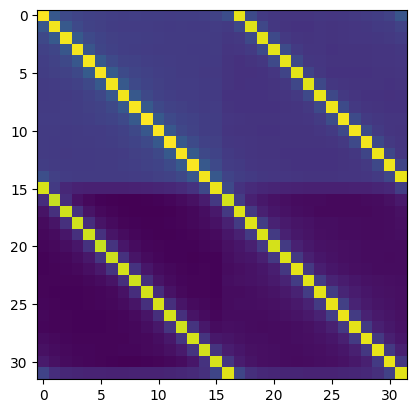

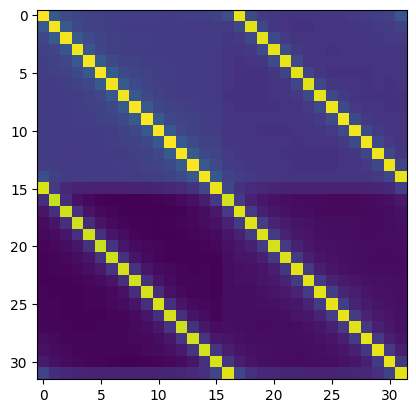

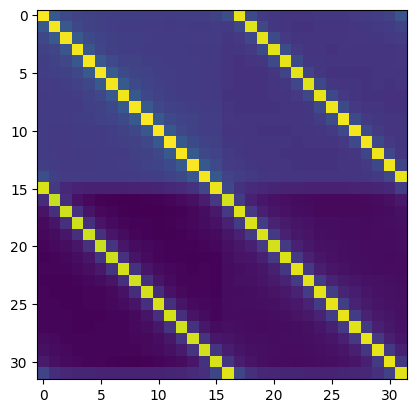

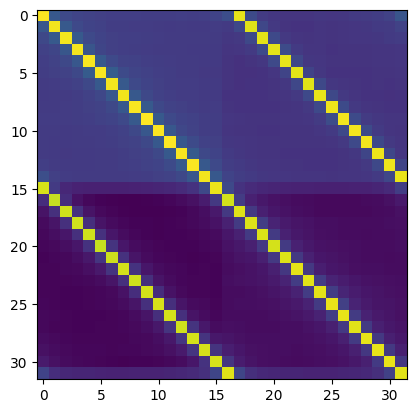

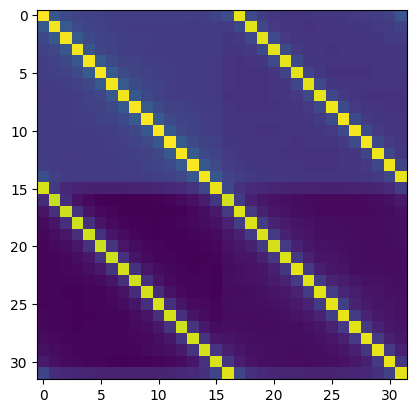

In [9]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [10]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    createTrajectory
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [11]:
printer = EnderControl(com_port="/dev/ttyUSB1")
printer.connect()

Connection to /dev/ttyUSB1 is established.


## Initializing Printer ##

In [12]:
printer.init()

b'start\n'
b'echo: External Reset\n'
b'Marlin Ver 1.70.3 BL\n'
b'\n'
b'echo: Last Updated: 2022-02-24 | Author: Ender-5 Plus\n'
b'echo:Compiled: Feb 24 2022\n'
b'echo: Free Memory: 1406  PlannerBufferBytes: 1232\n'
b'echo:V42 stored settings retrieved (530 bytes; crc 12996)\n'
b'echo:  G21    ; Units in mm\n'
b'echo:  M149 C ; Units in Celsius\n'
b'\n'
b'echo:Filament settings: Disabled\n'
b'echo:  M200 D1.75\n'
b'echo:  M200 D0\n'
b'echo:Steps per unit:\n'
b'echo:  M92 X80.00 Y80.00 Z800.00 E92.60\n'
b'echo:Maximum feedrates (units/s):\n'
b'echo:  M203 X300.00 Y300.00 Z5.00 E25.00\n'
b'echo:Maximum Acceleration (units/s2):\n'
b'echo:  M201 X500 Y500 Z100 E1000\n'
b'echo:Acceleration (units/s2): P<print_accel> R<retract_accel> T<travel_accel>\n'
b'echo:  M204 P500.00 R500.00 T1000.00\n'
b'echo:Advanced: S<min_feedrate> T<min_travel_feedrate> B<min_segment_time_ms> X<max_xy_jerk> Z<max_z_jerk> E<max_e_jerk>\n'
b'echo:  M205 S0.00 T0.00 B20000 X10.00 Y10.00 Z0.40 E5.00\n'
b'echo:Home off

[180, 180]

## Generating and saving data ##

In [16]:
traj_type = "Spirale"  
r_path = 0.75
Nsteps = 6000 
material = "Acryl Glas"
r_anomaly = 15

def generate_exp_data(traj, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data):
    # Berechne die Trajektorie
    center_pos = createTrajectory(traj, r_path*97, Nsteps)
    #CreateTrajectory(traj_type, radius, num_points, reference_radius=0.25, base_rotations=1):
    # Erstelle den Basisordner für die Datenspeicherung
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    # Bestimme den Ordnernamen
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    # Logge die Parameter
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": Nsteps,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    # Speichere die leeren Tankmessungen als ersten Datensatz
    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        # Speichere die Messung (Start bei sample_000001.npz)
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")

def empty_tank_measure():
    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [14]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [17]:
generate_exp_data(traj_type, r_path, r_anomaly, Nsteps, material, empty_tank_pos, empty_tank_timestamp, 
                  empty_tank_machine_time, empty_tank_temp, empty_tank_data)

  0%|                                                  | 0/6000 [00:00<?, ?it/s]

b'ok\n'


  0%|                                        | 1/6000 [00:04<7:33:52,  4.54s/it]

b'ok\n'


  0%|                                        | 2/6000 [00:09<7:33:48,  4.54s/it]

b'ok\n'


  0%|                                        | 3/6000 [00:13<7:33:43,  4.54s/it]

b'ok\n'


  0%|                                        | 4/6000 [00:18<7:33:39,  4.54s/it]

b'ok\n'


  0%|                                        | 5/6000 [00:22<7:32:57,  4.53s/it]

b'ok\n'


  0%|                                        | 6/6000 [00:27<7:33:07,  4.54s/it]

b'ok\n'


  0%|                                        | 7/6000 [00:31<7:33:26,  4.54s/it]

b'ok\n'


  0%|                                        | 8/6000 [00:36<7:33:26,  4.54s/it]

b'ok\n'


  0%|                                        | 9/6000 [00:40<7:33:17,  4.54s/it]

b'ok\n'


  0%|                                       | 10/6000 [00:45<7:32:08,  4.53s/it]

b'ok\n'


  0%|                                       | 11/6000 [00:49<7:32:25,  4.53s/it]

b'ok\n'


  0%|                                       | 12/6000 [00:54<7:32:38,  4.54s/it]

b'ok\n'


  0%|                                       | 13/6000 [00:58<7:32:40,  4.54s/it]

b'ok\n'


  0%|                                       | 14/6000 [01:03<7:32:41,  4.54s/it]

b'ok\n'


  0%|                                       | 15/6000 [01:08<7:32:43,  4.54s/it]

b'ok\n'


  0%|                                       | 16/6000 [01:12<7:32:49,  4.54s/it]

b'ok\n'


  0%|                                       | 17/6000 [01:17<7:32:52,  4.54s/it]

b'ok\n'


  0%|                                       | 18/6000 [01:21<7:32:38,  4.54s/it]

b'ok\n'


  0%|                                       | 19/6000 [01:26<7:32:21,  4.54s/it]

b'ok\n'


  0%|▏                                      | 20/6000 [01:30<7:32:20,  4.54s/it]

b'ok\n'


  0%|▏                                      | 21/6000 [01:35<7:32:19,  4.54s/it]

b'ok\n'


  0%|▏                                      | 22/6000 [01:39<7:32:30,  4.54s/it]

b'ok\n'


  0%|▏                                      | 23/6000 [01:44<7:31:34,  4.53s/it]

b'ok\n'


  0%|▏                                      | 24/6000 [01:48<7:31:16,  4.53s/it]

b'ok\n'


  0%|▏                                      | 25/6000 [01:53<7:31:34,  4.53s/it]

b'ok\n'


  0%|▏                                      | 26/6000 [01:57<7:31:55,  4.54s/it]

b'ok\n'


  0%|▏                                      | 27/6000 [02:02<7:31:55,  4.54s/it]

b'ok\n'


  0%|▏                                      | 28/6000 [02:07<7:31:49,  4.54s/it]

b'ok\n'


  0%|▏                                      | 29/6000 [02:11<7:31:47,  4.54s/it]

b'ok\n'


  0%|▏                                      | 30/6000 [02:16<7:31:15,  4.54s/it]

b'ok\n'


  1%|▏                                      | 31/6000 [02:20<7:31:24,  4.54s/it]

b'ok\n'


  1%|▏                                      | 32/6000 [02:25<7:31:21,  4.54s/it]

b'ok\n'


  1%|▏                                      | 33/6000 [02:29<7:31:23,  4.54s/it]

b'ok\n'


  1%|▏                                      | 34/6000 [02:34<7:31:08,  4.54s/it]

b'ok\n'


  1%|▏                                      | 35/6000 [02:38<7:30:15,  4.53s/it]

b'ok\n'


  1%|▏                                      | 36/6000 [02:43<7:30:25,  4.53s/it]

b'ok\n'


  1%|▏                                      | 37/6000 [02:47<7:30:45,  4.54s/it]

b'ok\n'


  1%|▏                                      | 38/6000 [02:52<7:29:59,  4.53s/it]

b'ok\n'


  1%|▎                                      | 39/6000 [02:56<7:30:20,  4.53s/it]

b'ok\n'


  1%|▎                                      | 40/6000 [03:01<7:30:37,  4.54s/it]

b'ok\n'


  1%|▎                                      | 41/6000 [03:06<7:30:39,  4.54s/it]

b'ok\n'


  1%|▎                                      | 42/6000 [03:10<7:29:43,  4.53s/it]

b'ok\n'


  1%|▎                                      | 43/6000 [03:15<7:30:00,  4.53s/it]

b'ok\n'


  1%|▎                                      | 44/6000 [03:19<7:30:11,  4.54s/it]

b'ok\n'


  1%|▎                                      | 45/6000 [03:24<7:29:37,  4.53s/it]

b'ok\n'


  1%|▎                                      | 46/6000 [03:28<7:29:51,  4.53s/it]

b'ok\n'


  1%|▎                                      | 47/6000 [03:33<7:29:22,  4.53s/it]

b'ok\n'


  1%|▎                                      | 48/6000 [03:37<7:29:50,  4.53s/it]

b'ok\n'


  1%|▎                                      | 49/6000 [03:42<7:30:00,  4.54s/it]

b'ok\n'


  1%|▎                                      | 50/6000 [03:46<7:29:06,  4.53s/it]

b'ok\n'


  1%|▎                                      | 51/6000 [03:51<7:29:16,  4.53s/it]

b'ok\n'


  1%|▎                                      | 52/6000 [03:55<7:28:49,  4.53s/it]

b'ok\n'


  1%|▎                                      | 53/6000 [04:00<7:29:08,  4.53s/it]

b'ok\n'


  1%|▎                                      | 54/6000 [04:04<7:29:29,  4.54s/it]

b'ok\n'


  1%|▎                                      | 55/6000 [04:09<7:29:32,  4.54s/it]

b'ok\n'


  1%|▎                                      | 56/6000 [04:14<7:29:34,  4.54s/it]

b'ok\n'


  1%|▎                                      | 57/6000 [04:18<7:29:31,  4.54s/it]

b'ok\n'


  1%|▍                                      | 58/6000 [04:23<7:29:30,  4.54s/it]

b'ok\n'


  1%|▍                                      | 59/6000 [04:27<7:29:35,  4.54s/it]

b'ok\n'


  1%|▍                                      | 60/6000 [04:32<7:29:11,  4.54s/it]

b'ok\n'


  1%|▍                                      | 61/6000 [04:36<7:29:06,  4.54s/it]

b'ok\n'


  1%|▍                                      | 62/6000 [04:41<7:28:31,  4.53s/it]

b'ok\n'


  1%|▍                                      | 63/6000 [04:45<7:28:50,  4.54s/it]

b'ok\n'


  1%|▍                                      | 64/6000 [04:50<7:28:59,  4.54s/it]

b'ok\n'


  1%|▍                                      | 65/6000 [04:54<7:28:33,  4.53s/it]

b'ok\n'


  1%|▍                                      | 66/6000 [04:59<7:28:37,  4.54s/it]

b'ok\n'


  1%|▍                                      | 67/6000 [05:03<7:28:11,  4.53s/it]

b'ok\n'


  1%|▍                                      | 68/6000 [05:08<7:28:23,  4.54s/it]

b'ok\n'


  1%|▍                                      | 69/6000 [05:12<7:28:34,  4.54s/it]

b'ok\n'


  1%|▍                                      | 70/6000 [05:17<7:28:42,  4.54s/it]

b'ok\n'


  1%|▍                                      | 71/6000 [05:22<7:28:32,  4.54s/it]

b'ok\n'


  1%|▍                                      | 72/6000 [05:26<7:28:17,  4.54s/it]

b'ok\n'


  1%|▍                                      | 73/6000 [05:31<7:28:20,  4.54s/it]

b'ok\n'


  1%|▍                                      | 74/6000 [05:35<7:28:25,  4.54s/it]

b'ok\n'


  1%|▍                                      | 75/6000 [05:40<7:27:46,  4.53s/it]

b'ok\n'


  1%|▍                                      | 76/6000 [05:44<7:26:54,  4.53s/it]

b'ok\n'


  1%|▌                                      | 77/6000 [05:49<7:26:38,  4.52s/it]

b'ok\n'


  1%|▌                                      | 78/6000 [05:53<7:26:05,  4.52s/it]

b'ok\n'


  1%|▌                                      | 79/6000 [05:58<7:26:18,  4.52s/it]

b'ok\n'


  1%|▌                                      | 80/6000 [06:02<7:26:57,  4.53s/it]

b'ok\n'


  1%|▌                                      | 81/6000 [06:07<7:27:07,  4.53s/it]

b'ok\n'


  1%|▌                                      | 82/6000 [06:11<7:26:30,  4.53s/it]

b'ok\n'


  1%|▌                                      | 83/6000 [06:16<7:26:51,  4.53s/it]

b'ok\n'


  1%|▌                                      | 84/6000 [06:20<7:26:15,  4.53s/it]

b'ok\n'


  1%|▌                                      | 85/6000 [06:25<7:25:49,  4.52s/it]

b'ok\n'


  1%|▌                                      | 86/6000 [06:29<7:25:40,  4.52s/it]

b'ok\n'


  1%|▌                                      | 87/6000 [06:34<7:26:13,  4.53s/it]

b'ok\n'


  1%|▌                                      | 88/6000 [06:39<7:26:40,  4.53s/it]

b'ok\n'


  1%|▌                                      | 89/6000 [06:43<7:26:38,  4.53s/it]

b'ok\n'


  2%|▌                                      | 90/6000 [06:48<7:26:46,  4.54s/it]

b'ok\n'


  2%|▌                                      | 91/6000 [06:52<7:26:40,  4.54s/it]

b'ok\n'


  2%|▌                                      | 92/6000 [06:57<7:26:45,  4.54s/it]

b'ok\n'


  2%|▌                                      | 93/6000 [07:01<7:26:45,  4.54s/it]

b'ok\n'


  2%|▌                                      | 94/6000 [07:06<7:26:35,  4.54s/it]

b'ok\n'


  2%|▌                                      | 95/6000 [07:10<7:26:37,  4.54s/it]

b'ok\n'


  2%|▌                                      | 96/6000 [07:15<7:26:24,  4.54s/it]

b'ok\n'


  2%|▋                                      | 97/6000 [07:19<7:26:32,  4.54s/it]

b'ok\n'


  2%|▋                                      | 98/6000 [07:24<7:26:28,  4.54s/it]

b'ok\n'


  2%|▋                                      | 99/6000 [07:28<7:25:49,  4.53s/it]

b'ok\n'


  2%|▋                                     | 100/6000 [07:33<7:25:55,  4.53s/it]

b'ok\n'


  2%|▋                                     | 101/6000 [07:38<7:25:32,  4.53s/it]

b'ok\n'


  2%|▋                                     | 102/6000 [07:42<7:25:49,  4.54s/it]

b'ok\n'


  2%|▋                                     | 103/6000 [07:47<7:26:12,  4.54s/it]

b'ok\n'


  2%|▋                                     | 104/6000 [07:51<7:26:06,  4.54s/it]

b'ok\n'


  2%|▋                                     | 105/6000 [07:56<7:25:33,  4.53s/it]

b'ok\n'


  2%|▋                                     | 106/6000 [08:00<7:25:42,  4.54s/it]

b'ok\n'


  2%|▋                                     | 107/6000 [08:05<7:25:38,  4.54s/it]

b'ok\n'


  2%|▋                                     | 108/6000 [08:09<7:25:39,  4.54s/it]

b'ok\n'


  2%|▋                                     | 109/6000 [08:14<7:25:11,  4.53s/it]

b'ok\n'


  2%|▋                                     | 110/6000 [08:18<7:25:16,  4.54s/it]

b'ok\n'


  2%|▋                                     | 111/6000 [08:23<7:24:54,  4.53s/it]

b'ok\n'


  2%|▋                                     | 112/6000 [08:27<7:25:05,  4.54s/it]

b'ok\n'


  2%|▋                                     | 113/6000 [08:32<7:25:12,  4.54s/it]

b'ok\n'


  2%|▋                                     | 114/6000 [08:36<7:24:29,  4.53s/it]

b'ok\n'


  2%|▋                                     | 115/6000 [08:41<7:24:39,  4.53s/it]

b'ok\n'


  2%|▋                                     | 116/6000 [08:46<7:24:15,  4.53s/it]

b'ok\n'


  2%|▋                                     | 117/6000 [08:50<7:24:32,  4.53s/it]

b'ok\n'


  2%|▋                                     | 118/6000 [08:55<7:24:31,  4.53s/it]

b'ok\n'


  2%|▊                                     | 119/6000 [08:59<7:24:43,  4.54s/it]

b'ok\n'


  2%|▊                                     | 120/6000 [09:04<7:24:45,  4.54s/it]

b'ok\n'


  2%|▊                                     | 121/6000 [09:08<7:24:44,  4.54s/it]

b'ok\n'


  2%|▊                                     | 122/6000 [09:13<7:24:44,  4.54s/it]

b'ok\n'


  2%|▊                                     | 123/6000 [09:17<7:24:52,  4.54s/it]

b'ok\n'


  2%|▊                                     | 124/6000 [09:22<7:24:47,  4.54s/it]

b'ok\n'


  2%|▊                                     | 125/6000 [09:26<7:24:39,  4.54s/it]

b'ok\n'


  2%|▊                                     | 126/6000 [09:31<7:24:32,  4.54s/it]

b'ok\n'


  2%|▊                                     | 127/6000 [09:35<7:24:27,  4.54s/it]

b'ok\n'


  2%|▊                                     | 128/6000 [09:40<7:23:38,  4.53s/it]

b'ok\n'


  2%|▊                                     | 129/6000 [09:45<7:23:09,  4.53s/it]

b'ok\n'


  2%|▊                                     | 130/6000 [09:49<7:22:49,  4.53s/it]

b'ok\n'


  2%|▊                                     | 131/6000 [09:54<7:23:20,  4.53s/it]

b'ok\n'


  2%|▊                                     | 132/6000 [09:58<7:23:26,  4.53s/it]

b'ok\n'


  2%|▊                                     | 133/6000 [10:03<7:23:05,  4.53s/it]

b'ok\n'


  2%|▊                                     | 134/6000 [10:07<7:23:19,  4.53s/it]

b'ok\n'


  2%|▊                                     | 135/6000 [10:12<7:23:14,  4.53s/it]

b'ok\n'


  2%|▊                                     | 136/6000 [10:16<7:22:42,  4.53s/it]

b'ok\n'


  2%|▊                                     | 137/6000 [10:21<7:22:14,  4.53s/it]

b'ok\n'


  2%|▊                                     | 138/6000 [10:25<7:22:33,  4.53s/it]

b'ok\n'


  2%|▉                                     | 139/6000 [10:30<7:22:39,  4.53s/it]

b'ok\n'


  2%|▉                                     | 140/6000 [10:34<7:22:49,  4.53s/it]

b'ok\n'


  2%|▉                                     | 141/6000 [10:39<7:22:53,  4.54s/it]

b'ok\n'


  2%|▉                                     | 142/6000 [10:43<7:23:06,  4.54s/it]

b'ok\n'


  2%|▉                                     | 143/6000 [10:48<7:23:06,  4.54s/it]

b'ok\n'


  2%|▉                                     | 144/6000 [10:53<7:22:51,  4.54s/it]

b'ok\n'


  2%|▉                                     | 145/6000 [10:57<7:22:24,  4.53s/it]

b'ok\n'


  2%|▉                                     | 146/6000 [11:02<7:22:42,  4.54s/it]

b'ok\n'


  2%|▉                                     | 147/6000 [11:06<7:21:48,  4.53s/it]

b'ok\n'


  2%|▉                                     | 148/6000 [11:11<7:21:58,  4.53s/it]

b'ok\n'


  2%|▉                                     | 149/6000 [11:15<7:22:15,  4.54s/it]

b'ok\n'


  2%|▉                                     | 150/6000 [11:20<7:21:32,  4.53s/it]

b'ok\n'


  3%|▉                                     | 151/6000 [11:24<7:21:41,  4.53s/it]

b'ok\n'


  3%|▉                                     | 152/6000 [11:29<7:22:00,  4.53s/it]

b'ok\n'


  3%|▉                                     | 153/6000 [11:33<7:22:12,  4.54s/it]

b'ok\n'


  3%|▉                                     | 154/6000 [11:38<7:22:21,  4.54s/it]

b'ok\n'


  3%|▉                                     | 155/6000 [11:42<7:22:17,  4.54s/it]

b'ok\n'


  3%|▉                                     | 156/6000 [11:47<7:22:07,  4.54s/it]

b'ok\n'


  3%|▉                                     | 157/6000 [11:52<7:22:05,  4.54s/it]

b'ok\n'


  3%|█                                     | 158/6000 [11:56<7:22:02,  4.54s/it]

b'ok\n'


  3%|█                                     | 159/6000 [12:01<7:21:57,  4.54s/it]

b'ok\n'


  3%|█                                     | 160/6000 [12:05<7:21:26,  4.54s/it]

b'ok\n'


  3%|█                                     | 161/6000 [12:10<7:21:42,  4.54s/it]

b'ok\n'


  3%|█                                     | 162/6000 [12:14<7:21:45,  4.54s/it]

b'ok\n'


  3%|█                                     | 163/6000 [12:19<7:20:56,  4.53s/it]

b'ok\n'


  3%|█                                     | 164/6000 [12:23<7:21:00,  4.53s/it]

b'ok\n'


  3%|█                                     | 165/6000 [12:28<7:20:50,  4.53s/it]

b'ok\n'


  3%|█                                     | 166/6000 [12:32<7:21:02,  4.54s/it]

b'ok\n'


  3%|█                                     | 167/6000 [12:37<7:21:07,  4.54s/it]

b'ok\n'


  3%|█                                     | 168/6000 [12:41<7:20:58,  4.54s/it]

b'ok\n'


  3%|█                                     | 169/6000 [12:46<7:21:00,  4.54s/it]

b'ok\n'


  3%|█                                     | 170/6000 [12:50<7:21:07,  4.54s/it]

b'ok\n'


  3%|█                                     | 171/6000 [12:55<7:21:03,  4.54s/it]

b'ok\n'


  3%|█                                     | 172/6000 [13:00<7:21:02,  4.54s/it]

b'ok\n'


  3%|█                                     | 173/6000 [13:04<7:20:14,  4.53s/it]

b'ok\n'


  3%|█                                     | 174/6000 [13:09<7:20:28,  4.54s/it]

b'ok\n'


  3%|█                                     | 175/6000 [13:13<7:19:56,  4.53s/it]

b'ok\n'


  3%|█                                     | 176/6000 [13:18<7:20:09,  4.53s/it]

b'ok\n'


  3%|█                                     | 177/6000 [13:22<7:20:10,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 178/6000 [13:27<7:19:34,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 179/6000 [13:31<7:19:43,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 180/6000 [13:36<7:19:43,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 181/6000 [13:40<7:19:49,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 182/6000 [13:45<7:20:02,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 183/6000 [13:49<7:19:27,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 184/6000 [13:54<7:19:36,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 185/6000 [13:58<7:19:31,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 186/6000 [14:03<7:19:35,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 187/6000 [14:08<7:19:44,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 188/6000 [14:12<7:19:17,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 189/6000 [14:17<7:19:21,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 190/6000 [14:21<7:19:06,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 191/6000 [14:26<7:19:16,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 192/6000 [14:30<7:19:21,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 193/6000 [14:35<7:18:22,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 194/6000 [14:39<7:18:22,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 195/6000 [14:44<7:18:43,  4.53s/it]

b'ok\n'


  3%|█▏                                    | 196/6000 [14:48<7:18:49,  4.54s/it]

b'ok\n'


  3%|█▏                                    | 197/6000 [14:53<7:18:43,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 198/6000 [14:57<7:18:37,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 199/6000 [15:02<7:18:39,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 200/6000 [15:07<7:18:12,  4.53s/it]

b'ok\n'


  3%|█▎                                    | 201/6000 [15:11<7:18:22,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 202/6000 [15:16<7:18:26,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 203/6000 [15:20<7:18:10,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 204/6000 [15:25<7:18:13,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 205/6000 [15:29<7:18:05,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 206/6000 [15:34<7:18:11,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 207/6000 [15:38<7:18:08,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 208/6000 [15:43<7:18:08,  4.54s/it]

b'ok\n'


  3%|█▎                                    | 209/6000 [15:47<7:18:17,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 210/6000 [15:52<7:17:16,  4.53s/it]

b'ok\n'


  4%|█▎                                    | 211/6000 [15:56<7:17:25,  4.53s/it]

b'ok\n'


  4%|█▎                                    | 212/6000 [16:01<7:17:32,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 213/6000 [16:06<7:17:34,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 214/6000 [16:10<7:17:43,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 215/6000 [16:15<7:17:41,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 216/6000 [16:19<7:17:40,  4.54s/it]

b'ok\n'


  4%|█▎                                    | 217/6000 [16:24<7:17:34,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 218/6000 [16:28<7:17:04,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 219/6000 [16:33<7:17:06,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 220/6000 [16:37<7:16:35,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 221/6000 [16:42<7:16:45,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 222/6000 [16:46<7:16:47,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 223/6000 [16:51<7:16:19,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 224/6000 [16:55<7:16:33,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 225/6000 [17:00<7:16:18,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 226/6000 [17:04<7:16:21,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 227/6000 [17:09<7:16:26,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 228/6000 [17:14<7:16:38,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 229/6000 [17:18<7:16:35,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 230/6000 [17:23<7:16:32,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 231/6000 [17:27<7:16:30,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 232/6000 [17:32<7:16:32,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 233/6000 [17:36<7:15:50,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 234/6000 [17:41<7:15:49,  4.54s/it]

b'ok\n'


  4%|█▍                                    | 235/6000 [17:45<7:15:25,  4.53s/it]

b'ok\n'


  4%|█▍                                    | 236/6000 [17:50<7:15:43,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 237/6000 [17:54<7:15:47,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 238/6000 [17:59<7:15:05,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 239/6000 [18:03<7:15:10,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 240/6000 [18:08<7:15:21,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 241/6000 [18:13<7:15:32,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 242/6000 [18:17<7:15:38,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 243/6000 [18:22<7:15:35,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 244/6000 [18:26<7:15:32,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 245/6000 [18:31<7:15:28,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 246/6000 [18:35<7:15:31,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 247/6000 [18:40<7:15:32,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 248/6000 [18:44<7:14:50,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 249/6000 [18:49<7:14:46,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 250/6000 [18:53<7:14:48,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 251/6000 [18:58<7:14:48,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 252/6000 [19:02<7:14:47,  4.54s/it]

b'ok\n'


  4%|█▌                                    | 253/6000 [19:07<7:13:42,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 254/6000 [19:11<7:13:45,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 255/6000 [19:16<7:14:05,  4.53s/it]

b'ok\n'


  4%|█▌                                    | 256/6000 [19:21<7:14:12,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 257/6000 [19:25<7:14:16,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 258/6000 [19:30<7:14:08,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 259/6000 [19:34<7:14:09,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 260/6000 [19:39<7:14:01,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 261/6000 [19:43<7:13:12,  4.53s/it]

b'ok\n'


  4%|█▋                                    | 262/6000 [19:48<7:13:25,  4.53s/it]

b'ok\n'


  4%|█▋                                    | 263/6000 [19:52<7:13:34,  4.53s/it]

b'ok\n'


  4%|█▋                                    | 264/6000 [19:57<7:13:39,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 265/6000 [20:01<7:13:15,  4.53s/it]

b'ok\n'


  4%|█▋                                    | 266/6000 [20:06<7:13:27,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 267/6000 [20:10<7:13:27,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 268/6000 [20:15<7:13:03,  4.53s/it]

b'ok\n'


  4%|█▋                                    | 269/6000 [20:20<7:13:11,  4.54s/it]

b'ok\n'


  4%|█▋                                    | 270/6000 [20:24<7:12:23,  4.53s/it]

b'ok\n'


  5%|█▋                                    | 271/6000 [20:29<7:12:40,  4.53s/it]

b'ok\n'


  5%|█▋                                    | 272/6000 [20:33<7:12:43,  4.53s/it]

b'ok\n'


  5%|█▋                                    | 273/6000 [20:38<7:12:41,  4.53s/it]

b'ok\n'


  5%|█▋                                    | 274/6000 [20:42<7:12:58,  4.54s/it]

b'ok\n'


  5%|█▋                                    | 275/6000 [20:47<7:12:58,  4.54s/it]

b'ok\n'


  5%|█▋                                    | 276/6000 [20:51<7:13:00,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 277/6000 [20:56<7:12:49,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 278/6000 [21:00<7:12:46,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 279/6000 [21:05<7:12:45,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 280/6000 [21:09<7:12:15,  4.53s/it]

b'ok\n'


  5%|█▊                                    | 281/6000 [21:14<7:12:19,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 282/6000 [21:18<7:12:13,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 283/6000 [21:23<7:12:16,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 284/6000 [21:28<7:12:23,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 285/6000 [21:32<7:11:47,  4.53s/it]

b'ok\n'


  5%|█▊                                    | 286/6000 [21:37<7:11:46,  4.53s/it]

b'ok\n'


  5%|█▊                                    | 287/6000 [21:41<7:11:53,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 288/6000 [21:46<7:12:02,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 289/6000 [21:50<7:12:11,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 290/6000 [21:55<7:12:08,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 291/6000 [21:59<7:12:02,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 292/6000 [22:04<7:11:46,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 293/6000 [22:08<7:11:37,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 294/6000 [22:13<7:11:37,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 295/6000 [22:17<7:11:19,  4.54s/it]

b'ok\n'


  5%|█▊                                    | 296/6000 [22:22<7:11:14,  4.54s/it]

b'ok\n'


  5%|█▉                                    | 297/6000 [22:27<7:11:05,  4.54s/it]

b'ok\n'


  5%|█▉                                    | 298/6000 [22:31<7:10:40,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 299/6000 [22:36<7:10:52,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 300/6000 [22:40<7:10:35,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 301/6000 [22:45<7:10:39,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 302/6000 [22:49<7:10:00,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 303/6000 [22:54<7:10:18,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 304/6000 [22:58<7:09:34,  4.52s/it]

b'ok\n'


  5%|█▉                                    | 305/6000 [23:03<7:09:58,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 306/6000 [23:07<7:10:12,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 307/6000 [23:12<7:09:57,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 308/6000 [23:16<7:10:11,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 309/6000 [23:21<7:10:17,  4.54s/it]

b'ok\n'


  5%|█▉                                    | 310/6000 [23:25<7:10:19,  4.54s/it]

b'ok\n'


  5%|█▉                                    | 311/6000 [23:30<7:09:36,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 312/6000 [23:35<7:09:54,  4.53s/it]

b'ok\n'


  5%|█▉                                    | 313/6000 [23:39<7:10:07,  4.54s/it]

b'ok\n'


  5%|█▉                                    | 314/6000 [23:44<7:08:45,  4.52s/it]

b'ok\n'


  5%|█▉                                    | 315/6000 [23:48<7:09:10,  4.53s/it]

b'ok\n'


  5%|██                                    | 316/6000 [23:53<7:09:16,  4.53s/it]

b'ok\n'


  5%|██                                    | 317/6000 [23:57<7:09:30,  4.53s/it]

b'ok\n'


  5%|██                                    | 318/6000 [24:02<7:09:38,  4.54s/it]

b'ok\n'


  5%|██                                    | 319/6000 [24:06<7:08:46,  4.53s/it]

b'ok\n'


  5%|██                                    | 320/6000 [24:11<7:08:56,  4.53s/it]

b'ok\n'


  5%|██                                    | 321/6000 [24:15<7:08:14,  4.52s/it]

b'ok\n'


  5%|██                                    | 322/6000 [24:20<7:08:43,  4.53s/it]

b'ok\n'


  5%|██                                    | 323/6000 [24:24<7:08:51,  4.53s/it]

b'ok\n'


  5%|██                                    | 324/6000 [24:29<7:08:57,  4.53s/it]

b'ok\n'


  5%|██                                    | 325/6000 [24:33<7:09:02,  4.54s/it]

b'ok\n'


  5%|██                                    | 326/6000 [24:38<7:09:04,  4.54s/it]

b'ok\n'


  5%|██                                    | 327/6000 [24:43<7:09:03,  4.54s/it]

b'ok\n'


  5%|██                                    | 328/6000 [24:47<7:09:03,  4.54s/it]

b'ok\n'


  5%|██                                    | 329/6000 [24:52<7:08:54,  4.54s/it]

b'ok\n'


  6%|██                                    | 330/6000 [24:56<7:08:52,  4.54s/it]

b'ok\n'


  6%|██                                    | 331/6000 [25:01<7:08:49,  4.54s/it]

b'ok\n'


  6%|██                                    | 332/6000 [25:05<7:08:51,  4.54s/it]

b'ok\n'


  6%|██                                    | 333/6000 [25:10<7:08:36,  4.54s/it]

b'ok\n'


  6%|██                                    | 334/6000 [25:14<7:07:40,  4.53s/it]

b'ok\n'


  6%|██                                    | 335/6000 [25:19<7:07:29,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 336/6000 [25:23<7:07:07,  4.52s/it]

b'ok\n'


  6%|██▏                                   | 337/6000 [25:28<7:07:28,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 338/6000 [25:32<7:06:51,  4.52s/it]

b'ok\n'


  6%|██▏                                   | 339/6000 [25:37<7:07:13,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 340/6000 [25:41<7:07:30,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 341/6000 [25:46<7:07:38,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 342/6000 [25:51<7:07:43,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 343/6000 [25:55<7:07:39,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 344/6000 [26:00<7:07:42,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 345/6000 [26:04<7:07:41,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 346/6000 [26:09<7:06:58,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 347/6000 [26:13<7:07:11,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 348/6000 [26:18<7:07:24,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 349/6000 [26:22<7:07:26,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 350/6000 [26:27<7:07:31,  4.54s/it]

b'ok\n'


  6%|██▏                                   | 351/6000 [26:31<7:06:33,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 352/6000 [26:36<7:06:13,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 353/6000 [26:40<7:06:38,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 354/6000 [26:45<7:06:44,  4.53s/it]

b'ok\n'


  6%|██▏                                   | 355/6000 [26:49<7:06:50,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 356/6000 [26:54<7:06:50,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 357/6000 [26:59<7:06:50,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 358/6000 [27:03<7:06:49,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 359/6000 [27:08<7:06:45,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 360/6000 [27:12<7:06:41,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 361/6000 [27:17<7:06:04,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 362/6000 [27:21<7:05:56,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 363/6000 [27:26<7:06:05,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 364/6000 [27:30<7:06:09,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 365/6000 [27:35<7:06:07,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 366/6000 [27:39<7:05:12,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 367/6000 [27:44<7:04:43,  4.52s/it]

b'ok\n'


  6%|██▎                                   | 368/6000 [27:48<7:04:56,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 369/6000 [27:53<7:05:17,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 370/6000 [27:57<7:05:27,  4.53s/it]

b'ok\n'


  6%|██▎                                   | 371/6000 [28:02<7:05:30,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 372/6000 [28:07<7:05:33,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 373/6000 [28:11<7:05:30,  4.54s/it]

b'ok\n'


  6%|██▎                                   | 374/6000 [28:16<7:05:19,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 375/6000 [28:20<7:05:19,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 376/6000 [28:25<7:05:03,  4.53s/it]

b'ok\n'


  6%|██▍                                   | 377/6000 [28:29<7:05:01,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 378/6000 [28:34<7:04:30,  4.53s/it]

b'ok\n'


  6%|██▍                                   | 379/6000 [28:38<7:04:43,  4.53s/it]

b'ok\n'


  6%|██▍                                   | 380/6000 [28:43<7:04:47,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 381/6000 [28:47<7:04:27,  4.53s/it]

b'ok\n'


  6%|██▍                                   | 382/6000 [28:52<7:04:41,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 383/6000 [28:56<7:04:25,  4.53s/it]

b'ok\n'


  6%|██▍                                   | 384/6000 [29:01<7:04:28,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 385/6000 [29:06<7:04:31,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 386/6000 [29:10<7:04:35,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 387/6000 [29:15<7:04:32,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 388/6000 [29:19<7:04:24,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 389/6000 [29:24<7:04:21,  4.54s/it]

b'ok\n'


  6%|██▍                                   | 390/6000 [29:28<7:04:22,  4.54s/it]

b'ok\n'


  7%|██▍                                   | 391/6000 [29:33<7:03:54,  4.53s/it]

b'ok\n'


  7%|██▍                                   | 392/6000 [29:37<7:03:59,  4.54s/it]

b'ok\n'


  7%|██▍                                   | 393/6000 [29:42<7:03:51,  4.54s/it]

b'ok\n'


  7%|██▍                                   | 394/6000 [29:46<7:04:04,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 395/6000 [29:51<7:03:51,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 396/6000 [29:55<7:03:10,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 397/6000 [30:00<7:03:27,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 398/6000 [30:04<7:03:42,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 399/6000 [30:09<7:02:48,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 400/6000 [30:14<7:03:06,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 401/6000 [30:18<7:03:10,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 402/6000 [30:23<7:03:14,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 403/6000 [30:27<7:03:17,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 404/6000 [30:32<7:03:16,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 405/6000 [30:36<7:03:13,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 406/6000 [30:41<7:02:47,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 407/6000 [30:45<7:02:42,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 408/6000 [30:50<7:02:15,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 409/6000 [30:54<7:02:29,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 410/6000 [30:59<7:02:31,  4.54s/it]

b'ok\n'


  7%|██▌                                   | 411/6000 [31:03<7:02:13,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 412/6000 [31:08<7:02:21,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 413/6000 [31:12<7:01:57,  4.53s/it]

b'ok\n'


  7%|██▌                                   | 414/6000 [31:17<7:02:06,  4.53s/it]

b'ok\n'


  7%|██▋                                   | 415/6000 [31:22<7:02:13,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 416/6000 [31:26<7:02:22,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 417/6000 [31:31<7:02:30,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 418/6000 [31:35<7:02:17,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 419/6000 [31:40<7:02:12,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 420/6000 [31:44<7:02:09,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 421/6000 [31:49<7:02:06,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 422/6000 [31:53<7:02:04,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 423/6000 [31:58<7:01:50,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 424/6000 [32:02<7:01:55,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 425/6000 [32:07<7:01:35,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 426/6000 [32:12<7:01:33,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 427/6000 [32:16<7:01:28,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 428/6000 [32:21<7:01:14,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 429/6000 [32:25<7:01:13,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 430/6000 [32:30<7:01:08,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 431/6000 [32:34<7:01:05,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 432/6000 [32:39<7:01:15,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 433/6000 [32:43<7:01:09,  4.54s/it]

b'ok\n'


  7%|██▋                                   | 434/6000 [32:48<7:01:01,  4.54s/it]

b'ok\n'


  7%|██▊                                   | 435/6000 [32:52<7:01:01,  4.54s/it]

b'ok\n'


  7%|██▊                                   | 436/6000 [32:57<7:01:02,  4.54s/it]

b'ok\n'


  7%|██▊                                   | 437/6000 [33:01<7:00:48,  4.54s/it]

b'ok\n'


  7%|██▊                                   | 438/6000 [33:06<7:00:07,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 439/6000 [33:10<7:00:15,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 440/6000 [33:15<7:00:03,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 441/6000 [33:20<6:59:32,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 442/6000 [33:24<6:59:37,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 443/6000 [33:29<6:59:02,  4.52s/it]

b'ok\n'


  7%|██▊                                   | 444/6000 [33:33<6:59:20,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 445/6000 [33:38<6:58:35,  4.52s/it]

b'ok\n'


  7%|██▊                                   | 446/6000 [33:42<6:58:48,  4.52s/it]

b'ok\n'


  7%|██▊                                   | 447/6000 [33:47<6:59:16,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 448/6000 [33:51<6:59:27,  4.53s/it]

b'ok\n'


  7%|██▊                                   | 449/6000 [33:56<6:59:34,  4.54s/it]

b'ok\n'


  8%|██▊                                   | 450/6000 [34:00<6:59:38,  4.54s/it]

b'ok\n'


  8%|██▊                                   | 451/6000 [34:05<6:59:39,  4.54s/it]

b'ok\n'


  8%|██▊                                   | 452/6000 [34:09<6:59:45,  4.54s/it]

b'ok\n'


  8%|██▊                                   | 453/6000 [34:14<6:59:43,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 454/6000 [34:18<6:59:39,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 455/6000 [34:23<6:59:49,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 456/6000 [34:28<6:59:47,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 457/6000 [34:32<6:59:33,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 458/6000 [34:37<6:59:16,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 459/6000 [34:41<6:59:01,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 460/6000 [34:46<6:58:05,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 461/6000 [34:50<6:58:32,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 462/6000 [34:55<6:58:40,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 463/6000 [34:59<6:57:53,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 464/6000 [35:04<6:58:08,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 465/6000 [35:08<6:58:14,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 466/6000 [35:13<6:58:13,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 467/6000 [35:17<6:58:18,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 468/6000 [35:22<6:58:20,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 469/6000 [35:27<6:58:28,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 470/6000 [35:31<6:57:44,  4.53s/it]

b'ok\n'


  8%|██▉                                   | 471/6000 [35:36<6:57:54,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 472/6000 [35:40<6:57:55,  4.54s/it]

b'ok\n'


  8%|██▉                                   | 473/6000 [35:45<6:57:59,  4.54s/it]

b'ok\n'


  8%|███                                   | 474/6000 [35:49<6:57:57,  4.54s/it]

b'ok\n'


  8%|███                                   | 475/6000 [35:54<6:57:57,  4.54s/it]

b'ok\n'


  8%|███                                   | 476/6000 [35:58<6:58:13,  4.54s/it]

b'ok\n'


  8%|███                                   | 477/6000 [36:03<6:58:09,  4.54s/it]

b'ok\n'


  8%|███                                   | 478/6000 [36:07<6:57:59,  4.54s/it]

b'ok\n'


  8%|███                                   | 479/6000 [36:12<6:57:07,  4.53s/it]

b'ok\n'


  8%|███                                   | 480/6000 [36:16<6:57:10,  4.53s/it]

b'ok\n'


  8%|███                                   | 481/6000 [36:21<6:57:20,  4.54s/it]

b'ok\n'


  8%|███                                   | 482/6000 [36:26<6:57:15,  4.54s/it]

b'ok\n'


  8%|███                                   | 483/6000 [36:30<6:57:18,  4.54s/it]

b'ok\n'


  8%|███                                   | 484/6000 [36:35<6:57:12,  4.54s/it]

b'ok\n'


  8%|███                                   | 485/6000 [36:39<6:56:46,  4.53s/it]

b'ok\n'


  8%|███                                   | 486/6000 [36:44<6:56:16,  4.53s/it]

b'ok\n'


  8%|███                                   | 487/6000 [36:48<6:56:23,  4.53s/it]

b'ok\n'


  8%|███                                   | 488/6000 [36:53<6:56:25,  4.53s/it]

b'ok\n'


  8%|███                                   | 489/6000 [36:57<6:56:21,  4.53s/it]

b'ok\n'


  8%|███                                   | 490/6000 [37:02<6:55:25,  4.52s/it]

b'ok\n'


  8%|███                                   | 491/6000 [37:06<6:55:37,  4.53s/it]

b'ok\n'


  8%|███                                   | 492/6000 [37:11<6:54:50,  4.52s/it]

b'ok\n'


  8%|███                                   | 493/6000 [37:15<6:55:10,  4.52s/it]

b'ok\n'


  8%|███▏                                  | 494/6000 [37:20<6:55:32,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 495/6000 [37:24<6:55:07,  4.52s/it]

b'ok\n'


  8%|███▏                                  | 496/6000 [37:29<6:55:20,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 497/6000 [37:33<6:55:28,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 498/6000 [37:38<6:55:32,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 499/6000 [37:42<6:55:25,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 500/6000 [37:47<6:55:12,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 501/6000 [37:52<6:55:16,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 502/6000 [37:56<6:55:17,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 503/6000 [38:01<6:55:18,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 504/6000 [38:05<6:54:37,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 505/6000 [38:10<6:54:53,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 506/6000 [38:14<6:54:56,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 507/6000 [38:19<6:54:51,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 508/6000 [38:23<6:54:41,  4.53s/it]

b'ok\n'


  8%|███▏                                  | 509/6000 [38:28<6:53:53,  4.52s/it]

b'ok\n'


  8%|███▏                                  | 510/6000 [38:32<6:54:10,  4.53s/it]

b'ok\n'


  9%|███▏                                  | 511/6000 [38:37<6:53:58,  4.53s/it]

b'ok\n'


  9%|███▏                                  | 512/6000 [38:41<6:54:07,  4.53s/it]

b'ok\n'


  9%|███▏                                  | 513/6000 [38:46<6:54:14,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 514/6000 [38:50<6:54:19,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 515/6000 [38:55<6:54:20,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 516/6000 [39:00<6:54:22,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 517/6000 [39:04<6:54:17,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 518/6000 [39:09<6:54:15,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 519/6000 [39:13<6:54:12,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 520/6000 [39:18<6:54:09,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 521/6000 [39:22<6:54:09,  4.54s/it]

b'ok\n'


  9%|███▎                                  | 522/6000 [39:27<6:54:04,  4.54s/it]

b'ok\n'


  9%|███▎                                  | 523/6000 [39:31<6:53:57,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 524/6000 [39:36<6:53:47,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 525/6000 [39:40<6:53:41,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 526/6000 [39:45<6:52:44,  4.52s/it]

b'ok\n'


  9%|███▎                                  | 527/6000 [39:49<6:52:55,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 528/6000 [39:54<6:52:12,  4.52s/it]

b'ok\n'


  9%|███▎                                  | 529/6000 [39:58<6:52:29,  4.52s/it]

b'ok\n'


  9%|███▎                                  | 530/6000 [40:03<6:52:35,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 531/6000 [40:07<6:52:43,  4.53s/it]

b'ok\n'


  9%|███▎                                  | 532/6000 [40:12<6:52:51,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 533/6000 [40:17<6:52:53,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 534/6000 [40:21<6:52:49,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 535/6000 [40:26<6:52:26,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 536/6000 [40:30<6:52:39,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 537/6000 [40:35<6:52:35,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 538/6000 [40:39<6:52:37,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 539/6000 [40:44<6:52:35,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 540/6000 [40:48<6:52:08,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 541/6000 [40:53<6:52:16,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 542/6000 [40:57<6:52:04,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 543/6000 [41:02<6:52:06,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 544/6000 [41:06<6:52:06,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 545/6000 [41:11<6:51:16,  4.52s/it]

b'ok\n'


  9%|███▍                                  | 546/6000 [41:15<6:51:23,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 547/6000 [41:20<6:50:45,  4.52s/it]

b'ok\n'


  9%|███▍                                  | 548/6000 [41:24<6:51:06,  4.52s/it]

b'ok\n'


  9%|███▍                                  | 549/6000 [41:29<6:51:26,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 550/6000 [41:34<6:51:25,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 551/6000 [41:38<6:51:21,  4.53s/it]

b'ok\n'


  9%|███▍                                  | 552/6000 [41:43<6:51:23,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 553/6000 [41:47<6:51:27,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 554/6000 [41:52<6:51:27,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 555/6000 [41:56<6:51:25,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 556/6000 [42:01<6:51:16,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 557/6000 [42:05<6:51:19,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 558/6000 [42:10<6:51:21,  4.54s/it]

b'ok\n'


  9%|███▌                                  | 559/6000 [42:14<6:50:49,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 560/6000 [42:19<6:50:47,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 561/6000 [42:23<6:50:22,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 562/6000 [42:28<6:50:33,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 563/6000 [42:32<6:50:41,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 564/6000 [42:37<6:49:44,  4.52s/it]

b'ok\n'


  9%|███▌                                  | 565/6000 [42:41<6:49:54,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 566/6000 [42:46<6:49:07,  4.52s/it]

b'ok\n'


  9%|███▌                                  | 567/6000 [42:50<6:49:32,  4.52s/it]

b'ok\n'


  9%|███▌                                  | 568/6000 [42:55<6:49:56,  4.53s/it]

b'ok\n'


  9%|███▌                                  | 569/6000 [43:00<6:49:56,  4.53s/it]

b'ok\n'


 10%|███▌                                  | 570/6000 [43:04<6:49:53,  4.53s/it]

b'ok\n'


 10%|███▌                                  | 571/6000 [43:09<6:49:59,  4.53s/it]

b'ok\n'


 10%|███▌                                  | 572/6000 [43:13<6:50:01,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 573/6000 [43:18<6:49:59,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 574/6000 [43:22<6:50:00,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 575/6000 [43:27<6:50:00,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 576/6000 [43:31<6:49:28,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 577/6000 [43:36<6:48:44,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 578/6000 [43:40<6:48:28,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 579/6000 [43:45<6:48:47,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 580/6000 [43:49<6:49:00,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 581/6000 [43:54<6:49:04,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 582/6000 [43:58<6:49:06,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 583/6000 [44:03<6:48:19,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 584/6000 [44:07<6:48:38,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 585/6000 [44:12<6:47:54,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 586/6000 [44:17<6:48:10,  4.52s/it]

b'ok\n'


 10%|███▋                                  | 587/6000 [44:21<6:48:19,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 588/6000 [44:26<6:48:26,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 589/6000 [44:30<6:48:34,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 590/6000 [44:35<6:48:36,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 591/6000 [44:39<6:48:37,  4.53s/it]

b'ok\n'


 10%|███▋                                  | 592/6000 [44:44<6:48:36,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 593/6000 [44:48<6:48:35,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 594/6000 [44:53<6:48:34,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 595/6000 [44:57<6:48:04,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 596/6000 [45:02<6:48:09,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 597/6000 [45:06<6:47:15,  4.52s/it]

b'ok\n'


 10%|███▊                                  | 598/6000 [45:11<6:47:37,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 599/6000 [45:15<6:47:34,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 600/6000 [45:20<6:47:33,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 601/6000 [45:24<6:47:33,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 602/6000 [45:29<6:46:53,  4.52s/it]

b'ok\n'


 10%|███▊                                  | 603/6000 [45:34<6:47:13,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 604/6000 [45:38<6:46:51,  4.52s/it]

b'ok\n'


 10%|███▊                                  | 605/6000 [45:43<6:46:55,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 606/6000 [45:47<6:47:13,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 607/6000 [45:52<6:47:18,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 608/6000 [45:56<6:47:19,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 609/6000 [46:01<6:47:18,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 610/6000 [46:05<6:47:09,  4.53s/it]

b'ok\n'


 10%|███▊                                  | 611/6000 [46:10<6:47:08,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 612/6000 [46:14<6:47:07,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 613/6000 [46:19<6:47:06,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 614/6000 [46:23<6:46:31,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 615/6000 [46:28<6:46:34,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 616/6000 [46:32<6:46:14,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 617/6000 [46:37<6:46:25,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 618/6000 [46:41<6:46:16,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 619/6000 [46:46<6:46:15,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 620/6000 [46:51<6:46:18,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 621/6000 [46:55<6:45:36,  4.52s/it]

b'ok\n'


 10%|███▉                                  | 622/6000 [47:00<6:45:44,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 623/6000 [47:04<6:45:43,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 624/6000 [47:09<6:45:54,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 625/6000 [47:13<6:45:57,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 626/6000 [47:18<6:45:46,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 627/6000 [47:22<6:45:45,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 628/6000 [47:27<6:45:46,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 629/6000 [47:31<6:45:55,  4.53s/it]

b'ok\n'


 10%|███▉                                  | 630/6000 [47:36<6:45:51,  4.53s/it]

b'ok\n'


 11%|███▉                                  | 631/6000 [47:40<6:45:46,  4.53s/it]

b'ok\n'


 11%|████                                  | 632/6000 [47:45<6:45:42,  4.53s/it]

b'ok\n'


 11%|████                                  | 633/6000 [47:49<6:45:08,  4.53s/it]

b'ok\n'


 11%|████                                  | 634/6000 [47:54<6:45:13,  4.53s/it]

b'ok\n'


 11%|████                                  | 635/6000 [47:59<6:45:12,  4.53s/it]

b'ok\n'


 11%|████                                  | 636/6000 [48:03<6:45:07,  4.53s/it]

b'ok\n'


 11%|████                                  | 637/6000 [48:08<6:44:41,  4.53s/it]

b'ok\n'


 11%|████                                  | 638/6000 [48:12<6:44:13,  4.52s/it]

b'ok\n'


 11%|████                                  | 639/6000 [48:17<6:44:31,  4.53s/it]

b'ok\n'


 11%|████                                  | 640/6000 [48:21<6:44:15,  4.53s/it]

b'ok\n'


 11%|████                                  | 641/6000 [48:26<6:44:19,  4.53s/it]

b'ok\n'


 11%|████                                  | 642/6000 [48:30<6:44:28,  4.53s/it]

b'ok\n'


 11%|████                                  | 643/6000 [48:35<6:44:33,  4.53s/it]

b'ok\n'


 11%|████                                  | 644/6000 [48:39<6:44:35,  4.53s/it]

b'ok\n'


 11%|████                                  | 645/6000 [48:44<6:44:26,  4.53s/it]

b'ok\n'


 11%|████                                  | 646/6000 [48:48<6:44:27,  4.53s/it]

b'ok\n'


 11%|████                                  | 647/6000 [48:53<6:44:33,  4.53s/it]

b'ok\n'


 11%|████                                  | 648/6000 [48:57<6:44:15,  4.53s/it]

b'ok\n'


 11%|████                                  | 649/6000 [49:02<6:44:14,  4.53s/it]

b'ok\n'


 11%|████                                  | 650/6000 [49:06<6:43:41,  4.53s/it]

b'ok\n'


 11%|████                                  | 651/6000 [49:11<6:43:48,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 652/6000 [49:16<6:43:37,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 653/6000 [49:20<6:43:36,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 654/6000 [49:25<6:43:30,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 655/6000 [49:29<6:43:25,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 656/6000 [49:34<6:43:34,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 657/6000 [49:38<6:43:02,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 658/6000 [49:43<6:43:05,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 659/6000 [49:47<6:43:30,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 660/6000 [49:52<6:43:27,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 661/6000 [49:56<6:43:34,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 662/6000 [50:01<6:43:29,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 663/6000 [50:05<6:43:25,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 664/6000 [50:10<6:43:19,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 665/6000 [50:14<6:43:14,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 666/6000 [50:19<6:43:11,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 667/6000 [50:24<6:43:04,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 668/6000 [50:28<6:42:58,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 669/6000 [50:33<6:42:55,  4.53s/it]

b'ok\n'


 11%|████▏                                 | 670/6000 [50:37<6:42:53,  4.54s/it]

b'ok\n'


 11%|████▏                                 | 671/6000 [50:42<6:42:45,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 672/6000 [50:46<6:42:00,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 673/6000 [50:51<6:42:02,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 674/6000 [50:55<6:42:11,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 675/6000 [51:00<6:42:10,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 676/6000 [51:04<6:42:11,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 677/6000 [51:09<6:42:04,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 678/6000 [51:13<6:42:03,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 679/6000 [51:18<6:42:02,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 680/6000 [51:22<6:42:04,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 681/6000 [51:27<6:42:04,  4.54s/it]

b'ok\n'


 11%|████▎                                 | 682/6000 [51:31<6:41:44,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 683/6000 [51:36<6:41:49,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 684/6000 [51:41<6:41:24,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 685/6000 [51:45<6:41:35,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 686/6000 [51:50<6:40:50,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 687/6000 [51:54<6:41:00,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 688/6000 [51:59<6:41:07,  4.53s/it]

b'ok\n'


 11%|████▎                                 | 689/6000 [52:03<6:40:21,  4.52s/it]

b'ok\n'


 12%|████▎                                 | 690/6000 [52:08<6:40:36,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 691/6000 [52:12<6:40:23,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 692/6000 [52:17<6:40:32,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 693/6000 [52:21<6:40:48,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 694/6000 [52:26<6:40:49,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 695/6000 [52:30<6:40:42,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 696/6000 [52:35<6:40:41,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 697/6000 [52:39<6:40:15,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 698/6000 [52:44<6:39:57,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 699/6000 [52:48<6:39:15,  4.52s/it]

b'ok\n'


 12%|████▍                                 | 700/6000 [52:53<6:39:34,  4.52s/it]

b'ok\n'


 12%|████▍                                 | 701/6000 [52:58<6:39:46,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 702/6000 [53:02<6:39:56,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 703/6000 [53:07<6:39:28,  4.52s/it]

b'ok\n'


 12%|████▍                                 | 704/6000 [53:11<6:39:40,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 705/6000 [53:16<6:39:18,  4.52s/it]

b'ok\n'


 12%|████▍                                 | 706/6000 [53:20<6:39:38,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 707/6000 [53:25<6:39:46,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 708/6000 [53:29<6:39:49,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 709/6000 [53:34<6:39:48,  4.53s/it]

b'ok\n'


 12%|████▍                                 | 710/6000 [53:38<6:39:46,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 711/6000 [53:43<6:39:41,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 712/6000 [53:47<6:39:39,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 713/6000 [53:52<6:39:34,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 714/6000 [53:56<6:39:28,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 715/6000 [54:01<6:39:25,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 716/6000 [54:06<6:39:22,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 717/6000 [54:10<6:39:17,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 718/6000 [54:15<6:39:12,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 719/6000 [54:19<6:39:09,  4.54s/it]

b'ok\n'


 12%|████▌                                 | 720/6000 [54:24<6:38:38,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 721/6000 [54:28<6:38:37,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 722/6000 [54:33<6:38:37,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 723/6000 [54:37<6:38:41,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 724/6000 [54:42<6:38:38,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 725/6000 [54:46<6:38:00,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 726/6000 [54:51<6:38:03,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 727/6000 [54:55<6:37:18,  4.52s/it]

b'ok\n'


 12%|████▌                                 | 728/6000 [55:00<6:37:25,  4.52s/it]

b'ok\n'


 12%|████▌                                 | 729/6000 [55:04<6:37:44,  4.53s/it]

b'ok\n'


 12%|████▌                                 | 730/6000 [55:09<6:37:53,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 731/6000 [55:13<6:37:59,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 732/6000 [55:18<6:37:49,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 733/6000 [55:23<6:37:52,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 734/6000 [55:27<6:37:51,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 735/6000 [55:32<6:37:49,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 736/6000 [55:36<6:37:46,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 737/6000 [55:41<6:37:34,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 738/6000 [55:45<6:37:39,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 739/6000 [55:50<6:37:16,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 740/6000 [55:54<6:37:19,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 741/6000 [55:59<6:37:16,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 742/6000 [56:03<6:37:17,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 743/6000 [56:08<6:37:20,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 744/6000 [56:12<6:36:30,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 745/6000 [56:17<6:36:39,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 746/6000 [56:21<6:35:54,  4.52s/it]

b'ok\n'


 12%|████▋                                 | 747/6000 [56:26<6:36:08,  4.52s/it]

b'ok\n'


 12%|████▋                                 | 748/6000 [56:30<6:36:27,  4.53s/it]

b'ok\n'


 12%|████▋                                 | 749/6000 [56:35<6:36:32,  4.53s/it]

b'ok\n'


 12%|████▊                                 | 750/6000 [56:40<6:36:42,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 751/6000 [56:44<6:36:40,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 752/6000 [56:49<6:36:36,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 753/6000 [56:53<6:36:35,  4.54s/it]

b'ok\n'


 13%|████▊                                 | 754/6000 [56:58<6:36:22,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 755/6000 [57:02<6:36:12,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 756/6000 [57:07<6:35:40,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 757/6000 [57:11<6:35:47,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 758/6000 [57:16<6:35:39,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 759/6000 [57:20<6:35:45,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 760/6000 [57:25<6:35:36,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 761/6000 [57:29<6:35:22,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 762/6000 [57:34<6:35:30,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 763/6000 [57:38<6:34:46,  4.52s/it]

b'ok\n'


 13%|████▊                                 | 764/6000 [57:43<6:35:01,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 765/6000 [57:48<6:35:17,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 766/6000 [57:52<6:35:21,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 767/6000 [57:57<6:35:21,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 768/6000 [58:01<6:35:13,  4.53s/it]

b'ok\n'


 13%|████▊                                 | 769/6000 [58:06<6:35:10,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 770/6000 [58:10<6:35:03,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 771/6000 [58:15<6:35:02,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 772/6000 [58:19<6:35:00,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 773/6000 [58:24<6:34:28,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 774/6000 [58:28<6:34:33,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 775/6000 [58:33<6:34:05,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 776/6000 [58:37<6:34:17,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 777/6000 [58:42<6:34:20,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 778/6000 [58:46<6:34:23,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 779/6000 [58:51<6:34:23,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 780/6000 [58:55<6:33:36,  4.52s/it]

b'ok\n'


 13%|████▉                                 | 781/6000 [59:00<6:33:50,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 782/6000 [59:05<6:33:58,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 783/6000 [59:09<6:33:59,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 784/6000 [59:14<6:34:08,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 785/6000 [59:18<6:34:07,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 786/6000 [59:23<6:34:02,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 787/6000 [59:27<6:33:58,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 788/6000 [59:32<6:33:54,  4.53s/it]

b'ok\n'


 13%|████▉                                 | 789/6000 [59:36<6:33:50,  4.53s/it]

b'ok\n'


 13%|█████                                 | 790/6000 [59:41<6:33:38,  4.53s/it]

b'ok\n'


 13%|█████                                 | 791/6000 [59:45<6:33:37,  4.53s/it]

b'ok\n'


 13%|█████                                 | 792/6000 [59:50<6:33:11,  4.53s/it]

b'ok\n'


 13%|█████                                 | 793/6000 [59:54<6:33:16,  4.53s/it]

b'ok\n'


 13%|█████                                 | 794/6000 [59:59<6:33:09,  4.53s/it]

b'ok\n'


 13%|████▊                               | 795/6000 [1:00:03<6:33:11,  4.53s/it]

b'ok\n'


 13%|████▊                               | 796/6000 [1:00:08<6:33:15,  4.53s/it]

b'ok\n'


 13%|████▊                               | 797/6000 [1:00:13<6:32:31,  4.53s/it]

b'ok\n'


 13%|████▊                               | 798/6000 [1:00:17<6:32:39,  4.53s/it]

b'ok\n'


 13%|████▊                               | 799/6000 [1:00:22<6:31:57,  4.52s/it]

b'ok\n'


 13%|████▊                               | 800/6000 [1:00:26<6:32:14,  4.53s/it]

b'ok\n'


 13%|████▊                               | 801/6000 [1:00:31<6:32:30,  4.53s/it]

b'ok\n'


 13%|████▊                               | 802/6000 [1:00:35<6:32:35,  4.53s/it]

b'ok\n'


 13%|████▊                               | 803/6000 [1:00:40<6:32:36,  4.53s/it]

b'ok\n'


 13%|████▊                               | 804/6000 [1:00:44<6:32:34,  4.53s/it]

b'ok\n'


 13%|████▊                               | 805/6000 [1:00:49<6:32:31,  4.53s/it]

b'ok\n'


 13%|████▊                               | 806/6000 [1:00:53<6:32:29,  4.53s/it]

b'ok\n'


 13%|████▊                               | 807/6000 [1:00:58<6:32:34,  4.54s/it]

b'ok\n'


 13%|████▊                               | 808/6000 [1:01:02<6:32:15,  4.53s/it]

b'ok\n'


 13%|████▊                               | 809/6000 [1:01:07<6:31:40,  4.53s/it]

b'ok\n'


 14%|████▊                               | 810/6000 [1:01:11<6:31:32,  4.53s/it]

b'ok\n'


 14%|████▊                               | 811/6000 [1:01:16<6:31:25,  4.53s/it]

b'ok\n'


 14%|████▊                               | 812/6000 [1:01:20<6:31:39,  4.53s/it]

b'ok\n'


 14%|████▉                               | 813/6000 [1:01:25<6:31:37,  4.53s/it]

b'ok\n'


 14%|████▉                               | 814/6000 [1:01:30<6:31:30,  4.53s/it]

b'ok\n'


 14%|████▉                               | 815/6000 [1:01:34<6:31:29,  4.53s/it]

b'ok\n'


 14%|████▉                               | 816/6000 [1:01:39<6:30:36,  4.52s/it]

b'ok\n'


 14%|████▉                               | 817/6000 [1:01:43<6:30:48,  4.52s/it]

b'ok\n'


 14%|████▉                               | 818/6000 [1:01:48<6:30:47,  4.52s/it]

b'ok\n'


 14%|████▉                               | 819/6000 [1:01:52<6:30:54,  4.53s/it]

b'ok\n'


 14%|████▉                               | 820/6000 [1:01:57<6:31:03,  4.53s/it]

b'ok\n'


 14%|████▉                               | 821/6000 [1:02:01<6:31:03,  4.53s/it]

b'ok\n'


 14%|████▉                               | 822/6000 [1:02:06<6:31:08,  4.53s/it]

b'ok\n'


 14%|████▉                               | 823/6000 [1:02:10<6:31:07,  4.53s/it]

b'ok\n'


 14%|████▉                               | 824/6000 [1:02:15<6:31:06,  4.53s/it]

b'ok\n'


 14%|████▉                               | 825/6000 [1:02:19<6:30:52,  4.53s/it]

b'ok\n'


 14%|████▉                               | 826/6000 [1:02:24<6:30:48,  4.53s/it]

b'ok\n'


 14%|████▉                               | 827/6000 [1:02:28<6:30:49,  4.53s/it]

b'ok\n'


 14%|████▉                               | 828/6000 [1:02:33<6:30:16,  4.53s/it]

b'ok\n'


 14%|████▉                               | 829/6000 [1:02:37<6:30:23,  4.53s/it]

b'ok\n'


 14%|████▉                               | 830/6000 [1:02:42<6:30:33,  4.53s/it]

b'ok\n'


 14%|████▉                               | 831/6000 [1:02:47<6:30:37,  4.53s/it]

b'ok\n'


 14%|████▉                               | 832/6000 [1:02:51<6:30:24,  4.53s/it]

b'ok\n'


 14%|████▉                               | 833/6000 [1:02:56<6:29:43,  4.53s/it]

b'ok\n'


 14%|█████                               | 834/6000 [1:03:00<6:29:51,  4.53s/it]

b'ok\n'


 14%|█████                               | 835/6000 [1:03:05<6:29:06,  4.52s/it]

b'ok\n'


 14%|█████                               | 836/6000 [1:03:09<6:29:30,  4.53s/it]

b'ok\n'


 14%|█████                               | 837/6000 [1:03:14<6:29:43,  4.53s/it]

b'ok\n'


 14%|█████                               | 838/6000 [1:03:18<6:29:40,  4.53s/it]

b'ok\n'


 14%|█████                               | 839/6000 [1:03:23<6:29:42,  4.53s/it]

b'ok\n'


 14%|█████                               | 840/6000 [1:03:27<6:29:45,  4.53s/it]

b'ok\n'


 14%|█████                               | 841/6000 [1:03:32<6:29:44,  4.53s/it]

b'ok\n'


 14%|█████                               | 842/6000 [1:03:36<6:29:49,  4.53s/it]

b'ok\n'


 14%|█████                               | 843/6000 [1:03:41<6:29:45,  4.53s/it]

b'ok\n'


 14%|█████                               | 844/6000 [1:03:45<6:29:36,  4.53s/it]

b'ok\n'


 14%|█████                               | 845/6000 [1:03:50<6:29:17,  4.53s/it]

b'ok\n'


 14%|█████                               | 846/6000 [1:03:54<6:29:19,  4.53s/it]

b'ok\n'


 14%|█████                               | 847/6000 [1:03:59<6:28:47,  4.53s/it]

b'ok\n'


 14%|█████                               | 848/6000 [1:04:04<6:28:33,  4.53s/it]

b'ok\n'


 14%|█████                               | 849/6000 [1:04:08<6:28:50,  4.53s/it]

b'ok\n'


 14%|█████                               | 850/6000 [1:04:13<6:28:59,  4.53s/it]

b'ok\n'


 14%|█████                               | 851/6000 [1:04:17<6:28:43,  4.53s/it]

b'ok\n'


 14%|█████                               | 852/6000 [1:04:22<6:27:58,  4.52s/it]

b'ok\n'


 14%|█████                               | 853/6000 [1:04:26<6:28:14,  4.53s/it]

b'ok\n'


 14%|█████                               | 854/6000 [1:04:31<6:27:52,  4.52s/it]

b'ok\n'


 14%|█████▏                              | 855/6000 [1:04:35<6:28:07,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 856/6000 [1:04:40<6:28:26,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 857/6000 [1:04:44<6:28:29,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 858/6000 [1:04:49<6:28:28,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 859/6000 [1:04:53<6:28:26,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 860/6000 [1:04:58<6:28:17,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 861/6000 [1:05:02<6:28:08,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 862/6000 [1:05:07<6:28:15,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 863/6000 [1:05:11<6:28:13,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 864/6000 [1:05:16<6:27:39,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 865/6000 [1:05:21<6:27:51,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 866/6000 [1:05:25<6:27:36,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 867/6000 [1:05:30<6:27:30,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 868/6000 [1:05:34<6:27:12,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 869/6000 [1:05:39<6:27:23,  4.53s/it]

b'ok\n'


 14%|█████▏                              | 870/6000 [1:05:43<6:27:09,  4.53s/it]

b'ok\n'


 15%|█████▏                              | 871/6000 [1:05:48<6:26:27,  4.52s/it]

b'ok\n'


 15%|█████▏                              | 872/6000 [1:05:52<6:26:49,  4.53s/it]

b'ok\n'


 15%|█████▏                              | 873/6000 [1:05:57<6:26:07,  4.52s/it]

b'ok\n'


 15%|█████▏                              | 874/6000 [1:06:01<6:26:22,  4.52s/it]

b'ok\n'


 15%|█████▎                              | 875/6000 [1:06:06<6:26:42,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 876/6000 [1:06:10<6:26:52,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 877/6000 [1:06:15<6:26:54,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 878/6000 [1:06:19<6:26:08,  4.52s/it]

b'ok\n'


 15%|█████▎                              | 879/6000 [1:06:24<6:26:18,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 880/6000 [1:06:28<6:26:26,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 881/6000 [1:06:33<6:26:21,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 882/6000 [1:06:38<6:26:28,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 883/6000 [1:06:42<6:26:30,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 884/6000 [1:06:47<6:26:30,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 885/6000 [1:06:51<6:26:06,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 886/6000 [1:06:56<6:26:11,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 887/6000 [1:07:00<6:26:12,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 888/6000 [1:07:05<6:26:15,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 889/6000 [1:07:09<6:26:16,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 890/6000 [1:07:14<6:25:22,  4.52s/it]

b'ok\n'


 15%|█████▎                              | 891/6000 [1:07:18<6:25:30,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 892/6000 [1:07:23<6:24:53,  4.52s/it]

b'ok\n'


 15%|█████▎                              | 893/6000 [1:07:27<6:25:10,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 894/6000 [1:07:32<6:25:26,  4.53s/it]

b'ok\n'


 15%|█████▎                              | 895/6000 [1:07:36<6:25:31,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 896/6000 [1:07:41<6:25:32,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 897/6000 [1:07:45<6:25:32,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 898/6000 [1:07:50<6:25:00,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 899/6000 [1:07:55<6:25:06,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 900/6000 [1:07:59<6:25:03,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 901/6000 [1:08:04<6:25:01,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 902/6000 [1:08:08<6:24:59,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 903/6000 [1:08:13<6:25:01,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 904/6000 [1:08:17<6:24:23,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 905/6000 [1:08:22<6:24:41,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 906/6000 [1:08:26<6:24:41,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 907/6000 [1:08:31<6:24:42,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 908/6000 [1:08:35<6:24:39,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 909/6000 [1:08:40<6:24:04,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 910/6000 [1:08:44<6:24:06,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 911/6000 [1:08:49<6:24:20,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 912/6000 [1:08:53<6:24:20,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 913/6000 [1:08:58<6:24:27,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 914/6000 [1:09:02<6:24:17,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 915/6000 [1:09:07<6:24:13,  4.53s/it]

b'ok\n'


 15%|█████▍                              | 916/6000 [1:09:12<6:24:11,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 917/6000 [1:09:16<6:24:10,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 918/6000 [1:09:21<6:23:58,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 919/6000 [1:09:25<6:23:55,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 920/6000 [1:09:30<6:23:52,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 921/6000 [1:09:34<6:23:49,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 922/6000 [1:09:39<6:23:39,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 923/6000 [1:09:43<6:23:34,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 924/6000 [1:09:48<6:23:35,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 925/6000 [1:09:52<6:23:09,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 926/6000 [1:09:57<6:23:08,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 927/6000 [1:10:01<6:22:44,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 928/6000 [1:10:06<6:22:53,  4.53s/it]

b'ok\n'


 15%|█████▌                              | 929/6000 [1:10:10<6:22:49,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 930/6000 [1:10:15<6:22:02,  4.52s/it]

b'ok\n'


 16%|█████▌                              | 931/6000 [1:10:19<6:22:22,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 932/6000 [1:10:24<6:22:11,  4.52s/it]

b'ok\n'


 16%|█████▌                              | 933/6000 [1:10:29<6:22:13,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 934/6000 [1:10:33<6:22:29,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 935/6000 [1:10:38<6:22:32,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 936/6000 [1:10:42<6:22:27,  4.53s/it]

b'ok\n'


 16%|█████▌                              | 937/6000 [1:10:47<6:22:26,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 938/6000 [1:10:51<6:22:27,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 939/6000 [1:10:56<6:22:24,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 940/6000 [1:11:00<6:22:16,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 941/6000 [1:11:05<6:22:06,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 942/6000 [1:11:09<6:21:36,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 943/6000 [1:11:14<6:21:48,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 944/6000 [1:11:18<6:21:39,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 945/6000 [1:11:23<6:21:47,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 946/6000 [1:11:27<6:21:51,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 947/6000 [1:11:32<6:21:06,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 948/6000 [1:11:37<6:21:12,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 949/6000 [1:11:41<6:20:35,  4.52s/it]

b'ok\n'


 16%|█████▋                              | 950/6000 [1:11:46<6:20:58,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 951/6000 [1:11:50<6:21:14,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 952/6000 [1:11:55<6:21:20,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 953/6000 [1:11:59<6:21:16,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 954/6000 [1:12:04<6:21:14,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 955/6000 [1:12:08<6:21:06,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 956/6000 [1:12:13<6:21:05,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 957/6000 [1:12:17<6:21:04,  4.53s/it]

b'ok\n'


 16%|█████▋                              | 958/6000 [1:12:22<6:21:01,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 959/6000 [1:12:26<6:20:44,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 960/6000 [1:12:31<6:20:43,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 961/6000 [1:12:35<6:20:42,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 962/6000 [1:12:40<6:20:38,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 963/6000 [1:12:45<6:20:37,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 964/6000 [1:12:49<6:20:24,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 965/6000 [1:12:54<6:20:27,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 966/6000 [1:12:58<6:19:52,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 967/6000 [1:13:03<6:19:56,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 968/6000 [1:13:07<6:20:09,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 969/6000 [1:13:12<6:20:06,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 970/6000 [1:13:16<6:20:01,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 971/6000 [1:13:21<6:19:48,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 972/6000 [1:13:25<6:19:49,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 973/6000 [1:13:30<6:19:48,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 974/6000 [1:13:34<6:19:35,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 975/6000 [1:13:39<6:19:33,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 976/6000 [1:13:43<6:19:34,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 977/6000 [1:13:48<6:19:31,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 978/6000 [1:13:52<6:19:00,  4.53s/it]

b'ok\n'


 16%|█████▊                              | 979/6000 [1:13:57<6:19:06,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 980/6000 [1:14:02<6:19:07,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 981/6000 [1:14:06<6:19:10,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 982/6000 [1:14:11<6:19:08,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 983/6000 [1:14:15<6:17:55,  4.52s/it]

b'ok\n'


 16%|█████▉                              | 984/6000 [1:14:20<6:18:16,  4.52s/it]

b'ok\n'


 16%|█████▉                              | 985/6000 [1:14:24<6:17:54,  4.52s/it]

b'ok\n'


 16%|█████▉                              | 986/6000 [1:14:29<6:18:06,  4.52s/it]

b'ok\n'


 16%|█████▉                              | 987/6000 [1:14:33<6:18:09,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 988/6000 [1:14:38<6:18:17,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 989/6000 [1:14:42<6:18:22,  4.53s/it]

b'ok\n'


 16%|█████▉                              | 990/6000 [1:14:47<6:18:18,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 991/6000 [1:14:51<6:18:20,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 992/6000 [1:14:56<6:18:12,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 993/6000 [1:15:00<6:18:06,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 994/6000 [1:15:05<6:17:20,  4.52s/it]

b'ok\n'


 17%|█████▉                              | 995/6000 [1:15:09<6:17:34,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 996/6000 [1:15:14<6:17:44,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 997/6000 [1:15:19<6:17:39,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 998/6000 [1:15:23<6:17:40,  4.53s/it]

b'ok\n'


 17%|█████▉                              | 999/6000 [1:15:28<6:17:46,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1000/6000 [1:15:32<6:17:51,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1001/6000 [1:15:37<6:17:45,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1002/6000 [1:15:41<6:16:51,  4.52s/it]

b'ok\n'


 17%|█████▊                             | 1003/6000 [1:15:46<6:17:00,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1004/6000 [1:15:50<6:16:46,  4.52s/it]

b'ok\n'


 17%|█████▊                             | 1005/6000 [1:15:55<6:16:56,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1006/6000 [1:15:59<6:17:04,  4.53s/it]

b'ok\n'


 17%|█████▊                             | 1007/6000 [1:16:04<6:17:10,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1008/6000 [1:16:08<6:17:10,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1009/6000 [1:16:13<6:17:03,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1010/6000 [1:16:17<6:17:00,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1011/6000 [1:16:22<6:16:58,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1012/6000 [1:16:26<6:16:49,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1013/6000 [1:16:31<6:16:47,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1014/6000 [1:16:36<6:16:15,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1015/6000 [1:16:40<6:16:21,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1016/6000 [1:16:45<6:15:56,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1017/6000 [1:16:49<6:16:07,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1018/6000 [1:16:54<6:16:09,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1019/6000 [1:16:58<6:16:20,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1020/6000 [1:17:03<6:16:17,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1021/6000 [1:17:07<6:15:32,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1022/6000 [1:17:12<6:15:40,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1023/6000 [1:17:16<6:15:45,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1024/6000 [1:17:21<6:15:41,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1025/6000 [1:17:25<6:15:45,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1026/6000 [1:17:30<6:15:44,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1027/6000 [1:17:34<6:15:45,  4.53s/it]

b'ok\n'


 17%|█████▉                             | 1028/6000 [1:17:39<6:15:35,  4.53s/it]

b'ok\n'


 17%|██████                             | 1029/6000 [1:17:43<6:15:07,  4.53s/it]

b'ok\n'


 17%|██████                             | 1030/6000 [1:17:48<6:15:08,  4.53s/it]

b'ok\n'


 17%|██████                             | 1031/6000 [1:17:53<6:15:14,  4.53s/it]

b'ok\n'


 17%|██████                             | 1032/6000 [1:17:57<6:15:15,  4.53s/it]

b'ok\n'


 17%|██████                             | 1033/6000 [1:18:02<6:14:40,  4.53s/it]

b'ok\n'


 17%|██████                             | 1034/6000 [1:18:06<6:14:17,  4.52s/it]

b'ok\n'


 17%|██████                             | 1035/6000 [1:18:11<6:14:08,  4.52s/it]

b'ok\n'


 17%|██████                             | 1036/6000 [1:18:15<6:14:21,  4.52s/it]

b'ok\n'


 17%|██████                             | 1037/6000 [1:18:20<6:14:27,  4.53s/it]

b'ok\n'


 17%|██████                             | 1038/6000 [1:18:24<6:14:15,  4.53s/it]

b'ok\n'


 17%|██████                             | 1039/6000 [1:18:29<6:14:23,  4.53s/it]

b'ok\n'


 17%|██████                             | 1040/6000 [1:18:33<6:13:50,  4.52s/it]

b'ok\n'


 17%|██████                             | 1041/6000 [1:18:38<6:13:59,  4.52s/it]

b'ok\n'


 17%|██████                             | 1042/6000 [1:18:42<6:13:36,  4.52s/it]

b'ok\n'


 17%|██████                             | 1043/6000 [1:18:47<6:13:53,  4.53s/it]

b'ok\n'


 17%|██████                             | 1044/6000 [1:18:51<6:13:13,  4.52s/it]

b'ok\n'


 17%|██████                             | 1045/6000 [1:18:56<6:13:33,  4.52s/it]

b'ok\n'


 17%|██████                             | 1046/6000 [1:19:00<6:13:48,  4.53s/it]

b'ok\n'


 17%|██████                             | 1047/6000 [1:19:05<6:13:53,  4.53s/it]

b'ok\n'


 17%|██████                             | 1048/6000 [1:19:09<6:13:57,  4.53s/it]

b'ok\n'


 17%|██████                             | 1049/6000 [1:19:14<6:13:59,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1050/6000 [1:19:19<6:13:57,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1051/6000 [1:19:23<6:13:58,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1052/6000 [1:19:28<6:13:49,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1053/6000 [1:19:32<6:13:40,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1054/6000 [1:19:37<6:13:15,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1055/6000 [1:19:41<6:13:21,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1056/6000 [1:19:46<6:12:56,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1057/6000 [1:19:50<6:12:38,  4.52s/it]

b'ok\n'


 18%|██████▏                            | 1058/6000 [1:19:55<6:12:46,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1059/6000 [1:19:59<6:12:58,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1060/6000 [1:20:04<6:13:00,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1061/6000 [1:20:08<6:12:14,  4.52s/it]

b'ok\n'


 18%|██████▏                            | 1062/6000 [1:20:13<6:12:26,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1063/6000 [1:20:17<6:12:38,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1064/6000 [1:20:22<6:12:40,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1065/6000 [1:20:26<6:12:37,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1066/6000 [1:20:31<6:12:38,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1067/6000 [1:20:36<6:12:42,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1068/6000 [1:20:40<6:12:38,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1069/6000 [1:20:45<6:12:30,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1070/6000 [1:20:49<6:12:29,  4.53s/it]

b'ok\n'


 18%|██████▏                            | 1071/6000 [1:20:54<6:12:32,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1072/6000 [1:20:58<6:12:30,  4.54s/it]

b'ok\n'


 18%|██████▎                            | 1073/6000 [1:21:03<6:11:56,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1074/6000 [1:21:07<6:11:59,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1075/6000 [1:21:12<6:11:34,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1076/6000 [1:21:16<6:11:39,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1077/6000 [1:21:21<6:11:16,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1078/6000 [1:21:25<6:11:05,  4.52s/it]

b'ok\n'


 18%|██████▎                            | 1079/6000 [1:21:30<6:11:16,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1080/6000 [1:21:34<6:11:26,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1081/6000 [1:21:39<6:11:26,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1082/6000 [1:21:43<6:10:48,  4.52s/it]

b'ok\n'


 18%|██████▎                            | 1083/6000 [1:21:48<6:10:57,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1084/6000 [1:21:53<6:11:05,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1085/6000 [1:21:57<6:11:05,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1086/6000 [1:22:02<6:11:10,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1087/6000 [1:22:06<6:11:15,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1088/6000 [1:22:11<6:11:16,  4.54s/it]

b'ok\n'


 18%|██████▎                            | 1089/6000 [1:22:15<6:11:03,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1090/6000 [1:22:20<6:10:59,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1091/6000 [1:22:24<6:10:58,  4.53s/it]

b'ok\n'


 18%|██████▎                            | 1092/6000 [1:22:29<6:10:54,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1093/6000 [1:22:33<6:10:43,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1094/6000 [1:22:38<6:10:14,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1095/6000 [1:22:42<6:09:57,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1096/6000 [1:22:47<6:09:24,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1097/6000 [1:22:51<6:09:45,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1098/6000 [1:22:56<6:09:22,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1099/6000 [1:23:00<6:09:41,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1100/6000 [1:23:05<6:09:48,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1101/6000 [1:23:10<6:09:19,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1102/6000 [1:23:14<6:09:21,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1103/6000 [1:23:19<6:08:48,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1104/6000 [1:23:23<6:08:21,  4.51s/it]

b'ok\n'


 18%|██████▍                            | 1105/6000 [1:23:28<6:08:14,  4.51s/it]

b'ok\n'


 18%|██████▍                            | 1106/6000 [1:23:32<6:08:39,  4.52s/it]

b'ok\n'


 18%|██████▍                            | 1107/6000 [1:23:37<6:09:03,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1108/6000 [1:23:41<6:09:14,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1109/6000 [1:23:46<6:09:13,  4.53s/it]

b'ok\n'


 18%|██████▍                            | 1110/6000 [1:23:50<6:09:09,  4.53s/it]

b'ok\n'


 19%|██████▍                            | 1111/6000 [1:23:55<6:09:12,  4.53s/it]

b'ok\n'


 19%|██████▍                            | 1112/6000 [1:23:59<6:09:13,  4.53s/it]

b'ok\n'


 19%|██████▍                            | 1113/6000 [1:24:04<6:09:11,  4.53s/it]

b'ok\n'


 19%|██████▍                            | 1114/6000 [1:24:08<6:09:04,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1115/6000 [1:24:13<6:08:57,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1116/6000 [1:24:17<6:09:03,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1117/6000 [1:24:22<6:08:38,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1118/6000 [1:24:26<6:08:38,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1119/6000 [1:24:31<6:08:37,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1120/6000 [1:24:36<6:08:41,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1121/6000 [1:24:40<6:08:37,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1122/6000 [1:24:45<6:07:52,  4.52s/it]

b'ok\n'


 19%|██████▌                            | 1123/6000 [1:24:49<6:08:02,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1124/6000 [1:24:54<6:07:25,  4.52s/it]

b'ok\n'


 19%|██████▌                            | 1125/6000 [1:24:58<6:07:38,  4.52s/it]

b'ok\n'


 19%|██████▌                            | 1126/6000 [1:25:03<6:07:37,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1127/6000 [1:25:07<6:07:45,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1128/6000 [1:25:12<6:07:51,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1129/6000 [1:25:16<6:07:52,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1130/6000 [1:25:21<6:07:02,  4.52s/it]

b'ok\n'


 19%|██████▌                            | 1131/6000 [1:25:25<6:07:10,  4.52s/it]

b'ok\n'


 19%|██████▌                            | 1132/6000 [1:25:30<6:07:23,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1133/6000 [1:25:34<6:07:22,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1134/6000 [1:25:39<6:07:19,  4.53s/it]

b'ok\n'


 19%|██████▌                            | 1135/6000 [1:25:43<6:07:17,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1136/6000 [1:25:48<6:06:49,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1137/6000 [1:25:52<6:06:23,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1138/6000 [1:25:57<6:06:10,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1139/6000 [1:26:02<6:06:18,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1140/6000 [1:26:06<6:06:30,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1141/6000 [1:26:11<6:06:42,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1142/6000 [1:26:15<6:06:48,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1143/6000 [1:26:20<6:05:57,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1144/6000 [1:26:24<6:06:06,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1145/6000 [1:26:29<6:05:32,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1146/6000 [1:26:33<6:05:49,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1147/6000 [1:26:38<6:06:09,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1148/6000 [1:26:42<6:06:19,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1149/6000 [1:26:47<6:06:28,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1150/6000 [1:26:51<6:06:26,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1151/6000 [1:26:56<6:05:31,  4.52s/it]

b'ok\n'


 19%|██████▋                            | 1152/6000 [1:27:00<6:05:39,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1153/6000 [1:27:05<6:05:48,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1154/6000 [1:27:09<6:05:55,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1155/6000 [1:27:14<6:05:55,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1156/6000 [1:27:19<6:05:35,  4.53s/it]

b'ok\n'


 19%|██████▋                            | 1157/6000 [1:27:23<6:05:18,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1158/6000 [1:27:28<6:05:27,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1159/6000 [1:27:32<6:05:03,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1160/6000 [1:27:37<6:05:12,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1161/6000 [1:27:41<6:05:19,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1162/6000 [1:27:46<6:05:02,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1163/6000 [1:27:50<6:04:22,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1164/6000 [1:27:55<6:03:57,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1165/6000 [1:27:59<6:04:21,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1166/6000 [1:28:04<6:04:20,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1167/6000 [1:28:08<6:04:28,  4.52s/it]

b'ok\n'


 19%|██████▊                            | 1168/6000 [1:28:13<6:04:41,  4.53s/it]

b'ok\n'


 19%|██████▊                            | 1169/6000 [1:28:17<6:04:44,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1170/6000 [1:28:22<6:04:46,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1171/6000 [1:28:26<6:04:42,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1172/6000 [1:28:31<6:04:43,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1173/6000 [1:28:35<6:04:41,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1174/6000 [1:28:40<6:04:40,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1175/6000 [1:28:45<6:04:30,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1176/6000 [1:28:49<6:04:06,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1177/6000 [1:28:54<6:04:12,  4.53s/it]

b'ok\n'


 20%|██████▊                            | 1178/6000 [1:28:58<6:03:51,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1179/6000 [1:29:03<6:04:01,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1180/6000 [1:29:07<6:04:00,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1181/6000 [1:29:12<6:04:03,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1182/6000 [1:29:16<6:04:05,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1183/6000 [1:29:21<6:03:29,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1184/6000 [1:29:25<6:03:27,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1185/6000 [1:29:30<6:03:35,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1186/6000 [1:29:34<6:03:36,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1187/6000 [1:29:39<6:03:43,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1188/6000 [1:29:43<6:03:34,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1189/6000 [1:29:48<6:03:24,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1190/6000 [1:29:53<6:03:29,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1191/6000 [1:29:57<6:03:20,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1192/6000 [1:30:02<6:03:16,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1193/6000 [1:30:06<6:03:01,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1194/6000 [1:30:11<6:02:17,  4.52s/it]

b'ok\n'


 20%|██████▉                            | 1195/6000 [1:30:15<6:02:09,  4.52s/it]

b'ok\n'


 20%|██████▉                            | 1196/6000 [1:30:20<6:02:16,  4.52s/it]

b'ok\n'


 20%|██████▉                            | 1197/6000 [1:30:24<6:01:52,  4.52s/it]

b'ok\n'


 20%|██████▉                            | 1198/6000 [1:30:29<6:02:09,  4.53s/it]

b'ok\n'


 20%|██████▉                            | 1199/6000 [1:30:33<6:02:17,  4.53s/it]

b'ok\n'


 20%|███████                            | 1200/6000 [1:30:38<6:02:25,  4.53s/it]

b'ok\n'


 20%|███████                            | 1201/6000 [1:30:42<6:02:26,  4.53s/it]

b'ok\n'


 20%|███████                            | 1202/6000 [1:30:47<6:01:37,  4.52s/it]

b'ok\n'


 20%|███████                            | 1203/6000 [1:30:51<6:01:51,  4.53s/it]

b'ok\n'


 20%|███████                            | 1204/6000 [1:30:56<6:01:49,  4.53s/it]

b'ok\n'


 20%|███████                            | 1205/6000 [1:31:00<6:01:46,  4.53s/it]

b'ok\n'


 20%|███████                            | 1206/6000 [1:31:05<6:01:55,  4.53s/it]

b'ok\n'


 20%|███████                            | 1207/6000 [1:31:09<6:02:01,  4.53s/it]

b'ok\n'


 20%|███████                            | 1208/6000 [1:31:14<6:02:01,  4.53s/it]

b'ok\n'


 20%|███████                            | 1209/6000 [1:31:19<6:01:55,  4.53s/it]

b'ok\n'


 20%|███████                            | 1210/6000 [1:31:23<6:01:53,  4.53s/it]

b'ok\n'


 20%|███████                            | 1211/6000 [1:31:28<6:01:50,  4.53s/it]

b'ok\n'


 20%|███████                            | 1212/6000 [1:31:32<6:01:41,  4.53s/it]

b'ok\n'


 20%|███████                            | 1213/6000 [1:31:37<6:01:34,  4.53s/it]

b'ok\n'


 20%|███████                            | 1214/6000 [1:31:41<6:01:04,  4.53s/it]

b'ok\n'


 20%|███████                            | 1215/6000 [1:31:46<6:01:12,  4.53s/it]

b'ok\n'


 20%|███████                            | 1216/6000 [1:31:50<6:01:16,  4.53s/it]

b'ok\n'


 20%|███████                            | 1217/6000 [1:31:55<6:01:18,  4.53s/it]

b'ok\n'


 20%|███████                            | 1218/6000 [1:31:59<6:01:16,  4.53s/it]

b'ok\n'


 20%|███████                            | 1219/6000 [1:32:04<6:00:46,  4.53s/it]

b'ok\n'


 20%|███████                            | 1220/6000 [1:32:08<6:00:46,  4.53s/it]

b'ok\n'


 20%|███████                            | 1221/6000 [1:32:13<6:00:19,  4.52s/it]

b'ok\n'


 20%|███████▏                           | 1222/6000 [1:32:17<6:00:31,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1223/6000 [1:32:22<6:00:44,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1224/6000 [1:32:26<6:00:47,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1225/6000 [1:32:31<6:00:51,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1226/6000 [1:32:36<6:00:37,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1227/6000 [1:32:40<6:00:12,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1228/6000 [1:32:45<6:00:16,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1229/6000 [1:32:49<6:00:08,  4.53s/it]

b'ok\n'


 20%|███████▏                           | 1230/6000 [1:32:54<6:00:17,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1231/6000 [1:32:58<6:00:16,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1232/6000 [1:33:03<6:00:14,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1233/6000 [1:33:07<5:59:46,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1234/6000 [1:33:12<5:59:59,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1235/6000 [1:33:16<5:59:48,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1236/6000 [1:33:21<5:59:51,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1237/6000 [1:33:25<5:59:50,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1238/6000 [1:33:30<5:59:40,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1239/6000 [1:33:34<5:59:47,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1240/6000 [1:33:39<5:59:52,  4.54s/it]

b'ok\n'


 21%|███████▏                           | 1241/6000 [1:33:44<5:59:18,  4.53s/it]

b'ok\n'


 21%|███████▏                           | 1242/6000 [1:33:48<5:59:20,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1243/6000 [1:33:53<5:59:19,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1244/6000 [1:33:57<5:59:18,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1245/6000 [1:34:02<5:59:11,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1246/6000 [1:34:06<5:59:08,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1247/6000 [1:34:11<5:59:07,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1248/6000 [1:34:15<5:58:59,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1249/6000 [1:34:20<5:58:50,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1250/6000 [1:34:24<5:58:27,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1251/6000 [1:34:29<5:58:35,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1252/6000 [1:34:33<5:58:08,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1253/6000 [1:34:38<5:58:18,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1254/6000 [1:34:42<5:58:21,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1255/6000 [1:34:47<5:57:43,  4.52s/it]

b'ok\n'


 21%|███████▎                           | 1256/6000 [1:34:51<5:57:51,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1257/6000 [1:34:56<5:57:29,  4.52s/it]

b'ok\n'


 21%|███████▎                           | 1258/6000 [1:35:01<5:57:44,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1259/6000 [1:35:05<5:58:04,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1260/6000 [1:35:10<5:58:08,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1261/6000 [1:35:14<5:58:07,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1262/6000 [1:35:19<5:58:02,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1263/6000 [1:35:23<5:58:01,  4.53s/it]

b'ok\n'


 21%|███████▎                           | 1264/6000 [1:35:28<5:57:55,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1265/6000 [1:35:32<5:57:44,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1266/6000 [1:35:37<5:57:21,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1267/6000 [1:35:41<5:57:10,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1268/6000 [1:35:46<5:57:09,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1269/6000 [1:35:50<5:57:14,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1270/6000 [1:35:55<5:57:24,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1271/6000 [1:35:59<5:57:19,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1272/6000 [1:36:04<5:56:58,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1273/6000 [1:36:09<5:56:58,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1274/6000 [1:36:13<5:56:19,  4.52s/it]

b'ok\n'


 21%|███████▍                           | 1275/6000 [1:36:18<5:56:28,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1276/6000 [1:36:22<5:55:50,  4.52s/it]

b'ok\n'


 21%|███████▍                           | 1277/6000 [1:36:27<5:56:08,  4.52s/it]

b'ok\n'


 21%|███████▍                           | 1278/6000 [1:36:31<5:55:59,  4.52s/it]

b'ok\n'


 21%|███████▍                           | 1279/6000 [1:36:36<5:56:04,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1280/6000 [1:36:40<5:56:13,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1281/6000 [1:36:45<5:56:30,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1282/6000 [1:36:49<5:56:23,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1283/6000 [1:36:54<5:56:22,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1284/6000 [1:36:58<5:56:21,  4.53s/it]

b'ok\n'


 21%|███████▍                           | 1285/6000 [1:37:03<5:56:18,  4.53s/it]

b'ok\n'


 21%|███████▌                           | 1286/6000 [1:37:07<5:55:49,  4.53s/it]

b'ok\n'


 21%|███████▌                           | 1287/6000 [1:37:12<5:55:11,  4.52s/it]

b'ok\n'


 21%|███████▌                           | 1288/6000 [1:37:16<5:55:00,  4.52s/it]

b'ok\n'


 21%|███████▌                           | 1289/6000 [1:37:21<5:55:07,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1290/6000 [1:37:25<5:54:34,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1291/6000 [1:37:30<5:54:57,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1292/6000 [1:37:34<5:55:07,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1293/6000 [1:37:39<5:55:06,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1294/6000 [1:37:44<5:54:07,  4.51s/it]

b'ok\n'


 22%|███████▌                           | 1295/6000 [1:37:48<5:54:09,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1296/6000 [1:37:53<5:54:30,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1297/6000 [1:37:57<5:53:54,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1298/6000 [1:38:02<5:54:18,  4.52s/it]

b'ok\n'


 22%|███████▌                           | 1299/6000 [1:38:06<5:54:34,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1300/6000 [1:38:11<5:54:42,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1301/6000 [1:38:15<5:54:49,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1302/6000 [1:38:20<5:54:47,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1303/6000 [1:38:24<5:54:43,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1304/6000 [1:38:29<5:54:42,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1305/6000 [1:38:33<5:54:41,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1306/6000 [1:38:38<5:54:41,  4.53s/it]

b'ok\n'


 22%|███████▌                           | 1307/6000 [1:38:42<5:54:31,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1308/6000 [1:38:47<5:54:24,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1309/6000 [1:38:51<5:54:01,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1310/6000 [1:38:56<5:54:08,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1311/6000 [1:39:01<5:53:39,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1312/6000 [1:39:05<5:53:53,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1313/6000 [1:39:10<5:53:52,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1314/6000 [1:39:14<5:53:51,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1315/6000 [1:39:19<5:53:50,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1316/6000 [1:39:23<5:53:56,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1317/6000 [1:39:28<5:53:48,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1318/6000 [1:39:32<5:53:52,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1319/6000 [1:39:37<5:53:49,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1320/6000 [1:39:41<5:53:43,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1321/6000 [1:39:46<5:53:39,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1322/6000 [1:39:50<5:53:33,  4.53s/it]

b'ok\n'


 22%|███████▋                           | 1323/6000 [1:39:55<5:53:30,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1324/6000 [1:39:59<5:53:25,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1325/6000 [1:40:04<5:53:21,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1326/6000 [1:40:09<5:53:16,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1327/6000 [1:40:13<5:53:15,  4.54s/it]

b'ok\n'


 22%|███████▋                           | 1328/6000 [1:40:18<5:53:00,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1329/6000 [1:40:22<5:52:50,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1330/6000 [1:40:27<5:52:50,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1331/6000 [1:40:31<5:52:04,  4.52s/it]

b'ok\n'


 22%|███████▊                           | 1332/6000 [1:40:36<5:52:09,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1333/6000 [1:40:40<5:52:20,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1334/6000 [1:40:45<5:52:19,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1335/6000 [1:40:49<5:52:15,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1336/6000 [1:40:54<5:52:15,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1337/6000 [1:40:58<5:52:16,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1338/6000 [1:41:03<5:52:13,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1339/6000 [1:41:07<5:52:12,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1340/6000 [1:41:12<5:52:09,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1341/6000 [1:41:17<5:52:05,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1342/6000 [1:41:21<5:52:01,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1343/6000 [1:41:26<5:51:30,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1344/6000 [1:41:30<5:51:34,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1345/6000 [1:41:35<5:51:34,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1346/6000 [1:41:39<5:51:31,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1347/6000 [1:41:44<5:51:27,  4.53s/it]

b'ok\n'


 22%|███████▊                           | 1348/6000 [1:41:48<5:50:42,  4.52s/it]

b'ok\n'


 22%|███████▊                           | 1349/6000 [1:41:53<5:50:58,  4.53s/it]

b'ok\n'


 22%|███████▉                           | 1350/6000 [1:41:57<5:50:42,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1351/6000 [1:42:02<5:50:46,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1352/6000 [1:42:06<5:50:59,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1353/6000 [1:42:11<5:50:54,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1354/6000 [1:42:15<5:50:50,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1355/6000 [1:42:20<5:50:45,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1356/6000 [1:42:24<5:50:47,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1357/6000 [1:42:29<5:50:39,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1358/6000 [1:42:34<5:50:33,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1359/6000 [1:42:38<5:50:29,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1360/6000 [1:42:43<5:49:42,  4.52s/it]

b'ok\n'


 23%|███████▉                           | 1361/6000 [1:42:47<5:49:53,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1362/6000 [1:42:52<5:49:47,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1363/6000 [1:42:56<5:49:51,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1364/6000 [1:43:01<5:49:36,  4.52s/it]

b'ok\n'


 23%|███████▉                           | 1365/6000 [1:43:05<5:49:42,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1366/6000 [1:43:10<5:49:41,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1367/6000 [1:43:14<5:49:48,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1368/6000 [1:43:19<5:49:48,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1369/6000 [1:43:23<5:49:02,  4.52s/it]

b'ok\n'


 23%|███████▉                           | 1370/6000 [1:43:28<5:49:15,  4.53s/it]

b'ok\n'


 23%|███████▉                           | 1371/6000 [1:43:32<5:48:38,  4.52s/it]

b'ok\n'


 23%|████████                           | 1372/6000 [1:43:37<5:48:58,  4.52s/it]

b'ok\n'


 23%|████████                           | 1373/6000 [1:43:41<5:49:08,  4.53s/it]

b'ok\n'


 23%|████████                           | 1374/6000 [1:43:46<5:49:07,  4.53s/it]

b'ok\n'


 23%|████████                           | 1375/6000 [1:43:50<5:49:13,  4.53s/it]

b'ok\n'


 23%|████████                           | 1376/6000 [1:43:55<5:49:15,  4.53s/it]

b'ok\n'


 23%|████████                           | 1377/6000 [1:44:00<5:49:08,  4.53s/it]

b'ok\n'


 23%|████████                           | 1378/6000 [1:44:04<5:49:07,  4.53s/it]

b'ok\n'


 23%|████████                           | 1379/6000 [1:44:09<5:49:07,  4.53s/it]

b'ok\n'


 23%|████████                           | 1380/6000 [1:44:13<5:48:28,  4.53s/it]

b'ok\n'


 23%|████████                           | 1381/6000 [1:44:18<5:48:36,  4.53s/it]

b'ok\n'


 23%|████████                           | 1382/6000 [1:44:22<5:48:44,  4.53s/it]

b'ok\n'


 23%|████████                           | 1383/6000 [1:44:27<5:48:18,  4.53s/it]

b'ok\n'


 23%|████████                           | 1384/6000 [1:44:31<5:48:25,  4.53s/it]

b'ok\n'


 23%|████████                           | 1385/6000 [1:44:36<5:48:28,  4.53s/it]

b'ok\n'


 23%|████████                           | 1386/6000 [1:44:40<5:48:35,  4.53s/it]

b'ok\n'


 23%|████████                           | 1387/6000 [1:44:45<5:48:29,  4.53s/it]

b'ok\n'


 23%|████████                           | 1388/6000 [1:44:49<5:47:58,  4.53s/it]

b'ok\n'


 23%|████████                           | 1389/6000 [1:44:54<5:48:04,  4.53s/it]

b'ok\n'


 23%|████████                           | 1390/6000 [1:44:58<5:47:21,  4.52s/it]

b'ok\n'


 23%|████████                           | 1391/6000 [1:45:03<5:47:33,  4.52s/it]

b'ok\n'


 23%|████████                           | 1392/6000 [1:45:07<5:47:45,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1393/6000 [1:45:12<5:47:53,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1394/6000 [1:45:17<5:47:57,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1395/6000 [1:45:21<5:47:56,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1396/6000 [1:45:26<5:47:47,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1397/6000 [1:45:30<5:47:46,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1398/6000 [1:45:35<5:47:46,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1399/6000 [1:45:39<5:47:34,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1400/6000 [1:45:44<5:47:37,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1401/6000 [1:45:48<5:47:31,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1402/6000 [1:45:53<5:47:08,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1403/6000 [1:45:57<5:47:05,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1404/6000 [1:46:02<5:46:51,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1405/6000 [1:46:06<5:46:36,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1406/6000 [1:46:11<5:46:44,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1407/6000 [1:46:15<5:46:40,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1408/6000 [1:46:20<5:46:34,  4.53s/it]

b'ok\n'


 23%|████████▏                          | 1409/6000 [1:46:24<5:45:51,  4.52s/it]

b'ok\n'


 24%|████████▏                          | 1410/6000 [1:46:29<5:46:11,  4.53s/it]

b'ok\n'


 24%|████████▏                          | 1411/6000 [1:46:34<5:46:10,  4.53s/it]

b'ok\n'


 24%|████████▏                          | 1412/6000 [1:46:38<5:46:14,  4.53s/it]

b'ok\n'


 24%|████████▏                          | 1413/6000 [1:46:43<5:46:26,  4.53s/it]

b'ok\n'


 24%|████████▏                          | 1414/6000 [1:46:47<5:46:27,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1415/6000 [1:46:52<5:46:18,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1416/6000 [1:46:56<5:46:18,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1417/6000 [1:47:01<5:46:16,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1418/6000 [1:47:05<5:46:13,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1419/6000 [1:47:10<5:45:59,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1420/6000 [1:47:14<5:45:51,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1421/6000 [1:47:19<5:45:24,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1422/6000 [1:47:23<5:45:25,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1423/6000 [1:47:28<5:45:05,  4.52s/it]

b'ok\n'


 24%|████████▎                          | 1424/6000 [1:47:32<5:45:18,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1425/6000 [1:47:37<5:45:20,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1426/6000 [1:47:41<5:45:26,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1427/6000 [1:47:46<5:45:24,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1428/6000 [1:47:51<5:44:49,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1429/6000 [1:47:55<5:44:57,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1430/6000 [1:48:00<5:44:18,  4.52s/it]

b'ok\n'


 24%|████████▎                          | 1431/6000 [1:48:04<5:44:25,  4.52s/it]

b'ok\n'


 24%|████████▎                          | 1432/6000 [1:48:09<5:44:43,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1433/6000 [1:48:13<5:44:48,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1434/6000 [1:48:18<5:44:50,  4.53s/it]

b'ok\n'


 24%|████████▎                          | 1435/6000 [1:48:22<5:44:44,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1436/6000 [1:48:27<5:44:46,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1437/6000 [1:48:31<5:44:44,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1438/6000 [1:48:36<5:44:42,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1439/6000 [1:48:40<5:44:35,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1440/6000 [1:48:45<5:44:03,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1441/6000 [1:48:49<5:44:09,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1442/6000 [1:48:54<5:43:47,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1443/6000 [1:48:58<5:43:56,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1444/6000 [1:49:03<5:43:59,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1445/6000 [1:49:08<5:43:57,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1446/6000 [1:49:12<5:43:49,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1447/6000 [1:49:17<5:43:07,  4.52s/it]

b'ok\n'


 24%|████████▍                          | 1448/6000 [1:49:21<5:43:23,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1449/6000 [1:49:26<5:43:07,  4.52s/it]

b'ok\n'


 24%|████████▍                          | 1450/6000 [1:49:30<5:43:16,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1451/6000 [1:49:35<5:42:37,  4.52s/it]

b'ok\n'


 24%|████████▍                          | 1452/6000 [1:49:39<5:42:51,  4.52s/it]

b'ok\n'


 24%|████████▍                          | 1453/6000 [1:49:44<5:43:10,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1454/6000 [1:49:48<5:43:08,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1455/6000 [1:49:53<5:43:18,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1456/6000 [1:49:57<5:43:18,  4.53s/it]

b'ok\n'


 24%|████████▍                          | 1457/6000 [1:50:02<5:43:15,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1458/6000 [1:50:06<5:43:07,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1459/6000 [1:50:11<5:43:05,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1460/6000 [1:50:15<5:43:03,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1461/6000 [1:50:20<5:42:59,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1462/6000 [1:50:25<5:42:51,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1463/6000 [1:50:29<5:42:20,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1464/6000 [1:50:34<5:42:28,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1465/6000 [1:50:38<5:42:10,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1466/6000 [1:50:43<5:42:08,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1467/6000 [1:50:47<5:42:07,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1468/6000 [1:50:52<5:42:19,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1469/6000 [1:50:56<5:42:13,  4.53s/it]

b'ok\n'


 24%|████████▌                          | 1470/6000 [1:51:01<5:41:23,  4.52s/it]

b'ok\n'


 25%|████████▌                          | 1471/6000 [1:51:05<5:40:52,  4.52s/it]

b'ok\n'


 25%|████████▌                          | 1472/6000 [1:51:10<5:40:32,  4.51s/it]

b'ok\n'


 25%|████████▌                          | 1473/6000 [1:51:14<5:40:56,  4.52s/it]

b'ok\n'


 25%|████████▌                          | 1474/6000 [1:51:19<5:40:56,  4.52s/it]

b'ok\n'


 25%|████████▌                          | 1475/6000 [1:51:23<5:41:23,  4.53s/it]

b'ok\n'


 25%|████████▌                          | 1476/6000 [1:51:28<5:41:30,  4.53s/it]

b'ok\n'


 25%|████████▌                          | 1477/6000 [1:51:32<5:41:28,  4.53s/it]

b'ok\n'


 25%|████████▌                          | 1478/6000 [1:51:37<5:41:24,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1479/6000 [1:51:41<5:41:25,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1480/6000 [1:51:46<5:41:26,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1481/6000 [1:51:51<5:41:19,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1482/6000 [1:51:55<5:41:17,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1483/6000 [1:52:00<5:41:17,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1484/6000 [1:52:04<5:40:48,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1485/6000 [1:52:09<5:40:52,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1486/6000 [1:52:13<5:40:55,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1487/6000 [1:52:18<5:41:02,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1488/6000 [1:52:22<5:40:59,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1489/6000 [1:52:27<5:40:09,  4.52s/it]

b'ok\n'


 25%|████████▋                          | 1490/6000 [1:52:31<5:40:05,  4.52s/it]

b'ok\n'


 25%|████████▋                          | 1491/6000 [1:52:36<5:39:11,  4.51s/it]

b'ok\n'


 25%|████████▋                          | 1492/6000 [1:52:40<5:39:36,  4.52s/it]

b'ok\n'


 25%|████████▋                          | 1493/6000 [1:52:45<5:39:08,  4.51s/it]

b'ok\n'


 25%|████████▋                          | 1494/6000 [1:52:49<5:39:29,  4.52s/it]

b'ok\n'


 25%|████████▋                          | 1495/6000 [1:52:54<5:39:45,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1496/6000 [1:52:58<5:39:53,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1497/6000 [1:53:03<5:39:58,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1498/6000 [1:53:07<5:39:55,  4.53s/it]

b'ok\n'


 25%|████████▋                          | 1499/6000 [1:53:12<5:39:57,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1500/6000 [1:53:17<5:39:51,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1501/6000 [1:53:21<5:39:43,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1502/6000 [1:53:26<5:39:19,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1503/6000 [1:53:30<5:39:30,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1504/6000 [1:53:35<5:39:33,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1505/6000 [1:53:39<5:39:24,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1506/6000 [1:53:44<5:39:27,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1507/6000 [1:53:48<5:39:27,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1508/6000 [1:53:53<5:39:29,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1509/6000 [1:53:57<5:39:17,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1510/6000 [1:54:02<5:39:16,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1511/6000 [1:54:06<5:39:13,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1512/6000 [1:54:11<5:39:16,  4.54s/it]

b'ok\n'


 25%|████████▊                          | 1513/6000 [1:54:15<5:39:09,  4.54s/it]

b'ok\n'


 25%|████████▊                          | 1514/6000 [1:54:20<5:39:04,  4.54s/it]

b'ok\n'


 25%|████████▊                          | 1515/6000 [1:54:25<5:39:00,  4.54s/it]

b'ok\n'


 25%|████████▊                          | 1516/6000 [1:54:29<5:38:49,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1517/6000 [1:54:34<5:38:46,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1518/6000 [1:54:38<5:38:37,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1519/6000 [1:54:43<5:38:32,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1520/6000 [1:54:47<5:37:58,  4.53s/it]

b'ok\n'


 25%|████████▊                          | 1521/6000 [1:54:52<5:38:00,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1522/6000 [1:54:56<5:38:03,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1523/6000 [1:55:01<5:38:08,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1524/6000 [1:55:05<5:38:06,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1525/6000 [1:55:10<5:37:49,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1526/6000 [1:55:14<5:37:44,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1527/6000 [1:55:19<5:37:10,  4.52s/it]

b'ok\n'


 25%|████████▉                          | 1528/6000 [1:55:23<5:37:19,  4.53s/it]

b'ok\n'


 25%|████████▉                          | 1529/6000 [1:55:28<5:37:26,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1530/6000 [1:55:32<5:37:26,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1531/6000 [1:55:37<5:37:30,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1532/6000 [1:55:42<5:37:27,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1533/6000 [1:55:46<5:37:21,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1534/6000 [1:55:51<5:37:15,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1535/6000 [1:55:55<5:37:15,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1536/6000 [1:56:00<5:37:15,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1537/6000 [1:56:04<5:37:08,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1538/6000 [1:56:09<5:36:54,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1539/6000 [1:56:13<5:36:33,  4.53s/it]

b'ok\n'


 26%|████████▉                          | 1540/6000 [1:56:18<5:36:15,  4.52s/it]

b'ok\n'


 26%|████████▉                          | 1541/6000 [1:56:22<5:35:58,  4.52s/it]

b'ok\n'


 26%|████████▉                          | 1542/6000 [1:56:27<5:36:06,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1543/6000 [1:56:31<5:35:35,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1544/6000 [1:56:36<5:35:57,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1545/6000 [1:56:40<5:35:59,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1546/6000 [1:56:45<5:36:11,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1547/6000 [1:56:49<5:36:12,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1548/6000 [1:56:54<5:35:28,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1549/6000 [1:56:58<5:35:41,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1550/6000 [1:57:03<5:35:04,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1551/6000 [1:57:08<5:35:21,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1552/6000 [1:57:12<5:35:34,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1553/6000 [1:57:17<5:35:45,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1554/6000 [1:57:21<5:35:49,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1555/6000 [1:57:26<5:35:49,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1556/6000 [1:57:30<5:35:46,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1557/6000 [1:57:35<5:35:38,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1558/6000 [1:57:39<5:35:29,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1559/6000 [1:57:44<5:35:29,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1560/6000 [1:57:48<5:35:21,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1561/6000 [1:57:53<5:34:48,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1562/6000 [1:57:57<5:34:24,  4.52s/it]

b'ok\n'


 26%|█████████                          | 1563/6000 [1:58:02<5:34:42,  4.53s/it]

b'ok\n'


 26%|█████████                          | 1564/6000 [1:58:06<5:34:30,  4.52s/it]

b'ok\n'


 26%|█████████▏                         | 1565/6000 [1:58:11<5:34:43,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1566/6000 [1:58:15<5:34:38,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1567/6000 [1:58:20<5:34:44,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1568/6000 [1:58:25<5:34:46,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1569/6000 [1:58:29<5:34:15,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1570/6000 [1:58:34<5:33:52,  4.52s/it]

b'ok\n'


 26%|█████████▏                         | 1571/6000 [1:58:38<5:34:03,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1572/6000 [1:58:43<5:34:12,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1573/6000 [1:58:47<5:34:14,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1574/6000 [1:58:52<5:34:06,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1575/6000 [1:58:56<5:34:09,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1576/6000 [1:59:01<5:34:09,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1577/6000 [1:59:05<5:34:02,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1578/6000 [1:59:10<5:33:51,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1579/6000 [1:59:14<5:33:51,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1580/6000 [1:59:19<5:33:53,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1581/6000 [1:59:23<5:33:46,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1582/6000 [1:59:28<5:33:41,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1583/6000 [1:59:32<5:33:26,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1584/6000 [1:59:37<5:33:31,  4.53s/it]

b'ok\n'


 26%|█████████▏                         | 1585/6000 [1:59:42<5:33:26,  4.53s/it]

b'ok\n'


 26%|█████████▎                         | 1586/6000 [1:59:46<5:33:07,  4.53s/it]

b'ok\n'


 26%|█████████▎                         | 1587/6000 [1:59:51<5:33:12,  4.53s/it]

b'ok\n'


 26%|█████████▎                         | 1588/6000 [1:59:55<5:32:46,  4.53s/it]

b'ok\n'


 26%|█████████▎                         | 1589/6000 [2:00:00<5:32:49,  4.53s/it]

b'ok\n'


 26%|█████████▎                         | 1590/6000 [2:00:04<5:32:08,  4.52s/it]

b'ok\n'


 27%|█████████▎                         | 1591/6000 [2:00:09<5:32:27,  4.52s/it]

b'ok\n'


 27%|█████████▎                         | 1592/6000 [2:00:13<5:32:43,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1593/6000 [2:00:18<5:32:51,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1594/6000 [2:00:22<5:32:47,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1595/6000 [2:00:27<5:32:46,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1596/6000 [2:00:31<5:32:43,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1597/6000 [2:00:36<5:32:35,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1598/6000 [2:00:40<5:32:29,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1599/6000 [2:00:45<5:32:38,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1600/6000 [2:00:49<5:32:03,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1601/6000 [2:00:54<5:32:08,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1602/6000 [2:00:59<5:31:59,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1603/6000 [2:01:03<5:32:09,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1604/6000 [2:01:08<5:32:07,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1605/6000 [2:01:12<5:31:48,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1606/6000 [2:01:17<5:31:45,  4.53s/it]

b'ok\n'


 27%|█████████▎                         | 1607/6000 [2:01:21<5:31:17,  4.52s/it]

b'ok\n'


 27%|█████████▍                         | 1608/6000 [2:01:26<5:31:30,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1609/6000 [2:01:30<5:30:51,  4.52s/it]

b'ok\n'


 27%|█████████▍                         | 1610/6000 [2:01:35<5:30:57,  4.52s/it]

b'ok\n'


 27%|█████████▍                         | 1611/6000 [2:01:39<5:31:06,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1612/6000 [2:01:44<5:31:13,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1613/6000 [2:01:48<5:31:12,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1614/6000 [2:01:53<5:30:34,  4.52s/it]

b'ok\n'


 27%|█████████▍                         | 1615/6000 [2:01:57<5:30:45,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1616/6000 [2:02:02<5:30:53,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1617/6000 [2:02:06<5:30:57,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1618/6000 [2:02:11<5:30:57,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1619/6000 [2:02:16<5:30:58,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1620/6000 [2:02:20<5:30:57,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1621/6000 [2:02:25<5:30:34,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1622/6000 [2:02:29<5:30:32,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1623/6000 [2:02:34<5:30:33,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1624/6000 [2:02:38<5:30:38,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1625/6000 [2:02:43<5:30:36,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1626/6000 [2:02:47<5:30:31,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1627/6000 [2:02:52<5:30:24,  4.53s/it]

b'ok\n'


 27%|█████████▍                         | 1628/6000 [2:02:56<5:29:53,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1629/6000 [2:03:01<5:29:55,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1630/6000 [2:03:05<5:29:15,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1631/6000 [2:03:10<5:29:26,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1632/6000 [2:03:14<5:29:36,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1633/6000 [2:03:19<5:29:40,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1634/6000 [2:03:23<5:29:04,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1635/6000 [2:03:28<5:28:34,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1636/6000 [2:03:32<5:28:58,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1637/6000 [2:03:37<5:29:09,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1638/6000 [2:03:42<5:29:08,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1639/6000 [2:03:46<5:29:13,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1640/6000 [2:03:51<5:29:16,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1641/6000 [2:03:55<5:29:16,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1642/6000 [2:04:00<5:28:33,  4.52s/it]

b'ok\n'


 27%|█████████▌                         | 1643/6000 [2:04:04<5:28:42,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1644/6000 [2:04:09<5:28:47,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1645/6000 [2:04:13<5:28:50,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1646/6000 [2:04:18<5:28:48,  4.53s/it]

b'ok\n'


 27%|█████████▌                         | 1647/6000 [2:04:22<5:29:01,  4.54s/it]

b'ok\n'


 27%|█████████▌                         | 1648/6000 [2:04:27<5:28:56,  4.54s/it]

b'ok\n'


 27%|█████████▌                         | 1649/6000 [2:04:31<5:28:55,  4.54s/it]

b'ok\n'


 28%|█████████▋                         | 1650/6000 [2:04:36<5:28:46,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1651/6000 [2:04:40<5:27:58,  4.52s/it]

b'ok\n'


 28%|█████████▋                         | 1652/6000 [2:04:45<5:28:12,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1653/6000 [2:04:50<5:28:21,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1654/6000 [2:04:54<5:28:13,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1655/6000 [2:04:59<5:28:09,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1656/6000 [2:05:03<5:28:08,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1657/6000 [2:05:08<5:28:07,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1658/6000 [2:05:12<5:28:06,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1659/6000 [2:05:17<5:27:56,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1660/6000 [2:05:21<5:27:53,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1661/6000 [2:05:26<5:27:53,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1662/6000 [2:05:30<5:27:47,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1663/6000 [2:05:35<5:27:13,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1664/6000 [2:05:39<5:27:19,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1665/6000 [2:05:44<5:26:54,  4.52s/it]

b'ok\n'


 28%|█████████▋                         | 1666/6000 [2:05:48<5:27:07,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1667/6000 [2:05:53<5:27:11,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1668/6000 [2:05:57<5:26:41,  4.52s/it]

b'ok\n'


 28%|█████████▋                         | 1669/6000 [2:06:02<5:26:23,  4.52s/it]

b'ok\n'


 28%|█████████▋                         | 1670/6000 [2:06:07<5:26:41,  4.53s/it]

b'ok\n'


 28%|█████████▋                         | 1671/6000 [2:06:11<5:26:46,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1672/6000 [2:06:16<5:26:51,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1673/6000 [2:06:20<5:26:50,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1674/6000 [2:06:25<5:26:54,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1675/6000 [2:06:29<5:26:53,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1676/6000 [2:06:34<5:26:44,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1677/6000 [2:06:38<5:26:33,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1678/6000 [2:06:43<5:26:42,  4.54s/it]

b'ok\n'


 28%|█████████▊                         | 1679/6000 [2:06:47<5:26:32,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1680/6000 [2:06:52<5:25:57,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1681/6000 [2:06:56<5:26:03,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1682/6000 [2:07:01<5:25:46,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1683/6000 [2:07:05<5:25:49,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1684/6000 [2:07:10<5:25:49,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1685/6000 [2:07:14<5:25:47,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1686/6000 [2:07:19<5:25:47,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1687/6000 [2:07:24<5:25:06,  4.52s/it]

b'ok\n'


 28%|█████████▊                         | 1688/6000 [2:07:28<5:25:13,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1689/6000 [2:07:33<5:25:17,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1690/6000 [2:07:37<5:25:19,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1691/6000 [2:07:42<5:25:16,  4.53s/it]

b'ok\n'


 28%|█████████▊                         | 1692/6000 [2:07:46<5:25:20,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1693/6000 [2:07:51<5:25:20,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1694/6000 [2:07:55<5:25:19,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1695/6000 [2:08:00<5:25:15,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1696/6000 [2:08:04<5:25:09,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1697/6000 [2:08:09<5:25:01,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1698/6000 [2:08:13<5:24:49,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1699/6000 [2:08:18<5:24:28,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1700/6000 [2:08:22<5:24:37,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1701/6000 [2:08:27<5:24:22,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1702/6000 [2:08:32<5:24:28,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1703/6000 [2:08:36<5:24:33,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1704/6000 [2:08:41<5:24:09,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1705/6000 [2:08:45<5:24:12,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1706/6000 [2:08:50<5:23:51,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1707/6000 [2:08:54<5:23:58,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1708/6000 [2:08:59<5:24:03,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1709/6000 [2:09:03<5:24:05,  4.53s/it]

b'ok\n'


 28%|█████████▉                         | 1710/6000 [2:09:08<5:24:04,  4.53s/it]

b'ok\n'


 29%|█████████▉                         | 1711/6000 [2:09:12<5:24:01,  4.53s/it]

b'ok\n'


 29%|█████████▉                         | 1712/6000 [2:09:17<5:23:55,  4.53s/it]

b'ok\n'


 29%|█████████▉                         | 1713/6000 [2:09:21<5:23:54,  4.53s/it]

b'ok\n'


 29%|█████████▉                         | 1714/6000 [2:09:26<5:23:57,  4.54s/it]

b'ok\n'


 29%|██████████                         | 1715/6000 [2:09:30<5:23:53,  4.54s/it]

b'ok\n'


 29%|██████████                         | 1716/6000 [2:09:35<5:23:22,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1717/6000 [2:09:39<5:23:25,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1718/6000 [2:09:44<5:23:27,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1719/6000 [2:09:49<5:23:28,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1720/6000 [2:09:53<5:23:23,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1721/6000 [2:09:58<5:23:06,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1722/6000 [2:10:02<5:23:02,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1723/6000 [2:10:07<5:22:22,  4.52s/it]

b'ok\n'


 29%|██████████                         | 1724/6000 [2:10:11<5:22:36,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1725/6000 [2:10:16<5:22:47,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1726/6000 [2:10:20<5:22:49,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1727/6000 [2:10:25<5:22:49,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1728/6000 [2:10:29<5:22:48,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1729/6000 [2:10:34<5:22:44,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1730/6000 [2:10:38<5:22:35,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1731/6000 [2:10:43<5:22:44,  4.54s/it]

b'ok\n'


 29%|██████████                         | 1732/6000 [2:10:47<5:22:40,  4.54s/it]

b'ok\n'


 29%|██████████                         | 1733/6000 [2:10:52<5:22:07,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1734/6000 [2:10:57<5:21:59,  4.53s/it]

b'ok\n'


 29%|██████████                         | 1735/6000 [2:11:01<5:21:37,  4.52s/it]

b'ok\n'


 29%|██████████▏                        | 1736/6000 [2:11:06<5:21:45,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1737/6000 [2:11:10<5:21:23,  4.52s/it]

b'ok\n'


 29%|██████████▏                        | 1738/6000 [2:11:15<5:21:38,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1739/6000 [2:11:19<5:21:39,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1740/6000 [2:11:24<5:21:43,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1741/6000 [2:11:28<5:21:43,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1742/6000 [2:11:33<5:21:12,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1743/6000 [2:11:37<5:21:20,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1744/6000 [2:11:42<5:20:43,  4.52s/it]

b'ok\n'


 29%|██████████▏                        | 1745/6000 [2:11:46<5:20:52,  4.52s/it]

b'ok\n'


 29%|██████████▏                        | 1746/6000 [2:11:51<5:21:04,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1747/6000 [2:11:55<5:21:10,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1748/6000 [2:12:00<5:21:11,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1749/6000 [2:12:04<5:21:04,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1750/6000 [2:12:09<5:21:09,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1751/6000 [2:12:14<5:21:08,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1752/6000 [2:12:18<5:20:57,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1753/6000 [2:12:23<5:20:59,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1754/6000 [2:12:27<5:20:36,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1755/6000 [2:12:32<5:20:35,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1756/6000 [2:12:36<5:20:08,  4.53s/it]

b'ok\n'


 29%|██████████▏                        | 1757/6000 [2:12:41<5:20:15,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1758/6000 [2:12:45<5:20:16,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1759/6000 [2:12:50<5:19:34,  4.52s/it]

b'ok\n'


 29%|██████████▎                        | 1760/6000 [2:12:54<5:19:46,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1761/6000 [2:12:59<5:19:16,  4.52s/it]

b'ok\n'


 29%|██████████▎                        | 1762/6000 [2:13:03<5:19:32,  4.52s/it]

b'ok\n'


 29%|██████████▎                        | 1763/6000 [2:13:08<5:19:41,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1764/6000 [2:13:12<5:19:48,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1765/6000 [2:13:17<5:19:52,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1766/6000 [2:13:21<5:19:43,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1767/6000 [2:13:26<5:19:44,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1768/6000 [2:13:30<5:19:42,  4.53s/it]

b'ok\n'


 29%|██████████▎                        | 1769/6000 [2:13:35<5:19:40,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1770/6000 [2:13:40<5:19:31,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1771/6000 [2:13:44<5:19:21,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1772/6000 [2:13:49<5:19:19,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1773/6000 [2:13:53<5:18:54,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1774/6000 [2:13:58<5:18:59,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1775/6000 [2:14:02<5:18:57,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1776/6000 [2:14:07<5:19:02,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1777/6000 [2:14:11<5:18:58,  4.53s/it]

b'ok\n'


 30%|██████████▎                        | 1778/6000 [2:14:16<5:18:39,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1779/6000 [2:14:20<5:18:43,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1780/6000 [2:14:25<5:18:03,  4.52s/it]

b'ok\n'


 30%|██████████▍                        | 1781/6000 [2:14:29<5:18:12,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1782/6000 [2:14:34<5:18:21,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1783/6000 [2:14:38<5:18:22,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1784/6000 [2:14:43<5:18:27,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1785/6000 [2:14:47<5:18:25,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1786/6000 [2:14:52<5:18:22,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1787/6000 [2:14:57<5:18:20,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1788/6000 [2:15:01<5:18:17,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1789/6000 [2:15:06<5:18:08,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1790/6000 [2:15:10<5:18:07,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1791/6000 [2:15:15<5:18:03,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1792/6000 [2:15:19<5:17:34,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1793/6000 [2:15:24<5:17:33,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1794/6000 [2:15:28<5:17:35,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1795/6000 [2:15:33<5:17:40,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1796/6000 [2:15:37<5:17:35,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1797/6000 [2:15:42<5:16:58,  4.52s/it]

b'ok\n'


 30%|██████████▍                        | 1798/6000 [2:15:46<5:17:10,  4.53s/it]

b'ok\n'


 30%|██████████▍                        | 1799/6000 [2:15:51<5:16:52,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1800/6000 [2:15:55<5:16:55,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1801/6000 [2:16:00<5:17:02,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1802/6000 [2:16:05<5:17:01,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1803/6000 [2:16:09<5:17:03,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1804/6000 [2:16:14<5:17:01,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1805/6000 [2:16:18<5:16:52,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1806/6000 [2:16:23<5:16:26,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1807/6000 [2:16:27<5:16:37,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1808/6000 [2:16:32<5:16:32,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1809/6000 [2:16:36<5:16:14,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1810/6000 [2:16:41<5:16:20,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1811/6000 [2:16:45<5:16:01,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1812/6000 [2:16:50<5:15:38,  4.52s/it]

b'ok\n'


 30%|██████████▌                        | 1813/6000 [2:16:54<5:15:30,  4.52s/it]

b'ok\n'


 30%|██████████▌                        | 1814/6000 [2:16:59<5:15:44,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1815/6000 [2:17:03<5:15:50,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1816/6000 [2:17:08<5:15:34,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1817/6000 [2:17:12<5:15:38,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1818/6000 [2:17:17<5:15:16,  4.52s/it]

b'ok\n'


 30%|██████████▌                        | 1819/6000 [2:17:21<5:15:24,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1820/6000 [2:17:26<5:15:23,  4.53s/it]

b'ok\n'


 30%|██████████▌                        | 1821/6000 [2:17:31<5:15:29,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1822/6000 [2:17:35<5:15:37,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1823/6000 [2:17:40<5:15:30,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1824/6000 [2:17:44<5:15:30,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1825/6000 [2:17:49<5:15:26,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1826/6000 [2:17:53<5:15:23,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1827/6000 [2:17:58<5:15:16,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1828/6000 [2:18:02<5:15:15,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1829/6000 [2:18:07<5:15:09,  4.53s/it]

b'ok\n'


 30%|██████████▋                        | 1830/6000 [2:18:11<5:14:42,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1831/6000 [2:18:16<5:14:42,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1832/6000 [2:18:20<5:14:44,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1833/6000 [2:18:25<5:14:46,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1834/6000 [2:18:29<5:14:37,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1835/6000 [2:18:34<5:14:04,  4.52s/it]

b'ok\n'


 31%|██████████▋                        | 1836/6000 [2:18:39<5:14:08,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1837/6000 [2:18:43<5:13:35,  4.52s/it]

b'ok\n'


 31%|██████████▋                        | 1838/6000 [2:18:48<5:13:41,  4.52s/it]

b'ok\n'


 31%|██████████▋                        | 1839/6000 [2:18:52<5:13:28,  4.52s/it]

b'ok\n'


 31%|██████████▋                        | 1840/6000 [2:18:57<5:13:38,  4.52s/it]

b'ok\n'


 31%|██████████▋                        | 1841/6000 [2:19:01<5:13:50,  4.53s/it]

b'ok\n'


 31%|██████████▋                        | 1842/6000 [2:19:06<5:13:48,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1843/6000 [2:19:10<5:13:47,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1844/6000 [2:19:15<5:13:31,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1845/6000 [2:19:19<5:13:38,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1846/6000 [2:19:24<5:13:40,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1847/6000 [2:19:28<5:13:46,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1848/6000 [2:19:33<5:13:43,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1849/6000 [2:19:37<5:13:37,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1850/6000 [2:19:42<5:13:33,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1851/6000 [2:19:46<5:13:05,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1852/6000 [2:19:51<5:13:11,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1853/6000 [2:19:55<5:13:17,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1854/6000 [2:20:00<5:13:13,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1855/6000 [2:20:05<5:13:21,  4.54s/it]

b'ok\n'


 31%|██████████▊                        | 1856/6000 [2:20:09<5:12:40,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1857/6000 [2:20:14<5:12:04,  4.52s/it]

b'ok\n'


 31%|██████████▊                        | 1858/6000 [2:20:18<5:11:39,  4.51s/it]

b'ok\n'


 31%|██████████▊                        | 1859/6000 [2:20:23<5:11:59,  4.52s/it]

b'ok\n'


 31%|██████████▊                        | 1860/6000 [2:20:27<5:11:31,  4.51s/it]

b'ok\n'


 31%|██████████▊                        | 1861/6000 [2:20:32<5:11:49,  4.52s/it]

b'ok\n'


 31%|██████████▊                        | 1862/6000 [2:20:36<5:12:06,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1863/6000 [2:20:41<5:12:09,  4.53s/it]

b'ok\n'


 31%|██████████▊                        | 1864/6000 [2:20:45<5:12:15,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1865/6000 [2:20:50<5:11:46,  4.52s/it]

b'ok\n'


 31%|██████████▉                        | 1866/6000 [2:20:54<5:11:49,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1867/6000 [2:20:59<5:11:56,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1868/6000 [2:21:03<5:11:59,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1869/6000 [2:21:08<5:11:54,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1870/6000 [2:21:12<5:11:50,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1871/6000 [2:21:17<5:11:50,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1872/6000 [2:21:21<5:11:44,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1873/6000 [2:21:26<5:11:44,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1874/6000 [2:21:31<5:11:43,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1875/6000 [2:21:35<5:11:46,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1876/6000 [2:21:40<5:11:43,  4.54s/it]

b'ok\n'


 31%|██████████▉                        | 1877/6000 [2:21:44<5:11:00,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1878/6000 [2:21:49<5:11:02,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1879/6000 [2:21:53<5:10:26,  4.52s/it]

b'ok\n'


 31%|██████████▉                        | 1880/6000 [2:21:58<5:10:34,  4.52s/it]

b'ok\n'


 31%|██████████▉                        | 1881/6000 [2:22:02<5:10:49,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1882/6000 [2:22:07<5:10:53,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1883/6000 [2:22:11<5:10:55,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1884/6000 [2:22:16<5:10:54,  4.53s/it]

b'ok\n'


 31%|██████████▉                        | 1885/6000 [2:22:20<5:10:43,  4.53s/it]

b'ok\n'


 31%|███████████                        | 1886/6000 [2:22:25<5:10:47,  4.53s/it]

b'ok\n'


 31%|███████████                        | 1887/6000 [2:22:29<5:10:46,  4.53s/it]

b'ok\n'


 31%|███████████                        | 1888/6000 [2:22:34<5:10:39,  4.53s/it]

b'ok\n'


 31%|███████████                        | 1889/6000 [2:22:39<5:10:30,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1890/6000 [2:22:43<5:10:29,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1891/6000 [2:22:48<5:10:10,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1892/6000 [2:22:52<5:10:15,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1893/6000 [2:22:57<5:10:11,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1894/6000 [2:23:01<5:10:13,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1895/6000 [2:23:06<5:10:09,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1896/6000 [2:23:10<5:09:26,  4.52s/it]

b'ok\n'


 32%|███████████                        | 1897/6000 [2:23:15<5:09:29,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1898/6000 [2:23:19<5:09:26,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1899/6000 [2:23:24<5:09:29,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1900/6000 [2:23:28<5:09:33,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1901/6000 [2:23:33<5:09:29,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1902/6000 [2:23:37<5:09:30,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1903/6000 [2:23:42<5:09:24,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1904/6000 [2:23:46<5:09:22,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1905/6000 [2:23:51<5:09:23,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1906/6000 [2:23:56<5:09:19,  4.53s/it]

b'ok\n'


 32%|███████████                        | 1907/6000 [2:24:00<5:09:17,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1908/6000 [2:24:05<5:08:14,  4.52s/it]

b'ok\n'


 32%|███████████▏                       | 1909/6000 [2:24:09<5:08:28,  4.52s/it]

b'ok\n'


 32%|███████████▏                       | 1910/6000 [2:24:14<5:08:36,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1911/6000 [2:24:18<5:08:45,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1912/6000 [2:24:23<5:08:37,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1913/6000 [2:24:27<5:08:40,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1914/6000 [2:24:32<5:08:39,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1915/6000 [2:24:36<5:07:58,  4.52s/it]

b'ok\n'


 32%|███████████▏                       | 1916/6000 [2:24:41<5:08:03,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1917/6000 [2:24:45<5:07:56,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1918/6000 [2:24:50<5:07:47,  4.52s/it]

b'ok\n'


 32%|███████████▏                       | 1919/6000 [2:24:54<5:07:56,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1920/6000 [2:24:59<5:07:51,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1921/6000 [2:25:03<5:07:54,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1922/6000 [2:25:08<5:07:56,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1923/6000 [2:25:13<5:07:57,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1924/6000 [2:25:17<5:07:50,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1925/6000 [2:25:22<5:07:49,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1926/6000 [2:25:26<5:07:48,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1927/6000 [2:25:31<5:07:20,  4.53s/it]

b'ok\n'


 32%|███████████▏                       | 1928/6000 [2:25:35<5:07:19,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1929/6000 [2:25:40<5:07:03,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1930/6000 [2:25:44<5:07:12,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1931/6000 [2:25:49<5:07:13,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1932/6000 [2:25:53<5:07:12,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1933/6000 [2:25:58<5:07:15,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1934/6000 [2:26:02<5:06:41,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1935/6000 [2:26:07<5:06:39,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1936/6000 [2:26:11<5:06:33,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1937/6000 [2:26:16<5:06:39,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1938/6000 [2:26:20<5:06:43,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1939/6000 [2:26:25<5:06:42,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1940/6000 [2:26:30<5:06:37,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1941/6000 [2:26:34<5:06:38,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1942/6000 [2:26:39<5:06:35,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1943/6000 [2:26:43<5:06:34,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1944/6000 [2:26:48<5:06:31,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1945/6000 [2:26:52<5:06:26,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1946/6000 [2:26:57<5:05:58,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1947/6000 [2:27:01<5:06:02,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1948/6000 [2:27:06<5:06:02,  4.53s/it]

b'ok\n'


 32%|███████████▎                       | 1949/6000 [2:27:10<5:06:03,  4.53s/it]

b'ok\n'


 32%|███████████▍                       | 1950/6000 [2:27:15<5:05:53,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1951/6000 [2:27:19<5:05:24,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1952/6000 [2:27:24<5:05:30,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1953/6000 [2:27:28<5:05:07,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1954/6000 [2:27:33<5:05:11,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1955/6000 [2:27:37<5:04:38,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1956/6000 [2:27:42<5:04:51,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1957/6000 [2:27:46<5:04:23,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1958/6000 [2:27:51<5:04:36,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1959/6000 [2:27:56<5:04:23,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1960/6000 [2:28:00<5:04:37,  4.52s/it]

b'ok\n'


 33%|███████████▍                       | 1961/6000 [2:28:05<5:04:49,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1962/6000 [2:28:09<5:04:49,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1963/6000 [2:28:14<5:04:47,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1964/6000 [2:28:18<5:04:51,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1965/6000 [2:28:23<5:04:47,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1966/6000 [2:28:27<5:04:41,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1967/6000 [2:28:32<5:04:41,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1968/6000 [2:28:36<5:04:38,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1969/6000 [2:28:41<5:04:17,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1970/6000 [2:28:45<5:04:17,  4.53s/it]

b'ok\n'


 33%|███████████▍                       | 1971/6000 [2:28:50<5:03:51,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1972/6000 [2:28:54<5:04:01,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1973/6000 [2:28:59<5:03:44,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1974/6000 [2:29:03<5:03:49,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1975/6000 [2:29:08<5:03:45,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1976/6000 [2:29:13<5:03:19,  4.52s/it]

b'ok\n'


 33%|███████████▌                       | 1977/6000 [2:29:17<5:03:28,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1978/6000 [2:29:22<5:02:56,  4.52s/it]

b'ok\n'


 33%|███████████▌                       | 1979/6000 [2:29:26<5:03:07,  4.52s/it]

b'ok\n'


 33%|███████████▌                       | 1980/6000 [2:29:31<5:03:21,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1981/6000 [2:29:35<5:03:26,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1982/6000 [2:29:40<5:03:26,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1983/6000 [2:29:44<5:03:26,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1984/6000 [2:29:49<5:03:26,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1985/6000 [2:29:53<5:03:24,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1986/6000 [2:29:58<5:03:17,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1987/6000 [2:30:02<5:03:13,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1988/6000 [2:30:07<5:02:51,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1989/6000 [2:30:11<5:02:54,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1990/6000 [2:30:16<5:02:25,  4.52s/it]

b'ok\n'


 33%|███████████▌                       | 1991/6000 [2:30:20<5:02:33,  4.53s/it]

b'ok\n'


 33%|███████████▌                       | 1992/6000 [2:30:25<5:01:58,  4.52s/it]

b'ok\n'


 33%|███████████▋                       | 1993/6000 [2:30:29<5:02:13,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 1994/6000 [2:30:34<5:02:14,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 1995/6000 [2:30:39<5:02:00,  4.52s/it]

b'ok\n'


 33%|███████████▋                       | 1996/6000 [2:30:43<5:02:09,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 1997/6000 [2:30:48<5:01:46,  4.52s/it]

b'ok\n'


 33%|███████████▋                       | 1998/6000 [2:30:52<5:01:42,  4.52s/it]

b'ok\n'


 33%|███████████▋                       | 1999/6000 [2:30:57<5:02:00,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2000/6000 [2:31:01<5:02:05,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2001/6000 [2:31:06<5:02:06,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2002/6000 [2:31:10<5:01:57,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2003/6000 [2:31:15<5:01:34,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2004/6000 [2:31:19<5:01:38,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2005/6000 [2:31:24<5:01:36,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2006/6000 [2:31:28<5:01:38,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2007/6000 [2:31:33<5:01:36,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2008/6000 [2:31:37<5:01:35,  4.53s/it]

b'ok\n'


 33%|███████████▋                       | 2009/6000 [2:31:42<5:01:06,  4.53s/it]

b'ok\n'


 34%|███████████▋                       | 2010/6000 [2:31:46<5:01:12,  4.53s/it]

b'ok\n'


 34%|███████████▋                       | 2011/6000 [2:31:51<5:01:16,  4.53s/it]

b'ok\n'


 34%|███████████▋                       | 2012/6000 [2:31:56<5:00:40,  4.52s/it]

b'ok\n'


 34%|███████████▋                       | 2013/6000 [2:32:00<5:00:45,  4.53s/it]

b'ok\n'


 34%|███████████▋                       | 2014/6000 [2:32:05<5:00:28,  4.52s/it]

b'ok\n'


 34%|███████████▊                       | 2015/6000 [2:32:09<5:00:37,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2016/6000 [2:32:14<5:00:39,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2017/6000 [2:32:18<5:00:27,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2018/6000 [2:32:23<5:00:24,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2019/6000 [2:32:27<5:00:29,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2020/6000 [2:32:32<5:00:32,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2021/6000 [2:32:36<5:00:25,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2022/6000 [2:32:41<5:00:26,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2023/6000 [2:32:45<5:00:26,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2024/6000 [2:32:50<5:00:23,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2025/6000 [2:32:54<5:00:24,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2026/6000 [2:32:59<4:59:54,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2027/6000 [2:33:03<4:59:58,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2028/6000 [2:33:08<4:59:32,  4.52s/it]

b'ok\n'


 34%|███████████▊                       | 2029/6000 [2:33:13<4:59:39,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2030/6000 [2:33:17<4:59:36,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2031/6000 [2:33:22<4:59:41,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2032/6000 [2:33:26<4:59:41,  4.53s/it]

b'ok\n'


 34%|███████████▊                       | 2033/6000 [2:33:31<4:58:58,  4.52s/it]

b'ok\n'


 34%|███████████▊                       | 2034/6000 [2:33:35<4:58:40,  4.52s/it]

b'ok\n'


 34%|███████████▊                       | 2035/6000 [2:33:40<4:58:16,  4.51s/it]

b'ok\n'


 34%|███████████▉                       | 2036/6000 [2:33:44<4:58:34,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2037/6000 [2:33:49<4:58:11,  4.51s/it]

b'ok\n'


 34%|███████████▉                       | 2038/6000 [2:33:53<4:58:27,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2039/6000 [2:33:58<4:58:45,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2040/6000 [2:34:02<4:58:52,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2041/6000 [2:34:07<4:58:22,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2042/6000 [2:34:11<4:58:26,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2043/6000 [2:34:16<4:58:34,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2044/6000 [2:34:20<4:58:34,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2045/6000 [2:34:25<4:58:31,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2046/6000 [2:34:29<4:58:34,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2047/6000 [2:34:34<4:58:34,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2048/6000 [2:34:39<4:58:10,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2049/6000 [2:34:43<4:57:45,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2050/6000 [2:34:48<4:57:55,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2051/6000 [2:34:52<4:57:39,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2052/6000 [2:34:57<4:57:51,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2053/6000 [2:35:01<4:57:54,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2054/6000 [2:35:06<4:57:36,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2055/6000 [2:35:10<4:57:41,  4.53s/it]

b'ok\n'


 34%|███████████▉                       | 2056/6000 [2:35:15<4:57:04,  4.52s/it]

b'ok\n'


 34%|███████████▉                       | 2057/6000 [2:35:19<4:57:18,  4.52s/it]

b'ok\n'


 34%|████████████                       | 2058/6000 [2:35:24<4:56:57,  4.52s/it]

b'ok\n'


 34%|████████████                       | 2059/6000 [2:35:28<4:57:10,  4.52s/it]

b'ok\n'


 34%|████████████                       | 2060/6000 [2:35:33<4:57:24,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2061/6000 [2:35:37<4:57:22,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2062/6000 [2:35:42<4:57:24,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2063/6000 [2:35:46<4:57:27,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2064/6000 [2:35:51<4:57:20,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2065/6000 [2:35:55<4:57:09,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2066/6000 [2:36:00<4:57:12,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2067/6000 [2:36:05<4:57:10,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2068/6000 [2:36:09<4:56:26,  4.52s/it]

b'ok\n'


 34%|████████████                       | 2069/6000 [2:36:14<4:56:31,  4.53s/it]

b'ok\n'


 34%|████████████                       | 2070/6000 [2:36:18<4:56:12,  4.52s/it]

b'ok\n'


 35%|████████████                       | 2071/6000 [2:36:23<4:56:23,  4.53s/it]

b'ok\n'


 35%|████████████                       | 2072/6000 [2:36:27<4:56:07,  4.52s/it]

b'ok\n'


 35%|████████████                       | 2073/6000 [2:36:32<4:56:16,  4.53s/it]

b'ok\n'


 35%|████████████                       | 2074/6000 [2:36:36<4:56:20,  4.53s/it]

b'ok\n'


 35%|████████████                       | 2075/6000 [2:36:41<4:56:24,  4.53s/it]

b'ok\n'


 35%|████████████                       | 2076/6000 [2:36:45<4:56:23,  4.53s/it]

b'ok\n'


 35%|████████████                       | 2077/6000 [2:36:50<4:55:40,  4.52s/it]

b'ok\n'


 35%|████████████                       | 2078/6000 [2:36:54<4:55:52,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2079/6000 [2:36:59<4:55:47,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2080/6000 [2:37:03<4:55:47,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2081/6000 [2:37:08<4:55:28,  4.52s/it]

b'ok\n'


 35%|████████████▏                      | 2082/6000 [2:37:12<4:55:18,  4.52s/it]

b'ok\n'


 35%|████████████▏                      | 2083/6000 [2:37:17<4:55:35,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2084/6000 [2:37:21<4:55:35,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2085/6000 [2:37:26<4:55:37,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2086/6000 [2:37:31<4:55:38,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2087/6000 [2:37:35<4:55:26,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2088/6000 [2:37:40<4:55:21,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2089/6000 [2:37:44<4:55:25,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2090/6000 [2:37:49<4:55:28,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2091/6000 [2:37:53<4:55:10,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2092/6000 [2:37:58<4:55:12,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2093/6000 [2:38:02<4:55:09,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2094/6000 [2:38:07<4:54:56,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2095/6000 [2:38:11<4:54:56,  4.53s/it]

b'ok\n'


 35%|████████████▏                      | 2096/6000 [2:38:16<4:54:19,  4.52s/it]

b'ok\n'


 35%|████████████▏                      | 2097/6000 [2:38:20<4:54:19,  4.52s/it]

b'ok\n'


 35%|████████████▏                      | 2098/6000 [2:38:25<4:54:11,  4.52s/it]

b'ok\n'


 35%|████████████▏                      | 2099/6000 [2:38:29<4:54:18,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2100/6000 [2:38:34<4:54:24,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2101/6000 [2:38:38<4:54:21,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2102/6000 [2:38:43<4:54:28,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2103/6000 [2:38:48<4:54:26,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2104/6000 [2:38:52<4:54:19,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2105/6000 [2:38:57<4:54:12,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2106/6000 [2:39:01<4:54:10,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2107/6000 [2:39:06<4:53:49,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2108/6000 [2:39:10<4:53:30,  4.52s/it]

b'ok\n'


 35%|████████████▎                      | 2109/6000 [2:39:15<4:53:32,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2110/6000 [2:39:19<4:53:19,  4.52s/it]

b'ok\n'


 35%|████████████▎                      | 2111/6000 [2:39:24<4:53:28,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2112/6000 [2:39:28<4:53:27,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2113/6000 [2:39:33<4:52:55,  4.52s/it]

b'ok\n'


 35%|████████████▎                      | 2114/6000 [2:39:37<4:53:05,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2115/6000 [2:39:42<4:53:03,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2116/6000 [2:39:46<4:53:01,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2117/6000 [2:39:51<4:53:03,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2118/6000 [2:39:55<4:53:05,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2119/6000 [2:40:00<4:53:05,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2120/6000 [2:40:05<4:52:58,  4.53s/it]

b'ok\n'


 35%|████████████▎                      | 2121/6000 [2:40:09<4:53:03,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2122/6000 [2:40:14<4:53:02,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2123/6000 [2:40:18<4:52:59,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2124/6000 [2:40:23<4:52:50,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2125/6000 [2:40:27<4:52:47,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2126/6000 [2:40:32<4:52:44,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2127/6000 [2:40:36<4:52:23,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2128/6000 [2:40:41<4:52:19,  4.53s/it]

b'ok\n'


 35%|████████████▍                      | 2129/6000 [2:40:45<4:52:03,  4.53s/it]

b'ok\n'


 36%|████████████▍                      | 2130/6000 [2:40:50<4:51:27,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2131/6000 [2:40:54<4:51:18,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2132/6000 [2:40:59<4:51:31,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2133/6000 [2:41:03<4:51:38,  4.53s/it]

b'ok\n'


 36%|████████████▍                      | 2134/6000 [2:41:08<4:51:42,  4.53s/it]

b'ok\n'


 36%|████████████▍                      | 2135/6000 [2:41:12<4:51:27,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2136/6000 [2:41:17<4:51:01,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2137/6000 [2:41:21<4:51:14,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2138/6000 [2:41:26<4:51:06,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2139/6000 [2:41:30<4:50:35,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2140/6000 [2:41:35<4:50:24,  4.51s/it]

b'ok\n'


 36%|████████████▍                      | 2141/6000 [2:41:40<4:50:44,  4.52s/it]

b'ok\n'


 36%|████████████▍                      | 2142/6000 [2:41:44<4:50:20,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2143/6000 [2:41:49<4:50:34,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2144/6000 [2:41:53<4:50:43,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2145/6000 [2:41:58<4:50:55,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2146/6000 [2:42:02<4:50:56,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2147/6000 [2:42:07<4:51:01,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2148/6000 [2:42:11<4:51:01,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2149/6000 [2:42:16<4:50:59,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2150/6000 [2:42:20<4:50:57,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2151/6000 [2:42:25<4:50:48,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2152/6000 [2:42:29<4:50:23,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2153/6000 [2:42:34<4:50:25,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2154/6000 [2:42:38<4:50:04,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2155/6000 [2:42:43<4:50:08,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2156/6000 [2:42:47<4:50:15,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2157/6000 [2:42:52<4:50:02,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2158/6000 [2:42:57<4:50:02,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2159/6000 [2:43:01<4:49:31,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2160/6000 [2:43:06<4:49:22,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2161/6000 [2:43:10<4:49:23,  4.52s/it]

b'ok\n'


 36%|████████████▌                      | 2162/6000 [2:43:15<4:49:30,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2163/6000 [2:43:19<4:49:38,  4.53s/it]

b'ok\n'


 36%|████████████▌                      | 2164/6000 [2:43:24<4:49:38,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2165/6000 [2:43:28<4:49:35,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2166/6000 [2:43:33<4:49:35,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2167/6000 [2:43:37<4:49:33,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2168/6000 [2:43:42<4:49:31,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2169/6000 [2:43:46<4:49:29,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2170/6000 [2:43:51<4:49:26,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2171/6000 [2:43:55<4:49:22,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2172/6000 [2:44:00<4:49:20,  4.54s/it]

b'ok\n'


 36%|████████████▋                      | 2173/6000 [2:44:05<4:49:14,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2174/6000 [2:44:09<4:49:06,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2175/6000 [2:44:14<4:49:01,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2176/6000 [2:44:18<4:48:22,  4.52s/it]

b'ok\n'


 36%|████████████▋                      | 2177/6000 [2:44:23<4:48:30,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2178/6000 [2:44:27<4:48:35,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2179/6000 [2:44:32<4:48:00,  4.52s/it]

b'ok\n'


 36%|████████████▋                      | 2180/6000 [2:44:36<4:48:15,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2181/6000 [2:44:41<4:48:19,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2182/6000 [2:44:45<4:48:15,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2183/6000 [2:44:50<4:48:18,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2184/6000 [2:44:54<4:48:15,  4.53s/it]

b'ok\n'


 36%|████████████▋                      | 2185/6000 [2:44:59<4:48:07,  4.53s/it]

b'ok\n'


 36%|████████████▊                      | 2186/6000 [2:45:03<4:48:06,  4.53s/it]

b'ok\n'


 36%|████████████▊                      | 2187/6000 [2:45:08<4:48:05,  4.53s/it]

b'ok\n'


 36%|████████████▊                      | 2188/6000 [2:45:12<4:48:02,  4.53s/it]

b'ok\n'


 36%|████████████▊                      | 2189/6000 [2:45:17<4:47:54,  4.53s/it]

b'ok\n'


 36%|████████████▊                      | 2190/6000 [2:45:22<4:47:30,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2191/6000 [2:45:26<4:47:39,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2192/6000 [2:45:31<4:47:38,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2193/6000 [2:45:35<4:47:36,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2194/6000 [2:45:40<4:47:25,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2195/6000 [2:45:44<4:46:56,  4.52s/it]

b'ok\n'


 37%|████████████▊                      | 2196/6000 [2:45:49<4:46:58,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2197/6000 [2:45:53<4:46:37,  4.52s/it]

b'ok\n'


 37%|████████████▊                      | 2198/6000 [2:45:58<4:46:37,  4.52s/it]

b'ok\n'


 37%|████████████▊                      | 2199/6000 [2:46:02<4:46:51,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2200/6000 [2:46:07<4:46:51,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2201/6000 [2:46:11<4:46:54,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2202/6000 [2:46:16<4:46:49,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2203/6000 [2:46:20<4:46:47,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2204/6000 [2:46:25<4:46:46,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2205/6000 [2:46:29<4:46:38,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2206/6000 [2:46:34<4:46:32,  4.53s/it]

b'ok\n'


 37%|████████████▊                      | 2207/6000 [2:46:39<4:46:31,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2208/6000 [2:46:43<4:46:31,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2209/6000 [2:46:48<4:46:05,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2210/6000 [2:46:52<4:45:32,  4.52s/it]

b'ok\n'


 37%|████████████▉                      | 2211/6000 [2:46:57<4:45:23,  4.52s/it]

b'ok\n'


 37%|████████████▉                      | 2212/6000 [2:47:01<4:45:32,  4.52s/it]

b'ok\n'


 37%|████████████▉                      | 2213/6000 [2:47:06<4:45:20,  4.52s/it]

b'ok\n'


 37%|████████████▉                      | 2214/6000 [2:47:10<4:45:32,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2215/6000 [2:47:15<4:45:37,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2216/6000 [2:47:19<4:45:31,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2217/6000 [2:47:24<4:45:29,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2218/6000 [2:47:28<4:45:33,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2219/6000 [2:47:33<4:45:22,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2220/6000 [2:47:37<4:45:26,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2221/6000 [2:47:42<4:45:16,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2222/6000 [2:47:46<4:45:15,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2223/6000 [2:47:51<4:45:16,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2224/6000 [2:47:55<4:45:11,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2225/6000 [2:48:00<4:45:04,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2226/6000 [2:48:05<4:45:01,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2227/6000 [2:48:09<4:44:56,  4.53s/it]

b'ok\n'


 37%|████████████▉                      | 2228/6000 [2:48:14<4:44:12,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2229/6000 [2:48:18<4:44:16,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2230/6000 [2:48:23<4:44:11,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2231/6000 [2:48:27<4:44:17,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2232/6000 [2:48:32<4:44:01,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2233/6000 [2:48:36<4:44:07,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2234/6000 [2:48:41<4:44:10,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2235/6000 [2:48:45<4:44:10,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2236/6000 [2:48:50<4:44:08,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2237/6000 [2:48:54<4:43:33,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2238/6000 [2:48:59<4:43:41,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2239/6000 [2:49:03<4:42:46,  4.51s/it]

b'ok\n'


 37%|█████████████                      | 2240/6000 [2:49:08<4:43:03,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2241/6000 [2:49:12<4:43:19,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2242/6000 [2:49:17<4:43:23,  4.52s/it]

b'ok\n'


 37%|█████████████                      | 2243/6000 [2:49:21<4:43:36,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2244/6000 [2:49:26<4:43:35,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2245/6000 [2:49:31<4:43:33,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2246/6000 [2:49:35<4:43:32,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2247/6000 [2:49:40<4:43:26,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2248/6000 [2:49:44<4:43:20,  4.53s/it]

b'ok\n'


 37%|█████████████                      | 2249/6000 [2:49:49<4:43:19,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2250/6000 [2:49:53<4:43:21,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2251/6000 [2:49:58<4:43:01,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2252/6000 [2:50:02<4:43:00,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2253/6000 [2:50:07<4:43:01,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2254/6000 [2:50:11<4:43:01,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2255/6000 [2:50:16<4:42:56,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2256/6000 [2:50:20<4:42:51,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2257/6000 [2:50:25<4:42:52,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2258/6000 [2:50:29<4:42:49,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2259/6000 [2:50:34<4:42:44,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2260/6000 [2:50:39<4:42:45,  4.54s/it]

b'ok\n'


 38%|█████████████▏                     | 2261/6000 [2:50:43<4:42:18,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2262/6000 [2:50:48<4:42:21,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2263/6000 [2:50:52<4:42:17,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2264/6000 [2:50:57<4:42:14,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2265/6000 [2:51:01<4:42:13,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2266/6000 [2:51:06<4:42:09,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2267/6000 [2:51:10<4:42:01,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2268/6000 [2:51:15<4:41:54,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2269/6000 [2:51:19<4:41:53,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2270/6000 [2:51:24<4:41:49,  4.53s/it]

b'ok\n'


 38%|█████████████▏                     | 2271/6000 [2:51:28<4:41:41,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2272/6000 [2:51:33<4:41:29,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2273/6000 [2:51:37<4:40:51,  4.52s/it]

b'ok\n'


 38%|█████████████▎                     | 2274/6000 [2:51:42<4:40:59,  4.52s/it]

b'ok\n'


 38%|█████████████▎                     | 2275/6000 [2:51:46<4:40:48,  4.52s/it]

b'ok\n'


 38%|█████████████▎                     | 2276/6000 [2:51:51<4:40:48,  4.52s/it]

b'ok\n'


 38%|█████████████▎                     | 2277/6000 [2:51:56<4:40:56,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2278/6000 [2:52:00<4:40:58,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2279/6000 [2:52:05<4:41:00,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2280/6000 [2:52:09<4:40:24,  4.52s/it]

b'ok\n'


 38%|█████████████▎                     | 2281/6000 [2:52:14<4:40:40,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2282/6000 [2:52:18<4:40:44,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2283/6000 [2:52:23<4:40:40,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2284/6000 [2:52:27<4:40:39,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2285/6000 [2:52:32<4:40:37,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2286/6000 [2:52:36<4:40:37,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2287/6000 [2:52:41<4:40:14,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2288/6000 [2:52:45<4:40:17,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2289/6000 [2:52:50<4:40:16,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2290/6000 [2:52:54<4:40:12,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2291/6000 [2:52:59<4:40:04,  4.53s/it]

b'ok\n'


 38%|█████████████▎                     | 2292/6000 [2:53:03<4:39:28,  4.52s/it]

b'ok\n'


 38%|█████████████▍                     | 2293/6000 [2:53:08<4:39:35,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2294/6000 [2:53:12<4:39:05,  4.52s/it]

b'ok\n'


 38%|█████████████▍                     | 2295/6000 [2:53:17<4:39:19,  4.52s/it]

b'ok\n'


 38%|█████████████▍                     | 2296/6000 [2:53:22<4:39:35,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2297/6000 [2:53:26<4:39:38,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2298/6000 [2:53:31<4:39:38,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2299/6000 [2:53:35<4:39:32,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2300/6000 [2:53:40<4:39:30,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2301/6000 [2:53:44<4:39:28,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2302/6000 [2:53:49<4:39:25,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2303/6000 [2:53:53<4:39:17,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2304/6000 [2:53:58<4:39:07,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2305/6000 [2:54:02<4:39:04,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2306/6000 [2:54:07<4:39:04,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2307/6000 [2:54:11<4:38:59,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2308/6000 [2:54:16<4:39:00,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2309/6000 [2:54:20<4:38:46,  4.53s/it]

b'ok\n'


 38%|█████████████▍                     | 2310/6000 [2:54:25<4:38:44,  4.53s/it]

b'ok\n'


 39%|█████████████▍                     | 2311/6000 [2:54:30<4:38:06,  4.52s/it]

b'ok\n'


 39%|█████████████▍                     | 2312/6000 [2:54:34<4:38:12,  4.53s/it]

b'ok\n'


 39%|█████████████▍                     | 2313/6000 [2:54:39<4:38:18,  4.53s/it]

b'ok\n'


 39%|█████████████▍                     | 2314/6000 [2:54:43<4:38:15,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2315/6000 [2:54:48<4:38:15,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2316/6000 [2:54:52<4:38:17,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2317/6000 [2:54:57<4:37:57,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2318/6000 [2:55:01<4:37:52,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2319/6000 [2:55:06<4:37:49,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2320/6000 [2:55:10<4:37:49,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2321/6000 [2:55:15<4:37:49,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2322/6000 [2:55:19<4:37:44,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2323/6000 [2:55:24<4:37:43,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2324/6000 [2:55:28<4:37:42,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2325/6000 [2:55:33<4:37:24,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2326/6000 [2:55:37<4:37:28,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2327/6000 [2:55:42<4:37:25,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2328/6000 [2:55:47<4:37:09,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2329/6000 [2:55:51<4:37:06,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2330/6000 [2:55:56<4:36:55,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2331/6000 [2:56:00<4:36:55,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2332/6000 [2:56:05<4:36:22,  4.52s/it]

b'ok\n'


 39%|█████████████▌                     | 2333/6000 [2:56:09<4:36:35,  4.53s/it]

b'ok\n'


 39%|█████████████▌                     | 2334/6000 [2:56:14<4:36:24,  4.52s/it]

b'ok\n'


 39%|█████████████▌                     | 2335/6000 [2:56:18<4:35:41,  4.51s/it]

b'ok\n'


 39%|█████████████▋                     | 2336/6000 [2:56:23<4:35:48,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2337/6000 [2:56:27<4:36:02,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2338/6000 [2:56:32<4:36:12,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2339/6000 [2:56:36<4:36:12,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2340/6000 [2:56:41<4:36:16,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2341/6000 [2:56:45<4:36:13,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2342/6000 [2:56:50<4:36:09,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2343/6000 [2:56:54<4:36:05,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2344/6000 [2:56:59<4:36:06,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2345/6000 [2:57:03<4:36:01,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2346/6000 [2:57:08<4:35:39,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2347/6000 [2:57:13<4:35:42,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2348/6000 [2:57:17<4:35:25,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2349/6000 [2:57:22<4:35:34,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2350/6000 [2:57:26<4:35:11,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2351/6000 [2:57:31<4:35:21,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2352/6000 [2:57:35<4:35:23,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2353/6000 [2:57:40<4:34:55,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2354/6000 [2:57:44<4:35:00,  4.53s/it]

b'ok\n'


 39%|█████████████▋                     | 2355/6000 [2:57:49<4:34:41,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2356/6000 [2:57:53<4:34:48,  4.52s/it]

b'ok\n'


 39%|█████████████▋                     | 2357/6000 [2:57:58<4:35:00,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2358/6000 [2:58:02<4:35:01,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2359/6000 [2:58:07<4:34:56,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2360/6000 [2:58:11<4:34:56,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2361/6000 [2:58:16<4:34:45,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2362/6000 [2:58:20<4:34:49,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2363/6000 [2:58:25<4:34:49,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2364/6000 [2:58:30<4:34:46,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2365/6000 [2:58:34<4:34:37,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2366/6000 [2:58:39<4:34:29,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2367/6000 [2:58:43<4:34:11,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2368/6000 [2:58:48<4:34:15,  4.53s/it]

b'ok\n'


 39%|█████████████▊                     | 2369/6000 [2:58:52<4:34:09,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2370/6000 [2:58:57<4:34:05,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2371/6000 [2:59:01<4:34:05,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2372/6000 [2:59:06<4:33:28,  4.52s/it]

b'ok\n'


 40%|█████████████▊                     | 2373/6000 [2:59:10<4:33:31,  4.52s/it]

b'ok\n'


 40%|█████████████▊                     | 2374/6000 [2:59:15<4:33:19,  4.52s/it]

b'ok\n'


 40%|█████████████▊                     | 2375/6000 [2:59:19<4:33:24,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2376/6000 [2:59:24<4:33:35,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2377/6000 [2:59:28<4:33:36,  4.53s/it]

b'ok\n'


 40%|█████████████▊                     | 2378/6000 [2:59:33<4:33:31,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2379/6000 [2:59:37<4:33:30,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2380/6000 [2:59:42<4:33:29,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2381/6000 [2:59:47<4:33:22,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2382/6000 [2:59:51<4:33:15,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2383/6000 [2:59:56<4:32:56,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2384/6000 [3:00:00<4:33:00,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2385/6000 [3:00:05<4:32:41,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2386/6000 [3:00:09<4:32:23,  4.52s/it]

b'ok\n'


 40%|█████████████▉                     | 2387/6000 [3:00:14<4:32:34,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2388/6000 [3:00:18<4:32:22,  4.52s/it]

b'ok\n'


 40%|█████████████▉                     | 2389/6000 [3:00:23<4:32:26,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2390/6000 [3:00:27<4:32:24,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2391/6000 [3:00:32<4:32:18,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2392/6000 [3:00:36<4:32:20,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2393/6000 [3:00:41<4:32:18,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2394/6000 [3:00:45<4:32:08,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2395/6000 [3:00:50<4:32:10,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2396/6000 [3:00:54<4:32:05,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2397/6000 [3:00:59<4:31:53,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2398/6000 [3:01:03<4:31:53,  4.53s/it]

b'ok\n'


 40%|█████████████▉                     | 2399/6000 [3:01:08<4:32:01,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2400/6000 [3:01:13<4:31:58,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2401/6000 [3:01:17<4:31:34,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2402/6000 [3:01:22<4:31:37,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2403/6000 [3:01:26<4:31:39,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2404/6000 [3:01:31<4:31:38,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2405/6000 [3:01:35<4:31:37,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2406/6000 [3:01:40<4:31:34,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2407/6000 [3:01:44<4:31:30,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2408/6000 [3:01:49<4:31:28,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2409/6000 [3:01:53<4:31:13,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2410/6000 [3:01:58<4:31:13,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2411/6000 [3:02:02<4:31:09,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2412/6000 [3:02:07<4:30:51,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2413/6000 [3:02:11<4:30:47,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2414/6000 [3:02:16<4:30:38,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2415/6000 [3:02:21<4:30:40,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2416/6000 [3:02:25<4:30:41,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2417/6000 [3:02:30<4:30:35,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2418/6000 [3:02:34<4:30:29,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2419/6000 [3:02:39<4:30:28,  4.53s/it]

b'ok\n'


 40%|██████████████                     | 2420/6000 [3:02:43<4:29:57,  4.52s/it]

b'ok\n'


 40%|██████████████                     | 2421/6000 [3:02:48<4:30:03,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2422/6000 [3:02:52<4:30:07,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2423/6000 [3:02:57<4:30:13,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2424/6000 [3:03:01<4:30:05,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2425/6000 [3:03:06<4:29:55,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2426/6000 [3:03:10<4:29:38,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2427/6000 [3:03:15<4:29:44,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2428/6000 [3:03:19<4:29:39,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2429/6000 [3:03:24<4:29:41,  4.53s/it]

b'ok\n'


 40%|██████████████▏                    | 2430/6000 [3:03:28<4:29:39,  4.53s/it]

b'ok\n'


 41%|██████████████▏                    | 2431/6000 [3:03:33<4:29:07,  4.52s/it]

b'ok\n'


 41%|██████████████▏                    | 2432/6000 [3:03:38<4:28:38,  4.52s/it]

b'ok\n'


 41%|██████████████▏                    | 2433/6000 [3:03:42<4:28:17,  4.51s/it]

b'ok\n'


 41%|██████████████▏                    | 2434/6000 [3:03:47<4:28:25,  4.52s/it]

b'ok\n'


 41%|██████████████▏                    | 2435/6000 [3:03:51<4:28:04,  4.51s/it]

b'ok\n'


 41%|██████████████▏                    | 2436/6000 [3:03:56<4:28:24,  4.52s/it]

b'ok\n'


 41%|██████████████▏                    | 2437/6000 [3:04:00<4:28:38,  4.52s/it]

b'ok\n'


 41%|██████████████▏                    | 2438/6000 [3:04:05<4:28:50,  4.53s/it]

b'ok\n'


 41%|██████████████▏                    | 2439/6000 [3:04:09<4:28:54,  4.53s/it]

b'ok\n'


 41%|██████████████▏                    | 2440/6000 [3:04:14<4:28:53,  4.53s/it]

b'ok\n'


 41%|██████████████▏                    | 2441/6000 [3:04:18<4:28:50,  4.53s/it]

b'ok\n'


 41%|██████████████▏                    | 2442/6000 [3:04:23<4:28:48,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2443/6000 [3:04:27<4:28:30,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2444/6000 [3:04:32<4:28:28,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2445/6000 [3:04:36<4:28:13,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2446/6000 [3:04:41<4:28:17,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2447/6000 [3:04:45<4:27:57,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2448/6000 [3:04:50<4:28:00,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2449/6000 [3:04:54<4:27:56,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2450/6000 [3:04:59<4:28:01,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2451/6000 [3:05:04<4:28:01,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2452/6000 [3:05:08<4:27:27,  4.52s/it]

b'ok\n'


 41%|██████████████▎                    | 2453/6000 [3:05:13<4:27:32,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2454/6000 [3:05:17<4:27:32,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2455/6000 [3:05:22<4:27:36,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2456/6000 [3:05:26<4:27:38,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2457/6000 [3:05:31<4:27:37,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2458/6000 [3:05:35<4:27:36,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2459/6000 [3:05:40<4:27:33,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2460/6000 [3:05:44<4:27:25,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2461/6000 [3:05:49<4:27:27,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2462/6000 [3:05:53<4:27:23,  4.53s/it]

b'ok\n'


 41%|██████████████▎                    | 2463/6000 [3:05:58<4:27:21,  4.54s/it]

b'ok\n'


 41%|██████████████▎                    | 2464/6000 [3:06:02<4:26:53,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2465/6000 [3:06:07<4:26:46,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2466/6000 [3:06:11<4:26:32,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2467/6000 [3:06:16<4:26:35,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2468/6000 [3:06:21<4:26:32,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2469/6000 [3:06:25<4:26:36,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2470/6000 [3:06:30<4:26:35,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2471/6000 [3:06:34<4:25:57,  4.52s/it]

b'ok\n'


 41%|██████████████▍                    | 2472/6000 [3:06:39<4:26:06,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2473/6000 [3:06:43<4:25:34,  4.52s/it]

b'ok\n'


 41%|██████████████▍                    | 2474/6000 [3:06:48<4:25:49,  4.52s/it]

b'ok\n'


 41%|██████████████▍                    | 2475/6000 [3:06:52<4:26:02,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2476/6000 [3:06:57<4:25:55,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2477/6000 [3:07:01<4:25:57,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2478/6000 [3:07:06<4:25:58,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2479/6000 [3:07:10<4:25:58,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2480/6000 [3:07:15<4:25:51,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2481/6000 [3:07:19<4:25:50,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2482/6000 [3:07:24<4:25:51,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2483/6000 [3:07:28<4:25:47,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2484/6000 [3:07:33<4:25:39,  4.53s/it]

b'ok\n'


 41%|██████████████▍                    | 2485/6000 [3:07:38<4:25:15,  4.53s/it]

b'ok\n'


 41%|██████████████▌                    | 2486/6000 [3:07:42<4:25:18,  4.53s/it]

b'ok\n'


 41%|██████████████▌                    | 2487/6000 [3:07:47<4:24:58,  4.53s/it]

b'ok\n'


 41%|██████████████▌                    | 2488/6000 [3:07:51<4:24:26,  4.52s/it]

b'ok\n'


 41%|██████████████▌                    | 2489/6000 [3:07:56<4:24:19,  4.52s/it]

b'ok\n'


 42%|██████████████▌                    | 2490/6000 [3:08:00<4:24:18,  4.52s/it]

b'ok\n'


 42%|██████████████▌                    | 2491/6000 [3:08:05<4:24:24,  4.52s/it]

b'ok\n'


 42%|██████████████▌                    | 2492/6000 [3:08:09<4:24:37,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2493/6000 [3:08:14<4:24:44,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2494/6000 [3:08:18<4:24:13,  4.52s/it]

b'ok\n'


 42%|██████████████▌                    | 2495/6000 [3:08:23<4:24:20,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2496/6000 [3:08:27<4:24:22,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2497/6000 [3:08:32<4:24:24,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2498/6000 [3:08:36<4:24:27,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2499/6000 [3:08:41<4:24:22,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2500/6000 [3:08:45<4:24:17,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2501/6000 [3:08:50<4:24:17,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2502/6000 [3:08:54<4:24:16,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2503/6000 [3:08:59<4:24:08,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2504/6000 [3:09:04<4:24:06,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2505/6000 [3:09:08<4:24:04,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2506/6000 [3:09:13<4:23:45,  4.53s/it]

b'ok\n'


 42%|██████████████▌                    | 2507/6000 [3:09:17<4:23:10,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2508/6000 [3:09:22<4:23:01,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2509/6000 [3:09:26<4:23:12,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2510/6000 [3:09:31<4:23:19,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2511/6000 [3:09:35<4:23:21,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2512/6000 [3:09:40<4:23:15,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2513/6000 [3:09:44<4:22:58,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2514/6000 [3:09:49<4:23:02,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2515/6000 [3:09:53<4:22:14,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2516/6000 [3:09:58<4:22:29,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2517/6000 [3:10:02<4:22:40,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2518/6000 [3:10:07<4:22:46,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2519/6000 [3:10:11<4:22:46,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2520/6000 [3:10:16<4:22:42,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2521/6000 [3:10:20<4:22:42,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2522/6000 [3:10:25<4:22:42,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2523/6000 [3:10:30<4:22:36,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2524/6000 [3:10:34<4:22:26,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2525/6000 [3:10:39<4:22:31,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2526/6000 [3:10:43<4:22:07,  4.53s/it]

b'ok\n'


 42%|██████████████▋                    | 2527/6000 [3:10:48<4:21:54,  4.52s/it]

b'ok\n'


 42%|██████████████▋                    | 2528/6000 [3:10:52<4:21:57,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2529/6000 [3:10:57<4:21:45,  4.52s/it]

b'ok\n'


 42%|██████████████▊                    | 2530/6000 [3:11:01<4:21:53,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2531/6000 [3:11:06<4:21:46,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2532/6000 [3:11:10<4:21:48,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2533/6000 [3:11:15<4:21:47,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2534/6000 [3:11:19<4:21:16,  4.52s/it]

b'ok\n'


 42%|██████████████▊                    | 2535/6000 [3:11:24<4:21:24,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2536/6000 [3:11:28<4:21:19,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2537/6000 [3:11:33<4:21:22,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2538/6000 [3:11:37<4:21:29,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2539/6000 [3:11:42<4:21:18,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2540/6000 [3:11:47<4:21:02,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2541/6000 [3:11:51<4:21:08,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2542/6000 [3:11:56<4:21:07,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2543/6000 [3:12:00<4:20:32,  4.52s/it]

b'ok\n'


 42%|██████████████▊                    | 2544/6000 [3:12:05<4:20:40,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2545/6000 [3:12:09<4:20:45,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2546/6000 [3:12:14<4:20:48,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2547/6000 [3:12:18<4:20:48,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2548/6000 [3:12:23<4:20:42,  4.53s/it]

b'ok\n'


 42%|██████████████▊                    | 2549/6000 [3:12:27<4:20:42,  4.53s/it]

b'ok\n'


 42%|██████████████▉                    | 2550/6000 [3:12:32<4:20:38,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2551/6000 [3:12:36<4:20:34,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2552/6000 [3:12:41<4:20:14,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2553/6000 [3:12:45<4:19:57,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2554/6000 [3:12:50<4:20:00,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2555/6000 [3:12:54<4:19:34,  4.52s/it]

b'ok\n'


 43%|██████████████▉                    | 2556/6000 [3:12:59<4:19:44,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2557/6000 [3:13:04<4:19:54,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2558/6000 [3:13:08<4:19:55,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2559/6000 [3:13:13<4:19:51,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2560/6000 [3:13:17<4:19:51,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2561/6000 [3:13:22<4:19:48,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2562/6000 [3:13:26<4:19:46,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2563/6000 [3:13:31<4:19:37,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2564/6000 [3:13:35<4:19:32,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2565/6000 [3:13:40<4:19:30,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2566/6000 [3:13:44<4:19:28,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2567/6000 [3:13:49<4:19:05,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2568/6000 [3:13:53<4:19:08,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2569/6000 [3:13:58<4:19:07,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2570/6000 [3:14:02<4:19:08,  4.53s/it]

b'ok\n'


 43%|██████████████▉                    | 2571/6000 [3:14:07<4:19:04,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2572/6000 [3:14:11<4:18:25,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2573/6000 [3:14:16<4:18:32,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2574/6000 [3:14:21<4:18:25,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2575/6000 [3:14:25<4:18:23,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2576/6000 [3:14:30<4:18:32,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2577/6000 [3:14:34<4:18:32,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2578/6000 [3:14:39<4:18:26,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2579/6000 [3:14:43<4:17:55,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2580/6000 [3:14:48<4:18:01,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2581/6000 [3:14:52<4:18:00,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2582/6000 [3:14:57<4:18:03,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2583/6000 [3:15:01<4:17:17,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2584/6000 [3:15:06<4:17:31,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2585/6000 [3:15:10<4:17:33,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2586/6000 [3:15:15<4:17:23,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2587/6000 [3:15:19<4:17:25,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2588/6000 [3:15:24<4:17:15,  4.52s/it]

b'ok\n'


 43%|███████████████                    | 2589/6000 [3:15:28<4:17:22,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2590/6000 [3:15:33<4:17:25,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2591/6000 [3:15:37<4:17:29,  4.53s/it]

b'ok\n'


 43%|███████████████                    | 2592/6000 [3:15:42<4:16:55,  4.52s/it]

b'ok\n'


 43%|███████████████▏                   | 2593/6000 [3:15:47<4:16:42,  4.52s/it]

b'ok\n'


 43%|███████████████▏                   | 2594/6000 [3:15:51<4:16:47,  4.52s/it]

b'ok\n'


 43%|███████████████▏                   | 2595/6000 [3:15:56<4:17:00,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2596/6000 [3:16:00<4:17:01,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2597/6000 [3:16:05<4:17:02,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2598/6000 [3:16:09<4:16:56,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2599/6000 [3:16:14<4:16:53,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2600/6000 [3:16:18<4:16:56,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2601/6000 [3:16:23<4:16:49,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2602/6000 [3:16:27<4:16:41,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2603/6000 [3:16:32<4:16:38,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2604/6000 [3:16:36<4:16:36,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2605/6000 [3:16:41<4:16:28,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2606/6000 [3:16:45<4:16:21,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2607/6000 [3:16:50<4:16:20,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2608/6000 [3:16:55<4:16:12,  4.53s/it]

b'ok\n'


 43%|███████████████▏                   | 2609/6000 [3:16:59<4:15:51,  4.53s/it]

b'ok\n'


 44%|███████████████▏                   | 2610/6000 [3:17:04<4:15:53,  4.53s/it]

b'ok\n'


 44%|███████████████▏                   | 2611/6000 [3:17:08<4:15:46,  4.53s/it]

b'ok\n'


 44%|███████████████▏                   | 2612/6000 [3:17:13<4:15:45,  4.53s/it]

b'ok\n'


 44%|███████████████▏                   | 2613/6000 [3:17:17<4:15:11,  4.52s/it]

b'ok\n'


 44%|███████████████▏                   | 2614/6000 [3:17:22<4:15:23,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2615/6000 [3:17:26<4:15:25,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2616/6000 [3:17:31<4:14:56,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2617/6000 [3:17:35<4:15:04,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2618/6000 [3:17:40<4:14:46,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2619/6000 [3:17:44<4:14:54,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2620/6000 [3:17:49<4:15:04,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2621/6000 [3:17:53<4:15:06,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2622/6000 [3:17:58<4:15:08,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2623/6000 [3:18:02<4:15:06,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2624/6000 [3:18:07<4:15:03,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2625/6000 [3:18:11<4:15:00,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2626/6000 [3:18:16<4:14:42,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2627/6000 [3:18:21<4:14:43,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2628/6000 [3:18:25<4:14:28,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2629/6000 [3:18:30<4:14:25,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2630/6000 [3:18:34<4:14:07,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2631/6000 [3:18:39<4:14:13,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2632/6000 [3:18:43<4:13:38,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2633/6000 [3:18:48<4:13:50,  4.52s/it]

b'ok\n'


 44%|███████████████▎                   | 2634/6000 [3:18:52<4:13:55,  4.53s/it]

b'ok\n'


 44%|███████████████▎                   | 2635/6000 [3:18:57<4:13:50,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2636/6000 [3:19:01<4:13:49,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2637/6000 [3:19:06<4:13:25,  4.52s/it]

b'ok\n'


 44%|███████████████▍                   | 2638/6000 [3:19:10<4:13:36,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2639/6000 [3:19:15<4:13:45,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2640/6000 [3:19:19<4:13:43,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2641/6000 [3:19:24<4:13:43,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2642/6000 [3:19:28<4:13:41,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2643/6000 [3:19:33<4:13:35,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2644/6000 [3:19:38<4:13:28,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2645/6000 [3:19:42<4:13:22,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2646/6000 [3:19:47<4:13:25,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2647/6000 [3:19:51<4:13:09,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2648/6000 [3:19:56<4:13:09,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2649/6000 [3:20:00<4:13:08,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2650/6000 [3:20:05<4:13:07,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2651/6000 [3:20:09<4:13:02,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2652/6000 [3:20:14<4:13:00,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2653/6000 [3:20:18<4:12:55,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2654/6000 [3:20:23<4:12:54,  4.54s/it]

b'ok\n'


 44%|███████████████▍                   | 2655/6000 [3:20:27<4:12:42,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2656/6000 [3:20:32<4:12:22,  4.53s/it]

b'ok\n'


 44%|███████████████▍                   | 2657/6000 [3:20:36<4:12:21,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2658/6000 [3:20:41<4:12:00,  4.52s/it]

b'ok\n'


 44%|███████████████▌                   | 2659/6000 [3:20:45<4:12:03,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2660/6000 [3:20:50<4:11:48,  4.52s/it]

b'ok\n'


 44%|███████████████▌                   | 2661/6000 [3:20:55<4:11:54,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2662/6000 [3:20:59<4:12:00,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2663/6000 [3:21:04<4:11:43,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2664/6000 [3:21:08<4:11:44,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2665/6000 [3:21:13<4:11:46,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2666/6000 [3:21:17<4:11:28,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2667/6000 [3:21:22<4:11:32,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2668/6000 [3:21:26<4:11:30,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2669/6000 [3:21:31<4:11:31,  4.53s/it]

b'ok\n'


 44%|███████████████▌                   | 2670/6000 [3:21:35<4:11:22,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2671/6000 [3:21:40<4:11:22,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2672/6000 [3:21:44<4:11:18,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2673/6000 [3:21:49<4:11:18,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2674/6000 [3:21:53<4:11:17,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2675/6000 [3:21:58<4:11:07,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2676/6000 [3:22:02<4:11:02,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2677/6000 [3:22:07<4:11:02,  4.53s/it]

b'ok\n'


 45%|███████████████▌                   | 2678/6000 [3:22:12<4:10:59,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2679/6000 [3:22:16<4:10:55,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2680/6000 [3:22:21<4:10:51,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2681/6000 [3:22:25<4:10:48,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2682/6000 [3:22:30<4:10:47,  4.54s/it]

b'ok\n'


 45%|███████████████▋                   | 2683/6000 [3:22:34<4:10:47,  4.54s/it]

b'ok\n'


 45%|███████████████▋                   | 2684/6000 [3:22:39<4:10:34,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2685/6000 [3:22:43<4:10:30,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2686/6000 [3:22:48<4:10:28,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2687/6000 [3:22:52<4:09:58,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2688/6000 [3:22:57<4:09:57,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2689/6000 [3:23:01<4:09:44,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2690/6000 [3:23:06<4:09:51,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2691/6000 [3:23:10<4:09:46,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2692/6000 [3:23:15<4:09:44,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2693/6000 [3:23:20<4:09:41,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2694/6000 [3:23:24<4:09:10,  4.52s/it]

b'ok\n'


 45%|███████████████▋                   | 2695/6000 [3:23:29<4:09:12,  4.52s/it]

b'ok\n'


 45%|███████████████▋                   | 2696/6000 [3:23:33<4:08:48,  4.52s/it]

b'ok\n'


 45%|███████████████▋                   | 2697/6000 [3:23:38<4:09:00,  4.52s/it]

b'ok\n'


 45%|███████████████▋                   | 2698/6000 [3:23:42<4:09:12,  4.53s/it]

b'ok\n'


 45%|███████████████▋                   | 2699/6000 [3:23:47<4:09:13,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2700/6000 [3:23:51<4:09:13,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2701/6000 [3:23:56<4:09:13,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2702/6000 [3:24:00<4:09:11,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2703/6000 [3:24:05<4:09:03,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2704/6000 [3:24:09<4:09:01,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2705/6000 [3:24:14<4:08:57,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2706/6000 [3:24:18<4:08:41,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2707/6000 [3:24:23<4:08:37,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2708/6000 [3:24:27<4:08:22,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2709/6000 [3:24:32<4:08:26,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2710/6000 [3:24:36<4:08:26,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2711/6000 [3:24:41<4:08:19,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2712/6000 [3:24:46<4:08:21,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2713/6000 [3:24:50<4:07:46,  4.52s/it]

b'ok\n'


 45%|███████████████▊                   | 2714/6000 [3:24:55<4:07:48,  4.52s/it]

b'ok\n'


 45%|███████████████▊                   | 2715/6000 [3:24:59<4:07:50,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2716/6000 [3:25:04<4:07:52,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2717/6000 [3:25:08<4:07:33,  4.52s/it]

b'ok\n'


 45%|███████████████▊                   | 2718/6000 [3:25:13<4:07:35,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2719/6000 [3:25:17<4:07:34,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2720/6000 [3:25:22<4:07:37,  4.53s/it]

b'ok\n'


 45%|███████████████▊                   | 2721/6000 [3:25:26<4:07:40,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2722/6000 [3:25:31<4:07:39,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2723/6000 [3:25:35<4:07:33,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2724/6000 [3:25:40<4:07:30,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2725/6000 [3:25:44<4:07:18,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2726/6000 [3:25:49<4:07:17,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2727/6000 [3:25:53<4:06:57,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2728/6000 [3:25:58<4:07:03,  4.53s/it]

b'ok\n'


 45%|███████████████▉                   | 2729/6000 [3:26:03<4:07:04,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2730/6000 [3:26:07<4:07:01,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2731/6000 [3:26:12<4:06:50,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2732/6000 [3:26:16<4:06:16,  4.52s/it]

b'ok\n'


 46%|███████████████▉                   | 2733/6000 [3:26:21<4:06:22,  4.52s/it]

b'ok\n'


 46%|███████████████▉                   | 2734/6000 [3:26:25<4:06:29,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2735/6000 [3:26:30<4:06:26,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2736/6000 [3:26:34<4:06:31,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2737/6000 [3:26:39<4:06:26,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2738/6000 [3:26:43<4:06:20,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2739/6000 [3:26:48<4:06:16,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2740/6000 [3:26:52<4:06:15,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2741/6000 [3:26:57<4:06:13,  4.53s/it]

b'ok\n'


 46%|███████████████▉                   | 2742/6000 [3:27:01<4:06:06,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2743/6000 [3:27:06<4:05:59,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2744/6000 [3:27:10<4:05:38,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2745/6000 [3:27:15<4:05:37,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2746/6000 [3:27:20<4:05:25,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2747/6000 [3:27:24<4:05:32,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2748/6000 [3:27:29<4:05:35,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2749/6000 [3:27:33<4:05:26,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2750/6000 [3:27:38<4:05:26,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2751/6000 [3:27:42<4:05:30,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2752/6000 [3:27:47<4:05:26,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2753/6000 [3:27:51<4:05:24,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2754/6000 [3:27:56<4:05:16,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2755/6000 [3:28:00<4:05:10,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2756/6000 [3:28:05<4:05:07,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2757/6000 [3:28:09<4:05:04,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2758/6000 [3:28:14<4:04:56,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2759/6000 [3:28:18<4:04:53,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2760/6000 [3:28:23<4:04:50,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2761/6000 [3:28:28<4:04:27,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2762/6000 [3:28:32<4:04:20,  4.53s/it]

b'ok\n'


 46%|████████████████                   | 2763/6000 [3:28:37<4:04:06,  4.52s/it]

b'ok\n'


 46%|████████████████                   | 2764/6000 [3:28:41<4:04:14,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2765/6000 [3:28:46<4:04:01,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2766/6000 [3:28:50<4:04:06,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2767/6000 [3:28:55<4:04:06,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2768/6000 [3:28:59<4:03:34,  4.52s/it]

b'ok\n'


 46%|████████████████▏                  | 2769/6000 [3:29:04<4:03:37,  4.52s/it]

b'ok\n'


 46%|████████████████▏                  | 2770/6000 [3:29:08<4:03:18,  4.52s/it]

b'ok\n'


 46%|████████████████▏                  | 2771/6000 [3:29:13<4:03:27,  4.52s/it]

b'ok\n'


 46%|████████████████▏                  | 2772/6000 [3:29:17<4:03:39,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2773/6000 [3:29:22<4:03:36,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2774/6000 [3:29:26<4:03:38,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2775/6000 [3:29:31<4:03:39,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2776/6000 [3:29:35<4:03:33,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2777/6000 [3:29:40<4:03:31,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2778/6000 [3:29:45<4:03:24,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2779/6000 [3:29:49<4:03:21,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2780/6000 [3:29:54<4:03:14,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2781/6000 [3:29:58<4:03:11,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2782/6000 [3:30:03<4:02:36,  4.52s/it]

b'ok\n'


 46%|████████████████▏                  | 2783/6000 [3:30:07<4:02:42,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2784/6000 [3:30:12<4:02:45,  4.53s/it]

b'ok\n'


 46%|████████████████▏                  | 2785/6000 [3:30:16<4:02:25,  4.52s/it]

b'ok\n'


 46%|████████████████▎                  | 2786/6000 [3:30:21<4:02:29,  4.53s/it]

b'ok\n'


 46%|████████████████▎                  | 2787/6000 [3:30:25<4:02:33,  4.53s/it]

b'ok\n'


 46%|████████████████▎                  | 2788/6000 [3:30:30<4:02:28,  4.53s/it]

b'ok\n'


 46%|████████████████▎                  | 2789/6000 [3:30:34<4:02:01,  4.52s/it]

b'ok\n'


 46%|████████████████▎                  | 2790/6000 [3:30:39<4:02:06,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2791/6000 [3:30:43<4:02:12,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2792/6000 [3:30:48<4:02:08,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2793/6000 [3:30:52<4:02:06,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2794/6000 [3:30:57<4:02:01,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2795/6000 [3:31:02<4:02:01,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2796/6000 [3:31:06<4:01:56,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2797/6000 [3:31:11<4:01:51,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2798/6000 [3:31:15<4:01:20,  4.52s/it]

b'ok\n'


 47%|████████████████▎                  | 2799/6000 [3:31:20<4:01:26,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2800/6000 [3:31:24<4:01:29,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2801/6000 [3:31:29<4:01:27,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2802/6000 [3:31:33<4:01:32,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2803/6000 [3:31:38<4:01:16,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2804/6000 [3:31:42<4:01:14,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2805/6000 [3:31:47<4:00:57,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2806/6000 [3:31:51<4:01:02,  4.53s/it]

b'ok\n'


 47%|████████████████▎                  | 2807/6000 [3:31:56<4:00:48,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2808/6000 [3:32:00<4:00:49,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2809/6000 [3:32:05<4:00:18,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2810/6000 [3:32:09<4:00:28,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2811/6000 [3:32:14<4:00:33,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2812/6000 [3:32:18<4:00:11,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2813/6000 [3:32:23<3:59:47,  4.51s/it]

b'ok\n'


 47%|████████████████▍                  | 2814/6000 [3:32:27<3:59:31,  4.51s/it]

b'ok\n'


 47%|████████████████▍                  | 2815/6000 [3:32:32<3:59:49,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2816/6000 [3:32:36<3:59:54,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2817/6000 [3:32:41<4:00:00,  4.52s/it]

b'ok\n'


 47%|████████████████▍                  | 2818/6000 [3:32:46<4:00:06,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2819/6000 [3:32:50<4:00:08,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2820/6000 [3:32:55<4:00:05,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2821/6000 [3:32:59<4:00:05,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2822/6000 [3:33:04<4:00:04,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2823/6000 [3:33:08<4:00:01,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2824/6000 [3:33:13<3:59:55,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2825/6000 [3:33:17<3:59:48,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2826/6000 [3:33:22<3:59:46,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2827/6000 [3:33:26<3:59:45,  4.53s/it]

b'ok\n'


 47%|████████████████▍                  | 2828/6000 [3:33:31<3:59:36,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2829/6000 [3:33:35<3:59:31,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2830/6000 [3:33:40<3:59:28,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2831/6000 [3:33:44<3:59:27,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2832/6000 [3:33:49<3:59:17,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2833/6000 [3:33:54<3:59:06,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2834/6000 [3:33:58<3:59:06,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2835/6000 [3:34:03<3:59:05,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2836/6000 [3:34:07<3:58:59,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2837/6000 [3:34:12<3:58:56,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2838/6000 [3:34:16<3:58:54,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2839/6000 [3:34:21<3:58:52,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2840/6000 [3:34:25<3:58:44,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2841/6000 [3:34:30<3:58:07,  4.52s/it]

b'ok\n'


 47%|████████████████▌                  | 2842/6000 [3:34:34<3:58:15,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2843/6000 [3:34:39<3:58:04,  4.52s/it]

b'ok\n'


 47%|████████████████▌                  | 2844/6000 [3:34:43<3:58:06,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2845/6000 [3:34:48<3:57:49,  4.52s/it]

b'ok\n'


 47%|████████████████▌                  | 2846/6000 [3:34:52<3:57:40,  4.52s/it]

b'ok\n'


 47%|████████████████▌                  | 2847/6000 [3:34:57<3:57:46,  4.52s/it]

b'ok\n'


 47%|████████████████▌                  | 2848/6000 [3:35:01<3:57:52,  4.53s/it]

b'ok\n'


 47%|████████████████▌                  | 2849/6000 [3:35:06<3:57:49,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2850/6000 [3:35:11<3:57:33,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2851/6000 [3:35:15<3:57:36,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2852/6000 [3:35:20<3:57:17,  4.52s/it]

b'ok\n'


 48%|████████████████▋                  | 2853/6000 [3:35:24<3:57:22,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2854/6000 [3:35:29<3:56:57,  4.52s/it]

b'ok\n'


 48%|████████████████▋                  | 2855/6000 [3:35:33<3:57:03,  4.52s/it]

b'ok\n'


 48%|████████████████▋                  | 2856/6000 [3:35:38<3:57:08,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2857/6000 [3:35:42<3:57:12,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2858/6000 [3:35:47<3:57:13,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2859/6000 [3:35:51<3:57:10,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2860/6000 [3:35:56<3:57:05,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2861/6000 [3:36:00<3:57:04,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2862/6000 [3:36:05<3:57:03,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2863/6000 [3:36:09<3:57:00,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2864/6000 [3:36:14<3:56:39,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2865/6000 [3:36:18<3:56:41,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2866/6000 [3:36:23<3:56:42,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2867/6000 [3:36:28<3:56:41,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2868/6000 [3:36:32<3:56:32,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2869/6000 [3:36:37<3:56:36,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2870/6000 [3:36:41<3:56:32,  4.53s/it]

b'ok\n'


 48%|████████████████▋                  | 2871/6000 [3:36:46<3:56:28,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2872/6000 [3:36:50<3:56:17,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2873/6000 [3:36:55<3:56:16,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2874/6000 [3:36:59<3:56:14,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2875/6000 [3:37:04<3:56:06,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2876/6000 [3:37:08<3:55:36,  4.52s/it]

b'ok\n'


 48%|████████████████▊                  | 2877/6000 [3:37:13<3:55:39,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2878/6000 [3:37:17<3:55:42,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2879/6000 [3:37:22<3:55:39,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2880/6000 [3:37:26<3:55:34,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2881/6000 [3:37:31<3:55:19,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2882/6000 [3:37:35<3:55:22,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2883/6000 [3:37:40<3:55:23,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2884/6000 [3:37:45<3:55:19,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2885/6000 [3:37:49<3:55:16,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2886/6000 [3:37:54<3:55:05,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2887/6000 [3:37:58<3:55:02,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2888/6000 [3:38:03<3:54:35,  4.52s/it]

b'ok\n'


 48%|████████████████▊                  | 2889/6000 [3:38:07<3:54:39,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2890/6000 [3:38:12<3:54:44,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2891/6000 [3:38:16<3:54:45,  4.53s/it]

b'ok\n'


 48%|████████████████▊                  | 2892/6000 [3:38:21<3:54:38,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2893/6000 [3:38:25<3:54:38,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2894/6000 [3:38:30<3:54:37,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2895/6000 [3:38:34<3:54:36,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2896/6000 [3:38:39<3:54:02,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2897/6000 [3:38:43<3:54:08,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2898/6000 [3:38:48<3:54:09,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2899/6000 [3:38:52<3:53:34,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2900/6000 [3:38:57<3:53:38,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2901/6000 [3:39:02<3:53:45,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2902/6000 [3:39:06<3:53:30,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2903/6000 [3:39:11<3:53:37,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2904/6000 [3:39:15<3:53:24,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2905/6000 [3:39:20<3:53:32,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2906/6000 [3:39:24<3:53:32,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2907/6000 [3:39:29<3:53:32,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2908/6000 [3:39:33<3:53:30,  4.53s/it]

b'ok\n'


 48%|████████████████▉                  | 2909/6000 [3:39:38<3:52:59,  4.52s/it]

b'ok\n'


 48%|████████████████▉                  | 2910/6000 [3:39:42<3:53:03,  4.53s/it]

b'ok\n'


 49%|████████████████▉                  | 2911/6000 [3:39:47<3:53:08,  4.53s/it]

b'ok\n'


 49%|████████████████▉                  | 2912/6000 [3:39:51<3:53:08,  4.53s/it]

b'ok\n'


 49%|████████████████▉                  | 2913/6000 [3:39:56<3:53:09,  4.53s/it]

b'ok\n'


 49%|████████████████▉                  | 2914/6000 [3:40:00<3:53:06,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2915/6000 [3:40:05<3:52:59,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2916/6000 [3:40:09<3:52:41,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2917/6000 [3:40:14<3:52:24,  4.52s/it]

b'ok\n'


 49%|█████████████████                  | 2918/6000 [3:40:18<3:52:25,  4.52s/it]

b'ok\n'


 49%|█████████████████                  | 2919/6000 [3:40:23<3:52:25,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2920/6000 [3:40:28<3:52:29,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2921/6000 [3:40:32<3:52:29,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2922/6000 [3:40:37<3:52:29,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2923/6000 [3:40:41<3:52:05,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2924/6000 [3:40:46<3:52:09,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2925/6000 [3:40:50<3:52:00,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2926/6000 [3:40:55<3:51:59,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2927/6000 [3:40:59<3:51:54,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2928/6000 [3:41:04<3:51:56,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2929/6000 [3:41:08<3:51:54,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2930/6000 [3:41:13<3:51:21,  4.52s/it]

b'ok\n'


 49%|█████████████████                  | 2931/6000 [3:41:17<3:51:25,  4.52s/it]

b'ok\n'


 49%|█████████████████                  | 2932/6000 [3:41:22<3:51:31,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2933/6000 [3:41:26<3:51:32,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2934/6000 [3:41:31<3:51:33,  4.53s/it]

b'ok\n'


 49%|█████████████████                  | 2935/6000 [3:41:35<3:51:31,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2936/6000 [3:41:40<3:51:12,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2937/6000 [3:41:45<3:51:17,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2938/6000 [3:41:49<3:51:13,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2939/6000 [3:41:54<3:51:09,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2940/6000 [3:41:58<3:51:07,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2941/6000 [3:42:03<3:51:07,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2942/6000 [3:42:07<3:50:41,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2943/6000 [3:42:12<3:50:36,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2944/6000 [3:42:16<3:50:24,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2945/6000 [3:42:21<3:50:32,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2946/6000 [3:42:25<3:50:28,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2947/6000 [3:42:30<3:50:26,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2948/6000 [3:42:34<3:50:26,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2949/6000 [3:42:39<3:50:07,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2950/6000 [3:42:43<3:50:08,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2951/6000 [3:42:48<3:49:41,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2952/6000 [3:42:52<3:49:47,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2953/6000 [3:42:57<3:49:25,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2954/6000 [3:43:01<3:49:32,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2955/6000 [3:43:06<3:49:43,  4.53s/it]

b'ok\n'


 49%|█████████████████▏                 | 2956/6000 [3:43:11<3:49:33,  4.52s/it]

b'ok\n'


 49%|█████████████████▏                 | 2957/6000 [3:43:15<3:49:38,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2958/6000 [3:43:20<3:49:40,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2959/6000 [3:43:24<3:49:36,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2960/6000 [3:43:29<3:49:35,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2961/6000 [3:43:33<3:49:30,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2962/6000 [3:43:38<3:49:24,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2963/6000 [3:43:42<3:49:23,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2964/6000 [3:43:47<3:49:22,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2965/6000 [3:43:51<3:49:01,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2966/6000 [3:43:56<3:48:59,  4.53s/it]

b'ok\n'


 49%|█████████████████▎                 | 2967/6000 [3:44:00<3:48:42,  4.52s/it]

b'ok\n'


 49%|█████████████████▎                 | 2968/6000 [3:44:05<3:48:29,  4.52s/it]

b'ok\n'


 49%|█████████████████▎                 | 2969/6000 [3:44:09<3:48:35,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2970/6000 [3:44:14<3:48:37,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2971/6000 [3:44:18<3:48:39,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2972/6000 [3:44:23<3:48:15,  4.52s/it]

b'ok\n'


 50%|█████████████████▎                 | 2973/6000 [3:44:27<3:48:18,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2974/6000 [3:44:32<3:48:07,  4.52s/it]

b'ok\n'


 50%|█████████████████▎                 | 2975/6000 [3:44:37<3:48:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2976/6000 [3:44:41<3:48:15,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2977/6000 [3:44:46<3:48:15,  4.53s/it]

b'ok\n'


 50%|█████████████████▎                 | 2978/6000 [3:44:50<3:48:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2979/6000 [3:44:55<3:48:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2980/6000 [3:44:59<3:48:16,  4.54s/it]

b'ok\n'


 50%|█████████████████▍                 | 2981/6000 [3:45:04<3:48:12,  4.54s/it]

b'ok\n'


 50%|█████████████████▍                 | 2982/6000 [3:45:08<3:48:03,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2983/6000 [3:45:13<3:47:59,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2984/6000 [3:45:17<3:47:42,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2985/6000 [3:45:22<3:47:42,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2986/6000 [3:45:26<3:47:24,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2987/6000 [3:45:31<3:47:32,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2988/6000 [3:45:35<3:47:29,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2989/6000 [3:45:40<3:47:29,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2990/6000 [3:45:45<3:47:25,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2991/6000 [3:45:49<3:46:49,  4.52s/it]

b'ok\n'


 50%|█████████████████▍                 | 2992/6000 [3:45:54<3:46:57,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2993/6000 [3:45:58<3:46:48,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2994/6000 [3:46:03<3:46:51,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2995/6000 [3:46:07<3:46:57,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2996/6000 [3:46:12<3:46:37,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2997/6000 [3:46:16<3:46:41,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2998/6000 [3:46:21<3:46:40,  4.53s/it]

b'ok\n'


 50%|█████████████████▍                 | 2999/6000 [3:46:25<3:46:40,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3000/6000 [3:46:30<3:46:38,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3001/6000 [3:46:34<3:46:32,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3002/6000 [3:46:39<3:46:26,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3003/6000 [3:46:43<3:46:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3004/6000 [3:46:48<3:46:11,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3005/6000 [3:46:52<3:45:54,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3006/6000 [3:46:57<3:45:55,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3007/6000 [3:47:02<3:45:51,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3008/6000 [3:47:06<3:45:54,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3009/6000 [3:47:11<3:45:49,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3010/6000 [3:47:15<3:45:23,  4.52s/it]

b'ok\n'


 50%|█████████████████▌                 | 3011/6000 [3:47:20<3:45:28,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3012/6000 [3:47:24<3:45:11,  4.52s/it]

b'ok\n'


 50%|█████████████████▌                 | 3013/6000 [3:47:29<3:45:17,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3014/6000 [3:47:33<3:44:52,  4.52s/it]

b'ok\n'


 50%|█████████████████▌                 | 3015/6000 [3:47:38<3:45:03,  4.52s/it]

b'ok\n'


 50%|█████████████████▌                 | 3016/6000 [3:47:42<3:45:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3017/6000 [3:47:47<3:45:12,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3018/6000 [3:47:51<3:45:10,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3019/6000 [3:47:56<3:45:07,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3020/6000 [3:48:00<3:45:04,  4.53s/it]

b'ok\n'


 50%|█████████████████▌                 | 3021/6000 [3:48:05<3:44:31,  4.52s/it]

b'ok\n'


 50%|█████████████████▋                 | 3022/6000 [3:48:09<3:44:32,  4.52s/it]

b'ok\n'


 50%|█████████████████▋                 | 3023/6000 [3:48:14<3:44:36,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3024/6000 [3:48:18<3:44:36,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3025/6000 [3:48:23<3:44:36,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3026/6000 [3:48:28<3:44:19,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3027/6000 [3:48:32<3:44:24,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3028/6000 [3:48:37<3:44:23,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3029/6000 [3:48:41<3:44:25,  4.53s/it]

b'ok\n'


 50%|█████████████████▋                 | 3030/6000 [3:48:46<3:44:22,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3031/6000 [3:48:50<3:43:59,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3032/6000 [3:48:55<3:44:01,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3033/6000 [3:48:59<3:43:34,  4.52s/it]

b'ok\n'


 51%|█████████████████▋                 | 3034/6000 [3:49:04<3:43:38,  4.52s/it]

b'ok\n'


 51%|█████████████████▋                 | 3035/6000 [3:49:08<3:43:47,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3036/6000 [3:49:13<3:43:45,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3037/6000 [3:49:17<3:43:45,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3038/6000 [3:49:22<3:43:44,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3039/6000 [3:49:26<3:43:43,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3040/6000 [3:49:31<3:43:46,  4.54s/it]

b'ok\n'


 51%|█████████████████▋                 | 3041/6000 [3:49:35<3:43:34,  4.53s/it]

b'ok\n'


 51%|█████████████████▋                 | 3042/6000 [3:49:40<3:43:30,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3043/6000 [3:49:45<3:43:22,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3044/6000 [3:49:49<3:43:21,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3045/6000 [3:49:54<3:43:17,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3046/6000 [3:49:58<3:42:45,  4.52s/it]

b'ok\n'


 51%|█████████████████▊                 | 3047/6000 [3:50:03<3:42:52,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3048/6000 [3:50:07<3:42:51,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3049/6000 [3:50:12<3:42:32,  4.52s/it]

b'ok\n'


 51%|█████████████████▊                 | 3050/6000 [3:50:16<3:42:38,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3051/6000 [3:50:21<3:42:38,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3052/6000 [3:50:25<3:42:36,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3053/6000 [3:50:30<3:42:34,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3054/6000 [3:50:34<3:42:27,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3055/6000 [3:50:39<3:42:27,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3056/6000 [3:50:43<3:42:03,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3057/6000 [3:50:48<3:42:03,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3058/6000 [3:50:52<3:42:05,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3059/6000 [3:50:57<3:42:06,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3060/6000 [3:51:02<3:42:01,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3061/6000 [3:51:06<3:41:55,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3062/6000 [3:51:11<3:41:59,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3063/6000 [3:51:15<3:41:55,  4.53s/it]

b'ok\n'


 51%|█████████████████▊                 | 3064/6000 [3:51:20<3:41:38,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3065/6000 [3:51:24<3:41:35,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3066/6000 [3:51:29<3:41:17,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3067/6000 [3:51:33<3:41:22,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3068/6000 [3:51:38<3:41:18,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3069/6000 [3:51:42<3:41:13,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3070/6000 [3:51:47<3:41:15,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3071/6000 [3:51:51<3:40:43,  4.52s/it]

b'ok\n'


 51%|█████████████████▉                 | 3072/6000 [3:51:56<3:40:50,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3073/6000 [3:52:00<3:40:31,  4.52s/it]

b'ok\n'


 51%|█████████████████▉                 | 3074/6000 [3:52:05<3:40:40,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3075/6000 [3:52:09<3:40:45,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3076/6000 [3:52:14<3:40:46,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3077/6000 [3:52:19<3:40:42,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3078/6000 [3:52:23<3:40:40,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3079/6000 [3:52:28<3:40:36,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3080/6000 [3:52:32<3:40:30,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3081/6000 [3:52:37<3:40:24,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3082/6000 [3:52:41<3:40:23,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3083/6000 [3:52:46<3:40:22,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3084/6000 [3:52:50<3:40:19,  4.53s/it]

b'ok\n'


 51%|█████████████████▉                 | 3085/6000 [3:52:55<3:40:16,  4.53s/it]

b'ok\n'


 51%|██████████████████                 | 3086/6000 [3:52:59<3:40:15,  4.54s/it]

b'ok\n'


 51%|██████████████████                 | 3087/6000 [3:53:04<3:39:54,  4.53s/it]

b'ok\n'


 51%|██████████████████                 | 3088/6000 [3:53:08<3:39:56,  4.53s/it]

b'ok\n'


 51%|██████████████████                 | 3089/6000 [3:53:13<3:39:52,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3090/6000 [3:53:17<3:39:06,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3091/6000 [3:53:22<3:39:17,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3092/6000 [3:53:26<3:39:04,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3093/6000 [3:53:31<3:39:10,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3094/6000 [3:53:35<3:38:47,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3095/6000 [3:53:40<3:38:55,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3096/6000 [3:53:45<3:38:59,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3097/6000 [3:53:49<3:39:03,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3098/6000 [3:53:54<3:38:45,  4.52s/it]

b'ok\n'


 52%|██████████████████                 | 3099/6000 [3:53:58<3:38:49,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3100/6000 [3:54:03<3:38:53,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3101/6000 [3:54:07<3:38:57,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3102/6000 [3:54:12<3:38:54,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3103/6000 [3:54:16<3:38:47,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3104/6000 [3:54:21<3:38:46,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3105/6000 [3:54:25<3:38:42,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3106/6000 [3:54:30<3:38:23,  4.53s/it]

b'ok\n'


 52%|██████████████████                 | 3107/6000 [3:54:34<3:38:24,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3108/6000 [3:54:39<3:38:20,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3109/6000 [3:54:43<3:38:05,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3110/6000 [3:54:48<3:37:52,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3111/6000 [3:54:52<3:37:57,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3112/6000 [3:54:57<3:37:43,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3113/6000 [3:55:02<3:37:51,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3114/6000 [3:55:06<3:37:54,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3115/6000 [3:55:11<3:37:44,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3116/6000 [3:55:15<3:37:43,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3117/6000 [3:55:20<3:37:20,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3118/6000 [3:55:24<3:36:59,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3119/6000 [3:55:29<3:36:50,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3120/6000 [3:55:33<3:36:59,  4.52s/it]

b'ok\n'


 52%|██████████████████▏                | 3121/6000 [3:55:38<3:37:10,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3122/6000 [3:55:42<3:37:14,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3123/6000 [3:55:47<3:37:11,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3124/6000 [3:55:51<3:37:06,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3125/6000 [3:55:56<3:37:07,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3126/6000 [3:56:00<3:37:06,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3127/6000 [3:56:05<3:37:02,  4.53s/it]

b'ok\n'


 52%|██████████████████▏                | 3128/6000 [3:56:09<3:36:56,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3129/6000 [3:56:14<3:36:45,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3130/6000 [3:56:19<3:36:41,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3131/6000 [3:56:23<3:36:24,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3132/6000 [3:56:28<3:36:24,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3133/6000 [3:56:32<3:36:25,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3134/6000 [3:56:37<3:36:27,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3135/6000 [3:56:41<3:36:24,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3136/6000 [3:56:46<3:35:52,  4.52s/it]

b'ok\n'


 52%|██████████████████▎                | 3137/6000 [3:56:50<3:35:58,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3138/6000 [3:56:55<3:35:32,  4.52s/it]

b'ok\n'


 52%|██████████████████▎                | 3139/6000 [3:56:59<3:35:41,  4.52s/it]

b'ok\n'


 52%|██████████████████▎                | 3140/6000 [3:57:04<3:35:47,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3141/6000 [3:57:08<3:35:48,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3142/6000 [3:57:13<3:35:49,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3143/6000 [3:57:17<3:35:46,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3144/6000 [3:57:22<3:35:42,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3145/6000 [3:57:26<3:35:40,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3146/6000 [3:57:31<3:35:35,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3147/6000 [3:57:36<3:35:27,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3148/6000 [3:57:40<3:35:18,  4.53s/it]

b'ok\n'


 52%|██████████████████▎                | 3149/6000 [3:57:45<3:35:17,  4.53s/it]

b'ok\n'


 52%|██████████████████▍                | 3150/6000 [3:57:49<3:35:00,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3151/6000 [3:57:54<3:35:00,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3152/6000 [3:57:58<3:34:56,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3153/6000 [3:58:03<3:34:57,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3154/6000 [3:58:07<3:34:55,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3155/6000 [3:58:12<3:34:25,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3156/6000 [3:58:16<3:34:31,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3157/6000 [3:58:21<3:34:06,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3158/6000 [3:58:25<3:34:19,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3159/6000 [3:58:30<3:33:55,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3160/6000 [3:58:34<3:33:51,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3161/6000 [3:58:39<3:34:03,  4.52s/it]

b'ok\n'


 53%|██████████████████▍                | 3162/6000 [3:58:43<3:34:10,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3163/6000 [3:58:48<3:34:07,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3164/6000 [3:58:52<3:34:08,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3165/6000 [3:58:57<3:34:07,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3166/6000 [3:59:02<3:34:05,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3167/6000 [3:59:06<3:34:00,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3168/6000 [3:59:11<3:34:02,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3169/6000 [3:59:15<3:33:42,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3170/6000 [3:59:20<3:33:42,  4.53s/it]

b'ok\n'


 53%|██████████████████▍                | 3171/6000 [3:59:24<3:33:35,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3172/6000 [3:59:29<3:33:34,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3173/6000 [3:59:33<3:33:34,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3174/6000 [3:59:38<3:33:06,  4.52s/it]

b'ok\n'


 53%|██████████████████▌                | 3175/6000 [3:59:42<3:33:07,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3176/6000 [3:59:47<3:32:33,  4.52s/it]

b'ok\n'


 53%|██████████████████▌                | 3177/6000 [3:59:51<3:32:43,  4.52s/it]

b'ok\n'


 53%|██████████████████▌                | 3178/6000 [3:59:56<3:32:51,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3179/6000 [4:00:00<3:32:49,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3180/6000 [4:00:05<3:32:52,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3181/6000 [4:00:09<3:32:54,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3182/6000 [4:00:14<3:32:51,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3183/6000 [4:00:18<3:32:45,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3184/6000 [4:00:23<3:32:44,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3185/6000 [4:00:28<3:32:41,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3186/6000 [4:00:32<3:32:34,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3187/6000 [4:00:37<3:32:23,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3188/6000 [4:00:41<3:32:10,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3189/6000 [4:00:46<3:32:08,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3190/6000 [4:00:50<3:31:52,  4.52s/it]

b'ok\n'


 53%|██████████████████▌                | 3191/6000 [4:00:55<3:31:55,  4.53s/it]

b'ok\n'


 53%|██████████████████▌                | 3192/6000 [4:00:59<3:31:55,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3193/6000 [4:01:04<3:31:57,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3194/6000 [4:01:08<3:31:52,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3195/6000 [4:01:13<3:31:29,  4.52s/it]

b'ok\n'


 53%|██████████████████▋                | 3196/6000 [4:01:17<3:31:34,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3197/6000 [4:01:22<3:31:09,  4.52s/it]

b'ok\n'


 53%|██████████████████▋                | 3198/6000 [4:01:26<3:31:15,  4.52s/it]

b'ok\n'


 53%|██████████████████▋                | 3199/6000 [4:01:31<3:31:20,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3200/6000 [4:01:35<3:31:22,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3201/6000 [4:01:40<3:31:23,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3202/6000 [4:01:45<3:31:21,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3203/6000 [4:01:49<3:31:15,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3204/6000 [4:01:54<3:31:13,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3205/6000 [4:01:58<3:31:10,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3206/6000 [4:02:03<3:31:03,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3207/6000 [4:02:07<3:30:36,  4.52s/it]

b'ok\n'


 53%|██████████████████▋                | 3208/6000 [4:02:12<3:30:43,  4.53s/it]

b'ok\n'


 53%|██████████████████▋                | 3209/6000 [4:02:16<3:30:28,  4.52s/it]

b'ok\n'


 54%|██████████████████▋                | 3210/6000 [4:02:21<3:30:29,  4.53s/it]

b'ok\n'


 54%|██████████████████▋                | 3211/6000 [4:02:25<3:30:22,  4.53s/it]

b'ok\n'


 54%|██████████████████▋                | 3212/6000 [4:02:30<3:30:29,  4.53s/it]

b'ok\n'


 54%|██████████████████▋                | 3213/6000 [4:02:34<3:30:26,  4.53s/it]

b'ok\n'


 54%|██████████████████▋                | 3214/6000 [4:02:39<3:30:16,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3215/6000 [4:02:43<3:30:09,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3216/6000 [4:02:48<3:29:42,  4.52s/it]

b'ok\n'


 54%|██████████████████▊                | 3217/6000 [4:02:52<3:29:50,  4.52s/it]

b'ok\n'


 54%|██████████████████▊                | 3218/6000 [4:02:57<3:29:11,  4.51s/it]

b'ok\n'


 54%|██████████████████▊                | 3219/6000 [4:03:01<3:29:23,  4.52s/it]

b'ok\n'


 54%|██████████████████▊                | 3220/6000 [4:03:06<3:29:38,  4.52s/it]

b'ok\n'


 54%|██████████████████▊                | 3221/6000 [4:03:11<3:29:38,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3222/6000 [4:03:15<3:29:34,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3223/6000 [4:03:20<3:29:36,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3224/6000 [4:03:24<3:29:36,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3225/6000 [4:03:29<3:29:35,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3226/6000 [4:03:33<3:29:33,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3227/6000 [4:03:38<3:29:31,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3228/6000 [4:03:42<3:29:28,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3229/6000 [4:03:47<3:29:14,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3230/6000 [4:03:51<3:28:54,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3231/6000 [4:03:56<3:28:57,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3232/6000 [4:04:00<3:28:47,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3233/6000 [4:04:05<3:28:47,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3234/6000 [4:04:09<3:28:46,  4.53s/it]

b'ok\n'


 54%|██████████████████▊                | 3235/6000 [4:04:14<3:28:45,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3236/6000 [4:04:18<3:28:34,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3237/6000 [4:04:23<3:28:10,  4.52s/it]

b'ok\n'


 54%|██████████████████▉                | 3238/6000 [4:04:28<3:28:15,  4.52s/it]

b'ok\n'


 54%|██████████████████▉                | 3239/6000 [4:04:32<3:27:53,  4.52s/it]

b'ok\n'


 54%|██████████████████▉                | 3240/6000 [4:04:37<3:28:04,  4.52s/it]

b'ok\n'


 54%|██████████████████▉                | 3241/6000 [4:04:41<3:28:07,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3242/6000 [4:04:46<3:28:08,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3243/6000 [4:04:50<3:28:10,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3244/6000 [4:04:55<3:28:09,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3245/6000 [4:04:59<3:27:41,  4.52s/it]

b'ok\n'


 54%|██████████████████▉                | 3246/6000 [4:05:04<3:27:43,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3247/6000 [4:05:08<3:27:46,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3248/6000 [4:05:13<3:27:44,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3249/6000 [4:05:17<3:27:33,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3250/6000 [4:05:22<3:27:34,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3251/6000 [4:05:26<3:27:30,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3252/6000 [4:05:31<3:27:27,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3253/6000 [4:05:35<3:27:10,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3254/6000 [4:05:40<3:27:11,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3255/6000 [4:05:44<3:27:11,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3256/6000 [4:05:49<3:27:13,  4.53s/it]

b'ok\n'


 54%|██████████████████▉                | 3257/6000 [4:05:54<3:27:11,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3258/6000 [4:05:58<3:27:10,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3259/6000 [4:06:03<3:27:05,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3260/6000 [4:06:07<3:27:03,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3261/6000 [4:06:12<3:26:54,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3262/6000 [4:06:16<3:26:48,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3263/6000 [4:06:21<3:26:49,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3264/6000 [4:06:25<3:26:47,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3265/6000 [4:06:30<3:26:42,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3266/6000 [4:06:34<3:26:34,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3267/6000 [4:06:39<3:26:34,  4.54s/it]

b'ok\n'


 54%|███████████████████                | 3268/6000 [4:06:43<3:26:13,  4.53s/it]

b'ok\n'


 54%|███████████████████                | 3269/6000 [4:06:48<3:26:12,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3270/6000 [4:06:52<3:26:10,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3271/6000 [4:06:57<3:26:09,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3272/6000 [4:07:02<3:26:05,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3273/6000 [4:07:06<3:25:59,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3274/6000 [4:07:11<3:25:57,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3275/6000 [4:07:15<3:25:33,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3276/6000 [4:07:20<3:25:31,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3277/6000 [4:07:24<3:25:34,  4.53s/it]

b'ok\n'


 55%|███████████████████                | 3278/6000 [4:07:29<3:25:30,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3279/6000 [4:07:33<3:25:34,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3280/6000 [4:07:38<3:25:32,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3281/6000 [4:07:42<3:25:27,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3282/6000 [4:07:47<3:25:20,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3283/6000 [4:07:51<3:25:19,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3284/6000 [4:07:56<3:25:14,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3285/6000 [4:08:00<3:25:10,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3286/6000 [4:08:05<3:25:06,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3287/6000 [4:08:10<3:25:05,  4.54s/it]

b'ok\n'


 55%|███████████████████▏               | 3288/6000 [4:08:14<3:24:56,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3289/6000 [4:08:19<3:24:50,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3290/6000 [4:08:23<3:24:47,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3291/6000 [4:08:28<3:24:42,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3292/6000 [4:08:32<3:24:09,  4.52s/it]

b'ok\n'


 55%|███████████████████▏               | 3293/6000 [4:08:37<3:24:12,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3294/6000 [4:08:41<3:23:58,  4.52s/it]

b'ok\n'


 55%|███████████████████▏               | 3295/6000 [4:08:46<3:24:03,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3296/6000 [4:08:50<3:23:40,  4.52s/it]

b'ok\n'


 55%|███████████████████▏               | 3297/6000 [4:08:55<3:23:46,  4.52s/it]

b'ok\n'


 55%|███████████████████▏               | 3298/6000 [4:08:59<3:23:52,  4.53s/it]

b'ok\n'


 55%|███████████████████▏               | 3299/6000 [4:09:04<3:23:53,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3300/6000 [4:09:08<3:23:54,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3301/6000 [4:09:13<3:23:49,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3302/6000 [4:09:17<3:23:31,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3303/6000 [4:09:22<3:23:34,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3304/6000 [4:09:27<3:23:32,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3305/6000 [4:09:31<3:23:27,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3306/6000 [4:09:36<3:23:27,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3307/6000 [4:09:40<3:23:25,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3308/6000 [4:09:45<3:23:22,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3309/6000 [4:09:49<3:23:18,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3310/6000 [4:09:54<3:23:13,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3311/6000 [4:09:58<3:23:01,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3312/6000 [4:10:03<3:22:58,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3313/6000 [4:10:07<3:22:36,  4.52s/it]

b'ok\n'


 55%|███████████████████▎               | 3314/6000 [4:10:12<3:22:41,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3315/6000 [4:10:16<3:22:39,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3316/6000 [4:10:21<3:22:39,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3317/6000 [4:10:25<3:22:38,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3318/6000 [4:10:30<3:22:37,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3319/6000 [4:10:34<3:22:34,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3320/6000 [4:10:39<3:22:16,  4.53s/it]

b'ok\n'


 55%|███████████████████▎               | 3321/6000 [4:10:44<3:22:12,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3322/6000 [4:10:48<3:22:12,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3323/6000 [4:10:53<3:22:10,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3324/6000 [4:10:57<3:22:05,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3325/6000 [4:11:02<3:21:48,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3326/6000 [4:11:06<3:21:38,  4.52s/it]

b'ok\n'


 55%|███████████████████▍               | 3327/6000 [4:11:11<3:21:25,  4.52s/it]

b'ok\n'


 55%|███████████████████▍               | 3328/6000 [4:11:15<3:21:33,  4.53s/it]

b'ok\n'


 55%|███████████████████▍               | 3329/6000 [4:11:20<3:21:23,  4.52s/it]

b'ok\n'


 56%|███████████████████▍               | 3330/6000 [4:11:24<3:21:28,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3331/6000 [4:11:29<3:21:28,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3332/6000 [4:11:33<3:21:05,  4.52s/it]

b'ok\n'


 56%|███████████████████▍               | 3333/6000 [4:11:38<3:21:10,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3334/6000 [4:11:42<3:20:57,  4.52s/it]

b'ok\n'


 56%|███████████████████▍               | 3335/6000 [4:11:47<3:20:58,  4.52s/it]

b'ok\n'


 56%|███████████████████▍               | 3336/6000 [4:11:51<3:21:01,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3337/6000 [4:11:56<3:21:00,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3338/6000 [4:12:00<3:21:00,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3339/6000 [4:12:05<3:20:58,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3340/6000 [4:12:10<3:20:54,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3341/6000 [4:12:14<3:20:51,  4.53s/it]

b'ok\n'


 56%|███████████████████▍               | 3342/6000 [4:12:19<3:20:33,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3343/6000 [4:12:23<3:20:28,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3344/6000 [4:12:28<3:20:29,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3345/6000 [4:12:32<3:20:28,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3346/6000 [4:12:37<3:20:15,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3347/6000 [4:12:41<3:20:18,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3348/6000 [4:12:46<3:20:15,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3349/6000 [4:12:50<3:20:13,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3350/6000 [4:12:55<3:20:10,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3351/6000 [4:12:59<3:19:50,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3352/6000 [4:13:04<3:19:50,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3353/6000 [4:13:08<3:19:26,  4.52s/it]

b'ok\n'


 56%|███████████████████▌               | 3354/6000 [4:13:13<3:19:33,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3355/6000 [4:13:17<3:19:08,  4.52s/it]

b'ok\n'


 56%|███████████████████▌               | 3356/6000 [4:13:22<3:18:51,  4.51s/it]

b'ok\n'


 56%|███████████████████▌               | 3357/6000 [4:13:26<3:19:04,  4.52s/it]

b'ok\n'


 56%|███████████████████▌               | 3358/6000 [4:13:31<3:19:12,  4.52s/it]

b'ok\n'


 56%|███████████████████▌               | 3359/6000 [4:13:36<3:19:16,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3360/6000 [4:13:40<3:19:12,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3361/6000 [4:13:45<3:19:11,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3362/6000 [4:13:49<3:19:12,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3363/6000 [4:13:54<3:19:07,  4.53s/it]

b'ok\n'


 56%|███████████████████▌               | 3364/6000 [4:13:58<3:18:58,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3365/6000 [4:14:03<3:18:58,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3366/6000 [4:14:07<3:18:57,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3367/6000 [4:14:12<3:18:40,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3368/6000 [4:14:16<3:18:40,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3369/6000 [4:14:21<3:18:41,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3370/6000 [4:14:25<3:18:40,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3371/6000 [4:14:30<3:18:37,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3372/6000 [4:14:34<3:18:07,  4.52s/it]

b'ok\n'


 56%|███████████████████▋               | 3373/6000 [4:14:39<3:18:11,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3374/6000 [4:14:43<3:17:29,  4.51s/it]

b'ok\n'


 56%|███████████████████▋               | 3375/6000 [4:14:48<3:17:43,  4.52s/it]

b'ok\n'


 56%|███████████████████▋               | 3376/6000 [4:14:52<3:17:52,  4.52s/it]

b'ok\n'


 56%|███████████████████▋               | 3377/6000 [4:14:57<3:17:54,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3378/6000 [4:15:02<3:17:56,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3379/6000 [4:15:06<3:17:53,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3380/6000 [4:15:11<3:17:46,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3381/6000 [4:15:15<3:17:44,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3382/6000 [4:15:20<3:17:40,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3383/6000 [4:15:24<3:17:35,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3384/6000 [4:15:29<3:17:31,  4.53s/it]

b'ok\n'


 56%|███████████████████▋               | 3385/6000 [4:15:33<3:17:29,  4.53s/it]

b'ok\n'


 56%|███████████████████▊               | 3386/6000 [4:15:38<3:17:27,  4.53s/it]

b'ok\n'


 56%|███████████████████▊               | 3387/6000 [4:15:42<3:17:21,  4.53s/it]

b'ok\n'


 56%|███████████████████▊               | 3388/6000 [4:15:47<3:16:42,  4.52s/it]

b'ok\n'


 56%|███████████████████▊               | 3389/6000 [4:15:51<3:16:52,  4.52s/it]

b'ok\n'


 56%|███████████████████▊               | 3390/6000 [4:15:56<3:16:53,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3391/6000 [4:16:00<3:16:58,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3392/6000 [4:16:05<3:16:55,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3393/6000 [4:16:09<3:16:32,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3394/6000 [4:16:14<3:16:34,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3395/6000 [4:16:19<3:16:10,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3396/6000 [4:16:23<3:16:17,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3397/6000 [4:16:28<3:16:23,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3398/6000 [4:16:32<3:16:21,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3399/6000 [4:16:37<3:15:56,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3400/6000 [4:16:41<3:15:38,  4.51s/it]

b'ok\n'


 57%|███████████████████▊               | 3401/6000 [4:16:46<3:15:51,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3402/6000 [4:16:50<3:15:54,  4.52s/it]

b'ok\n'


 57%|███████████████████▊               | 3403/6000 [4:16:55<3:15:52,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3404/6000 [4:16:59<3:15:51,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3405/6000 [4:17:04<3:15:53,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3406/6000 [4:17:08<3:15:53,  4.53s/it]

b'ok\n'


 57%|███████████████████▊               | 3407/6000 [4:17:13<3:15:48,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3408/6000 [4:17:17<3:15:46,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3409/6000 [4:17:22<3:15:46,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3410/6000 [4:17:26<3:15:41,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3411/6000 [4:17:31<3:15:19,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3412/6000 [4:17:35<3:15:20,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3413/6000 [4:17:40<3:15:06,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3414/6000 [4:17:45<3:15:09,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3415/6000 [4:17:49<3:15:07,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3416/6000 [4:17:54<3:15:08,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3417/6000 [4:17:58<3:15:08,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3418/6000 [4:18:03<3:14:37,  4.52s/it]

b'ok\n'


 57%|███████████████████▉               | 3419/6000 [4:18:07<3:14:36,  4.52s/it]

b'ok\n'


 57%|███████████████████▉               | 3420/6000 [4:18:12<3:14:15,  4.52s/it]

b'ok\n'


 57%|███████████████████▉               | 3421/6000 [4:18:16<3:14:25,  4.52s/it]

b'ok\n'


 57%|███████████████████▉               | 3422/6000 [4:18:21<3:14:34,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3423/6000 [4:18:25<3:14:31,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3424/6000 [4:18:30<3:14:30,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3425/6000 [4:18:34<3:14:29,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3426/6000 [4:18:39<3:14:27,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3427/6000 [4:18:43<3:14:18,  4.53s/it]

b'ok\n'


 57%|███████████████████▉               | 3428/6000 [4:18:48<3:14:16,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3429/6000 [4:18:52<3:14:13,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3430/6000 [4:18:57<3:14:07,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3431/6000 [4:19:02<3:13:57,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3432/6000 [4:19:06<3:13:56,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3433/6000 [4:19:11<3:13:53,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3434/6000 [4:19:15<3:13:49,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3435/6000 [4:19:20<3:13:44,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3436/6000 [4:19:24<3:13:40,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3437/6000 [4:19:29<3:13:14,  4.52s/it]

b'ok\n'


 57%|████████████████████               | 3438/6000 [4:19:33<3:13:19,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3439/6000 [4:19:38<3:13:13,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3440/6000 [4:19:42<3:13:14,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3441/6000 [4:19:47<3:13:14,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3442/6000 [4:19:51<3:13:10,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3443/6000 [4:19:56<3:13:04,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3444/6000 [4:20:00<3:13:03,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3445/6000 [4:20:05<3:12:57,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3446/6000 [4:20:09<3:12:52,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3447/6000 [4:20:14<3:12:43,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3448/6000 [4:20:19<3:12:45,  4.53s/it]

b'ok\n'


 57%|████████████████████               | 3449/6000 [4:20:23<3:12:28,  4.53s/it]

b'ok\n'


 57%|████████████████████▏              | 3450/6000 [4:20:28<3:12:30,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3451/6000 [4:20:32<3:12:20,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3452/6000 [4:20:37<3:12:21,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3453/6000 [4:20:41<3:12:19,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3454/6000 [4:20:46<3:12:15,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3455/6000 [4:20:50<3:12:09,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3456/6000 [4:20:55<3:11:43,  4.52s/it]

b'ok\n'


 58%|████████████████████▏              | 3457/6000 [4:20:59<3:11:47,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3458/6000 [4:21:04<3:11:43,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3459/6000 [4:21:08<3:11:42,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3460/6000 [4:21:13<3:11:43,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3461/6000 [4:21:17<3:11:39,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3462/6000 [4:21:22<3:11:36,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3463/6000 [4:21:26<3:11:32,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3464/6000 [4:21:31<3:11:31,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3465/6000 [4:21:36<3:11:30,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3466/6000 [4:21:40<3:11:27,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3467/6000 [4:21:45<3:11:23,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3468/6000 [4:21:49<3:11:05,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3469/6000 [4:21:54<3:11:06,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3470/6000 [4:21:58<3:11:01,  4.53s/it]

b'ok\n'


 58%|████████████████████▏              | 3471/6000 [4:22:03<3:11:03,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3472/6000 [4:22:07<3:11:01,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3473/6000 [4:22:12<3:10:37,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3474/6000 [4:22:16<3:10:36,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3475/6000 [4:22:21<3:10:13,  4.52s/it]

b'ok\n'


 58%|████████████████████▎              | 3476/6000 [4:22:25<3:10:23,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3477/6000 [4:22:30<3:10:28,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3478/6000 [4:22:34<3:10:27,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3479/6000 [4:22:39<3:10:26,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3480/6000 [4:22:43<3:09:43,  4.52s/it]

b'ok\n'


 58%|████████████████████▎              | 3481/6000 [4:22:48<3:09:47,  4.52s/it]

b'ok\n'


 58%|████████████████████▎              | 3482/6000 [4:22:53<3:09:50,  4.52s/it]

b'ok\n'


 58%|████████████████████▎              | 3483/6000 [4:22:57<3:09:53,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3484/6000 [4:23:02<3:09:55,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3485/6000 [4:23:06<3:09:52,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3486/6000 [4:23:11<3:09:47,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3487/6000 [4:23:15<3:09:39,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3488/6000 [4:23:20<3:09:39,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3489/6000 [4:23:24<3:09:24,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3490/6000 [4:23:29<3:09:28,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3491/6000 [4:23:33<3:09:27,  4.53s/it]

b'ok\n'


 58%|████████████████████▎              | 3492/6000 [4:23:38<3:09:26,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3493/6000 [4:23:42<3:09:22,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3494/6000 [4:23:47<3:09:10,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3495/6000 [4:23:51<3:09:07,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3496/6000 [4:23:56<3:09:10,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3497/6000 [4:24:00<3:09:04,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3498/6000 [4:24:05<3:09:01,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3499/6000 [4:24:10<3:08:58,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3500/6000 [4:24:14<3:08:51,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3501/6000 [4:24:19<3:08:45,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3502/6000 [4:24:23<3:08:42,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3503/6000 [4:24:28<3:08:38,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3504/6000 [4:24:32<3:08:36,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3505/6000 [4:24:37<3:08:32,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3506/6000 [4:24:41<3:08:23,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3507/6000 [4:24:46<3:08:23,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3508/6000 [4:24:50<3:08:18,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3509/6000 [4:24:55<3:08:09,  4.53s/it]

b'ok\n'


 58%|████████████████████▍              | 3510/6000 [4:24:59<3:08:05,  4.53s/it]

b'ok\n'


 59%|████████████████████▍              | 3511/6000 [4:25:04<3:07:40,  4.52s/it]

b'ok\n'


 59%|████████████████████▍              | 3512/6000 [4:25:08<3:07:44,  4.53s/it]

b'ok\n'


 59%|████████████████████▍              | 3513/6000 [4:25:13<3:07:21,  4.52s/it]

b'ok\n'


 59%|████████████████████▍              | 3514/6000 [4:25:17<3:07:14,  4.52s/it]

b'ok\n'


 59%|████████████████████▌              | 3515/6000 [4:25:22<3:07:15,  4.52s/it]

b'ok\n'


 59%|████████████████████▌              | 3516/6000 [4:25:27<3:07:20,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3517/6000 [4:25:31<3:07:19,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3518/6000 [4:25:36<3:07:21,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3519/6000 [4:25:40<3:07:21,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3520/6000 [4:25:45<3:07:19,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3521/6000 [4:25:49<3:07:14,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3522/6000 [4:25:54<3:07:14,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3523/6000 [4:25:58<3:07:11,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3524/6000 [4:26:03<3:07:07,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3525/6000 [4:26:07<3:06:45,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3526/6000 [4:26:12<3:06:41,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3527/6000 [4:26:16<3:06:43,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3528/6000 [4:26:21<3:06:41,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3529/6000 [4:26:25<3:06:33,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3530/6000 [4:26:30<3:06:32,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3531/6000 [4:26:35<3:06:30,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3532/6000 [4:26:39<3:06:19,  4.53s/it]

b'ok\n'


 59%|████████████████████▌              | 3533/6000 [4:26:44<3:05:52,  4.52s/it]

b'ok\n'


 59%|████████████████████▌              | 3534/6000 [4:26:48<3:05:53,  4.52s/it]

b'ok\n'


 59%|████████████████████▌              | 3535/6000 [4:26:53<3:05:56,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3536/6000 [4:26:57<3:05:59,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3537/6000 [4:27:02<3:05:54,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3538/6000 [4:27:06<3:05:55,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3539/6000 [4:27:11<3:05:53,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3540/6000 [4:27:15<3:05:48,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3541/6000 [4:27:20<3:05:39,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3542/6000 [4:27:24<3:05:37,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3543/6000 [4:27:29<3:05:35,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3544/6000 [4:27:33<3:05:15,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3545/6000 [4:27:38<3:05:13,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3546/6000 [4:27:42<3:05:04,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3547/6000 [4:27:47<3:05:07,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3548/6000 [4:27:51<3:04:52,  4.52s/it]

b'ok\n'


 59%|████████████████████▋              | 3549/6000 [4:27:56<3:04:54,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3550/6000 [4:28:01<3:04:54,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3551/6000 [4:28:05<3:04:33,  4.52s/it]

b'ok\n'


 59%|████████████████████▋              | 3552/6000 [4:28:10<3:04:37,  4.53s/it]

b'ok\n'


 59%|████████████████████▋              | 3553/6000 [4:28:14<3:04:21,  4.52s/it]

b'ok\n'


 59%|████████████████████▋              | 3554/6000 [4:28:19<3:04:04,  4.52s/it]

b'ok\n'


 59%|████████████████████▋              | 3555/6000 [4:28:23<3:03:58,  4.51s/it]

b'ok\n'


 59%|████████████████████▋              | 3556/6000 [4:28:28<3:04:08,  4.52s/it]

b'ok\n'


 59%|████████████████████▋              | 3557/6000 [4:28:32<3:03:51,  4.52s/it]

b'ok\n'


 59%|████████████████████▊              | 3558/6000 [4:28:37<3:04:01,  4.52s/it]

b'ok\n'


 59%|████████████████████▊              | 3559/6000 [4:28:41<3:04:07,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3560/6000 [4:28:46<3:04:10,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3561/6000 [4:28:50<3:04:06,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3562/6000 [4:28:55<3:04:05,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3563/6000 [4:28:59<3:04:01,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3564/6000 [4:29:04<3:03:56,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3565/6000 [4:29:08<3:03:51,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3566/6000 [4:29:13<3:03:49,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3567/6000 [4:29:17<3:03:33,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3568/6000 [4:29:22<3:03:31,  4.53s/it]

b'ok\n'


 59%|████████████████████▊              | 3569/6000 [4:29:26<3:03:14,  4.52s/it]

b'ok\n'


 60%|████████████████████▊              | 3570/6000 [4:29:31<3:03:18,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3571/6000 [4:29:36<3:03:05,  4.52s/it]

b'ok\n'


 60%|████████████████████▊              | 3572/6000 [4:29:40<3:03:11,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3573/6000 [4:29:45<3:03:08,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3574/6000 [4:29:49<3:03:09,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3575/6000 [4:29:54<3:03:07,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3576/6000 [4:29:58<3:02:46,  4.52s/it]

b'ok\n'


 60%|████████████████████▊              | 3577/6000 [4:30:03<3:02:45,  4.53s/it]

b'ok\n'


 60%|████████████████████▊              | 3578/6000 [4:30:07<3:02:25,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3579/6000 [4:30:12<3:02:17,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3580/6000 [4:30:16<3:02:01,  4.51s/it]

b'ok\n'


 60%|████████████████████▉              | 3581/6000 [4:30:21<3:02:11,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3582/6000 [4:30:25<3:02:22,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3583/6000 [4:30:30<3:02:25,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3584/6000 [4:30:34<3:02:25,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3585/6000 [4:30:39<3:02:21,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3586/6000 [4:30:43<3:02:01,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3587/6000 [4:30:48<3:02:01,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3588/6000 [4:30:52<3:01:59,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3589/6000 [4:30:57<3:01:59,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3590/6000 [4:31:02<3:01:59,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3591/6000 [4:31:06<3:01:57,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3592/6000 [4:31:11<3:01:20,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3593/6000 [4:31:15<3:01:27,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3594/6000 [4:31:20<3:01:17,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3595/6000 [4:31:24<3:01:18,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3596/6000 [4:31:29<3:01:17,  4.52s/it]

b'ok\n'


 60%|████████████████████▉              | 3597/6000 [4:31:33<3:01:19,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3598/6000 [4:31:38<3:01:19,  4.53s/it]

b'ok\n'


 60%|████████████████████▉              | 3599/6000 [4:31:42<3:00:58,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3600/6000 [4:31:47<3:01:01,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3601/6000 [4:31:51<3:00:48,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3602/6000 [4:31:56<3:00:56,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3603/6000 [4:32:00<3:00:34,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3604/6000 [4:32:05<3:00:40,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3605/6000 [4:32:09<3:00:43,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3606/6000 [4:32:14<3:00:45,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3607/6000 [4:32:18<3:00:43,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3608/6000 [4:32:23<3:00:41,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3609/6000 [4:32:28<3:00:38,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3610/6000 [4:32:32<3:00:35,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3611/6000 [4:32:37<3:00:29,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3612/6000 [4:32:41<3:00:19,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3613/6000 [4:32:46<3:00:06,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3614/6000 [4:32:50<3:00:07,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3615/6000 [4:32:55<2:59:41,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3616/6000 [4:32:59<2:59:43,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3617/6000 [4:33:04<2:59:45,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3618/6000 [4:33:08<2:59:48,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3619/6000 [4:33:13<2:59:42,  4.53s/it]

b'ok\n'


 60%|█████████████████████              | 3620/6000 [4:33:17<2:59:22,  4.52s/it]

b'ok\n'


 60%|█████████████████████              | 3621/6000 [4:33:22<2:59:23,  4.52s/it]

b'ok\n'


 60%|█████████████████████▏             | 3622/6000 [4:33:26<2:59:31,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3623/6000 [4:33:31<2:59:27,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3624/6000 [4:33:35<2:59:25,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3625/6000 [4:33:40<2:59:24,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3626/6000 [4:33:45<2:59:21,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3627/6000 [4:33:49<2:59:18,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3628/6000 [4:33:54<2:59:14,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3629/6000 [4:33:58<2:59:08,  4.53s/it]

b'ok\n'


 60%|█████████████████████▏             | 3630/6000 [4:34:03<2:59:05,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3631/6000 [4:34:07<2:59:01,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3632/6000 [4:34:12<2:58:46,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3633/6000 [4:34:16<2:58:45,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3634/6000 [4:34:21<2:58:33,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3635/6000 [4:34:25<2:58:34,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3636/6000 [4:34:30<2:58:32,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3637/6000 [4:34:34<2:58:31,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3638/6000 [4:34:39<2:58:27,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3639/6000 [4:34:43<2:57:59,  4.52s/it]

b'ok\n'


 61%|█████████████████████▏             | 3640/6000 [4:34:48<2:58:00,  4.53s/it]

b'ok\n'


 61%|█████████████████████▏             | 3641/6000 [4:34:52<2:57:48,  4.52s/it]

b'ok\n'


 61%|█████████████████████▏             | 3642/6000 [4:34:57<2:57:52,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3643/6000 [4:35:01<2:57:32,  4.52s/it]

b'ok\n'


 61%|█████████████████████▎             | 3644/6000 [4:35:06<2:57:35,  4.52s/it]

b'ok\n'


 61%|█████████████████████▎             | 3645/6000 [4:35:11<2:57:39,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3646/6000 [4:35:15<2:57:38,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3647/6000 [4:35:20<2:57:35,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3648/6000 [4:35:24<2:57:35,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3649/6000 [4:35:29<2:57:34,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3650/6000 [4:35:33<2:57:31,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3651/6000 [4:35:38<2:57:25,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3652/6000 [4:35:42<2:57:22,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3653/6000 [4:35:47<2:57:05,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3654/6000 [4:35:51<2:57:03,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3655/6000 [4:35:56<2:57:00,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3656/6000 [4:36:00<2:57:01,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3657/6000 [4:36:05<2:56:57,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3658/6000 [4:36:09<2:56:53,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3659/6000 [4:36:14<2:56:46,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3660/6000 [4:36:19<2:56:27,  4.52s/it]

b'ok\n'


 61%|█████████████████████▎             | 3661/6000 [4:36:23<2:56:29,  4.53s/it]

b'ok\n'


 61%|█████████████████████▎             | 3662/6000 [4:36:28<2:56:13,  4.52s/it]

b'ok\n'


 61%|█████████████████████▎             | 3663/6000 [4:36:32<2:56:14,  4.52s/it]

b'ok\n'


 61%|█████████████████████▎             | 3664/6000 [4:36:37<2:56:20,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3665/6000 [4:36:41<2:56:19,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3666/6000 [4:36:46<2:56:14,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3667/6000 [4:36:50<2:56:13,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3668/6000 [4:36:55<2:56:10,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3669/6000 [4:36:59<2:56:07,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3670/6000 [4:37:04<2:56:01,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3671/6000 [4:37:08<2:55:51,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3672/6000 [4:37:13<2:55:49,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3673/6000 [4:37:17<2:55:47,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3674/6000 [4:37:22<2:55:30,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3675/6000 [4:37:26<2:55:27,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3676/6000 [4:37:31<2:55:14,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3677/6000 [4:37:36<2:55:18,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3678/6000 [4:37:40<2:55:17,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3679/6000 [4:37:45<2:55:17,  4.53s/it]

b'ok\n'


 61%|█████████████████████▍             | 3680/6000 [4:37:49<2:54:53,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3681/6000 [4:37:54<2:54:51,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3682/6000 [4:37:58<2:54:42,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3683/6000 [4:38:03<2:54:34,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3684/6000 [4:38:07<2:54:38,  4.52s/it]

b'ok\n'


 61%|█████████████████████▍             | 3685/6000 [4:38:12<2:54:21,  4.52s/it]

b'ok\n'


 61%|█████████████████████▌             | 3686/6000 [4:38:16<2:54:24,  4.52s/it]

b'ok\n'


 61%|█████████████████████▌             | 3687/6000 [4:38:21<2:54:16,  4.52s/it]

b'ok\n'


 61%|█████████████████████▌             | 3688/6000 [4:38:25<2:54:23,  4.53s/it]

b'ok\n'


 61%|█████████████████████▌             | 3689/6000 [4:38:30<2:54:28,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3690/6000 [4:38:34<2:54:27,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3691/6000 [4:38:39<2:54:23,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3692/6000 [4:38:43<2:54:13,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3693/6000 [4:38:48<2:54:12,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3694/6000 [4:38:52<2:54:06,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3695/6000 [4:38:57<2:54:01,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3696/6000 [4:39:02<2:53:48,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3697/6000 [4:39:06<2:53:50,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3698/6000 [4:39:11<2:53:50,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3699/6000 [4:39:15<2:53:34,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3700/6000 [4:39:20<2:53:15,  4.52s/it]

b'ok\n'


 62%|█████████████████████▌             | 3701/6000 [4:39:24<2:53:21,  4.52s/it]

b'ok\n'


 62%|█████████████████████▌             | 3702/6000 [4:39:29<2:53:18,  4.52s/it]

b'ok\n'


 62%|█████████████████████▌             | 3703/6000 [4:39:33<2:53:17,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3704/6000 [4:39:38<2:53:19,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3705/6000 [4:39:42<2:53:17,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3706/6000 [4:39:47<2:53:16,  4.53s/it]

b'ok\n'


 62%|█████████████████████▌             | 3707/6000 [4:39:51<2:53:16,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3708/6000 [4:39:56<2:53:12,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3709/6000 [4:40:00<2:53:06,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3710/6000 [4:40:05<2:53:01,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3711/6000 [4:40:09<2:52:39,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3712/6000 [4:40:14<2:52:40,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3713/6000 [4:40:19<2:52:37,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3714/6000 [4:40:23<2:52:32,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3715/6000 [4:40:28<2:52:31,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3716/6000 [4:40:32<2:52:16,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3717/6000 [4:40:37<2:52:18,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3718/6000 [4:40:41<2:52:01,  4.52s/it]

b'ok\n'


 62%|█████████████████████▋             | 3719/6000 [4:40:46<2:52:04,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3720/6000 [4:40:50<2:51:55,  4.52s/it]

b'ok\n'


 62%|█████████████████████▋             | 3721/6000 [4:40:55<2:52:00,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3722/6000 [4:40:59<2:51:58,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3723/6000 [4:41:04<2:51:55,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3724/6000 [4:41:08<2:51:53,  4.53s/it]

b'ok\n'


 62%|█████████████████████▋             | 3725/6000 [4:41:13<2:51:26,  4.52s/it]

b'ok\n'


 62%|█████████████████████▋             | 3726/6000 [4:41:17<2:51:25,  4.52s/it]

b'ok\n'


 62%|█████████████████████▋             | 3727/6000 [4:41:22<2:50:54,  4.51s/it]

b'ok\n'


 62%|█████████████████████▋             | 3728/6000 [4:41:26<2:51:06,  4.52s/it]

b'ok\n'


 62%|█████████████████████▊             | 3729/6000 [4:41:31<2:51:15,  4.52s/it]

b'ok\n'


 62%|█████████████████████▊             | 3730/6000 [4:41:35<2:51:15,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3731/6000 [4:41:40<2:51:19,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3732/6000 [4:41:45<2:51:17,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3733/6000 [4:41:49<2:51:09,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3734/6000 [4:41:54<2:51:05,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3735/6000 [4:41:58<2:51:03,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3736/6000 [4:42:03<2:51:01,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3737/6000 [4:42:07<2:50:52,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3738/6000 [4:42:12<2:50:51,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3739/6000 [4:42:16<2:50:48,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3740/6000 [4:42:21<2:50:46,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3741/6000 [4:42:25<2:50:38,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3742/6000 [4:42:30<2:50:36,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3743/6000 [4:42:34<2:50:31,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3744/6000 [4:42:39<2:50:05,  4.52s/it]

b'ok\n'


 62%|█████████████████████▊             | 3745/6000 [4:42:43<2:50:04,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3746/6000 [4:42:48<2:50:03,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3747/6000 [4:42:52<2:50:04,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3748/6000 [4:42:57<2:50:04,  4.53s/it]

b'ok\n'


 62%|█████████████████████▊             | 3749/6000 [4:43:02<2:49:59,  4.53s/it]

b'ok\n'


 62%|█████████████████████▉             | 3750/6000 [4:43:06<2:49:57,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3751/6000 [4:43:11<2:49:54,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3752/6000 [4:43:15<2:49:48,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3753/6000 [4:43:20<2:49:33,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3754/6000 [4:43:24<2:49:29,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3755/6000 [4:43:29<2:49:29,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3756/6000 [4:43:33<2:49:28,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3757/6000 [4:43:38<2:49:26,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3758/6000 [4:43:42<2:49:13,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3759/6000 [4:43:47<2:49:14,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3760/6000 [4:43:51<2:49:11,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3761/6000 [4:43:56<2:48:53,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3762/6000 [4:44:00<2:48:54,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3763/6000 [4:44:05<2:48:31,  4.52s/it]

b'ok\n'


 63%|█████████████████████▉             | 3764/6000 [4:44:09<2:48:35,  4.52s/it]

b'ok\n'


 63%|█████████████████████▉             | 3765/6000 [4:44:14<2:48:16,  4.52s/it]

b'ok\n'


 63%|█████████████████████▉             | 3766/6000 [4:44:18<2:48:22,  4.52s/it]

b'ok\n'


 63%|█████████████████████▉             | 3767/6000 [4:44:23<2:48:29,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3768/6000 [4:44:28<2:48:27,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3769/6000 [4:44:32<2:48:26,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3770/6000 [4:44:37<2:48:22,  4.53s/it]

b'ok\n'


 63%|█████████████████████▉             | 3771/6000 [4:44:41<2:48:21,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3772/6000 [4:44:46<2:48:18,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3773/6000 [4:44:50<2:48:00,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3774/6000 [4:44:55<2:47:59,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3775/6000 [4:44:59<2:47:56,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3776/6000 [4:45:04<2:47:56,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3777/6000 [4:45:08<2:47:21,  4.52s/it]

b'ok\n'


 63%|██████████████████████             | 3778/6000 [4:45:13<2:47:29,  4.52s/it]

b'ok\n'


 63%|██████████████████████             | 3779/6000 [4:45:17<2:47:26,  4.52s/it]

b'ok\n'


 63%|██████████████████████             | 3780/6000 [4:45:22<2:47:31,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3781/6000 [4:45:26<2:47:30,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3782/6000 [4:45:31<2:47:24,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3783/6000 [4:45:35<2:47:26,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3784/6000 [4:45:40<2:47:27,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3785/6000 [4:45:45<2:47:23,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3786/6000 [4:45:49<2:47:09,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3787/6000 [4:45:54<2:47:06,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3788/6000 [4:45:58<2:47:05,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3789/6000 [4:46:03<2:46:59,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3790/6000 [4:46:07<2:46:57,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3791/6000 [4:46:12<2:46:54,  4.53s/it]

b'ok\n'


 63%|██████████████████████             | 3792/6000 [4:46:16<2:46:47,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3793/6000 [4:46:21<2:46:41,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3794/6000 [4:46:25<2:46:28,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3795/6000 [4:46:30<2:46:29,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3796/6000 [4:46:34<2:46:14,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3797/6000 [4:46:39<2:46:14,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3798/6000 [4:46:43<2:45:50,  4.52s/it]

b'ok\n'


 63%|██████████████████████▏            | 3799/6000 [4:46:48<2:45:59,  4.52s/it]

b'ok\n'


 63%|██████████████████████▏            | 3800/6000 [4:46:52<2:45:59,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3801/6000 [4:46:57<2:45:49,  4.52s/it]

b'ok\n'


 63%|██████████████████████▏            | 3802/6000 [4:47:02<2:45:50,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3803/6000 [4:47:06<2:45:34,  4.52s/it]

b'ok\n'


 63%|██████████████████████▏            | 3804/6000 [4:47:11<2:45:38,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3805/6000 [4:47:15<2:45:43,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3806/6000 [4:47:20<2:45:42,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3807/6000 [4:47:24<2:45:39,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3808/6000 [4:47:29<2:45:33,  4.53s/it]

b'ok\n'


 63%|██████████████████████▏            | 3809/6000 [4:47:33<2:45:27,  4.53s/it]

b'ok\n'


 64%|██████████████████████▏            | 3810/6000 [4:47:38<2:45:25,  4.53s/it]

b'ok\n'


 64%|██████████████████████▏            | 3811/6000 [4:47:42<2:45:22,  4.53s/it]

b'ok\n'


 64%|██████████████████████▏            | 3812/6000 [4:47:47<2:45:17,  4.53s/it]

b'ok\n'


 64%|██████████████████████▏            | 3813/6000 [4:47:51<2:45:06,  4.53s/it]

b'ok\n'


 64%|██████████████████████▏            | 3814/6000 [4:47:56<2:45:05,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3815/6000 [4:48:00<2:44:53,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3816/6000 [4:48:05<2:44:51,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3817/6000 [4:48:09<2:44:50,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3818/6000 [4:48:14<2:44:49,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3819/6000 [4:48:19<2:44:47,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3820/6000 [4:48:23<2:44:20,  4.52s/it]

b'ok\n'


 64%|██████████████████████▎            | 3821/6000 [4:48:28<2:44:19,  4.52s/it]

b'ok\n'


 64%|██████████████████████▎            | 3822/6000 [4:48:32<2:44:14,  4.52s/it]

b'ok\n'


 64%|██████████████████████▎            | 3823/6000 [4:48:37<2:44:15,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3824/6000 [4:48:41<2:44:16,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3825/6000 [4:48:46<2:44:12,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3826/6000 [4:48:50<2:44:12,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3827/6000 [4:48:55<2:44:08,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3828/6000 [4:48:59<2:44:02,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3829/6000 [4:49:04<2:43:57,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3830/6000 [4:49:08<2:43:58,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3831/6000 [4:49:13<2:43:51,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3832/6000 [4:49:17<2:43:32,  4.53s/it]

b'ok\n'


 64%|██████████████████████▎            | 3833/6000 [4:49:22<2:43:21,  4.52s/it]

b'ok\n'


 64%|██████████████████████▎            | 3834/6000 [4:49:26<2:43:14,  4.52s/it]

b'ok\n'


 64%|██████████████████████▎            | 3835/6000 [4:49:31<2:43:18,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3836/6000 [4:49:36<2:43:10,  4.52s/it]

b'ok\n'


 64%|██████████████████████▍            | 3837/6000 [4:49:40<2:43:12,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3838/6000 [4:49:45<2:43:15,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3839/6000 [4:49:49<2:43:12,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3840/6000 [4:49:54<2:43:06,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3841/6000 [4:49:58<2:42:51,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3842/6000 [4:50:03<2:42:52,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3843/6000 [4:50:07<2:42:41,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3844/6000 [4:50:12<2:42:40,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3845/6000 [4:50:16<2:42:41,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3846/6000 [4:50:21<2:42:43,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3847/6000 [4:50:25<2:42:37,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3848/6000 [4:50:30<2:42:31,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3849/6000 [4:50:34<2:42:29,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3850/6000 [4:50:39<2:42:27,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3851/6000 [4:50:43<2:41:58,  4.52s/it]

b'ok\n'


 64%|██████████████████████▍            | 3852/6000 [4:50:48<2:42:02,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3853/6000 [4:50:53<2:42:06,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3854/6000 [4:50:57<2:42:05,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3855/6000 [4:51:02<2:42:03,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3856/6000 [4:51:06<2:41:55,  4.53s/it]

b'ok\n'


 64%|██████████████████████▍            | 3857/6000 [4:51:11<2:41:56,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3858/6000 [4:51:15<2:41:54,  4.54s/it]

b'ok\n'


 64%|██████████████████████▌            | 3859/6000 [4:51:20<2:41:46,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3860/6000 [4:51:24<2:41:20,  4.52s/it]

b'ok\n'


 64%|██████████████████████▌            | 3861/6000 [4:51:29<2:41:22,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3862/6000 [4:51:33<2:41:20,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3863/6000 [4:51:38<2:41:17,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3864/6000 [4:51:42<2:41:16,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3865/6000 [4:51:47<2:41:08,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3866/6000 [4:51:51<2:41:08,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3867/6000 [4:51:56<2:41:04,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3868/6000 [4:52:00<2:41:01,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3869/6000 [4:52:05<2:40:59,  4.53s/it]

b'ok\n'


 64%|██████████████████████▌            | 3870/6000 [4:52:10<2:40:57,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3871/6000 [4:52:14<2:40:52,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3872/6000 [4:52:19<2:40:42,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3873/6000 [4:52:23<2:40:40,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3874/6000 [4:52:28<2:40:37,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3875/6000 [4:52:32<2:40:34,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3876/6000 [4:52:37<2:40:28,  4.53s/it]

b'ok\n'


 65%|██████████████████████▌            | 3877/6000 [4:52:41<2:40:03,  4.52s/it]

b'ok\n'


 65%|██████████████████████▌            | 3878/6000 [4:52:46<2:40:06,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3879/6000 [4:52:50<2:39:49,  4.52s/it]

b'ok\n'


 65%|██████████████████████▋            | 3880/6000 [4:52:55<2:39:46,  4.52s/it]

b'ok\n'


 65%|██████████████████████▋            | 3881/6000 [4:52:59<2:39:42,  4.52s/it]

b'ok\n'


 65%|██████████████████████▋            | 3882/6000 [4:53:04<2:39:46,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3883/6000 [4:53:08<2:39:48,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3884/6000 [4:53:13<2:39:43,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3885/6000 [4:53:17<2:39:33,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3886/6000 [4:53:22<2:39:34,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3887/6000 [4:53:27<2:39:33,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3888/6000 [4:53:31<2:39:29,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3889/6000 [4:53:36<2:39:26,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3890/6000 [4:53:40<2:39:25,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3891/6000 [4:53:45<2:39:12,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3892/6000 [4:53:49<2:39:10,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3893/6000 [4:53:54<2:39:00,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3894/6000 [4:53:58<2:39:00,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3895/6000 [4:54:03<2:38:53,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3896/6000 [4:54:07<2:38:52,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3897/6000 [4:54:12<2:38:47,  4.53s/it]

b'ok\n'


 65%|██████████████████████▋            | 3898/6000 [4:54:16<2:38:23,  4.52s/it]

b'ok\n'


 65%|██████████████████████▋            | 3899/6000 [4:54:21<2:38:26,  4.52s/it]

b'ok\n'


 65%|██████████████████████▊            | 3900/6000 [4:54:25<2:38:17,  4.52s/it]

b'ok\n'


 65%|██████████████████████▊            | 3901/6000 [4:54:30<2:38:19,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3902/6000 [4:54:34<2:38:21,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3903/6000 [4:54:39<2:38:20,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3904/6000 [4:54:43<2:37:59,  4.52s/it]

b'ok\n'


 65%|██████████████████████▊            | 3905/6000 [4:54:48<2:38:02,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3906/6000 [4:54:53<2:38:03,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3907/6000 [4:54:57<2:38:02,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3908/6000 [4:55:02<2:37:51,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3909/6000 [4:55:06<2:37:51,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3910/6000 [4:55:11<2:37:47,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3911/6000 [4:55:15<2:37:48,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3912/6000 [4:55:20<2:37:33,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3913/6000 [4:55:24<2:37:33,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3914/6000 [4:55:29<2:37:29,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3915/6000 [4:55:33<2:37:25,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3916/6000 [4:55:38<2:37:23,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3917/6000 [4:55:42<2:37:10,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3918/6000 [4:55:47<2:37:09,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3919/6000 [4:55:51<2:36:49,  4.52s/it]

b'ok\n'


 65%|██████████████████████▊            | 3920/6000 [4:55:56<2:36:53,  4.53s/it]

b'ok\n'


 65%|██████████████████████▊            | 3921/6000 [4:56:00<2:36:52,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3922/6000 [4:56:05<2:36:52,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3923/6000 [4:56:10<2:36:48,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3924/6000 [4:56:14<2:36:46,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3925/6000 [4:56:19<2:36:44,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3926/6000 [4:56:23<2:36:38,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3927/6000 [4:56:28<2:36:30,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3928/6000 [4:56:32<2:36:29,  4.53s/it]

b'ok\n'


 65%|██████████████████████▉            | 3929/6000 [4:56:37<2:36:26,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3930/6000 [4:56:41<2:36:23,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3931/6000 [4:56:46<2:36:05,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3932/6000 [4:56:50<2:36:05,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3933/6000 [4:56:55<2:36:04,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3934/6000 [4:56:59<2:36:01,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3935/6000 [4:57:04<2:35:41,  4.52s/it]

b'ok\n'


 66%|██████████████████████▉            | 3936/6000 [4:57:08<2:35:45,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3937/6000 [4:57:13<2:35:47,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3938/6000 [4:57:17<2:35:26,  4.52s/it]

b'ok\n'


 66%|██████████████████████▉            | 3939/6000 [4:57:22<2:35:24,  4.52s/it]

b'ok\n'


 66%|██████████████████████▉            | 3940/6000 [4:57:27<2:35:20,  4.52s/it]

b'ok\n'


 66%|██████████████████████▉            | 3941/6000 [4:57:31<2:35:21,  4.53s/it]

b'ok\n'


 66%|██████████████████████▉            | 3942/6000 [4:57:36<2:35:19,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3943/6000 [4:57:40<2:35:15,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3944/6000 [4:57:45<2:35:14,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3945/6000 [4:57:49<2:35:09,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3946/6000 [4:57:54<2:35:05,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3947/6000 [4:57:58<2:35:03,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3948/6000 [4:58:03<2:35:01,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3949/6000 [4:58:07<2:34:58,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3950/6000 [4:58:12<2:34:38,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3951/6000 [4:58:16<2:34:18,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3952/6000 [4:58:21<2:34:18,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3953/6000 [4:58:25<2:34:19,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3954/6000 [4:58:30<2:34:12,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3955/6000 [4:58:34<2:34:17,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3956/6000 [4:58:39<2:34:16,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3957/6000 [4:58:43<2:33:56,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3958/6000 [4:58:48<2:33:58,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3959/6000 [4:58:53<2:33:52,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3960/6000 [4:58:57<2:33:51,  4.53s/it]

b'ok\n'


 66%|███████████████████████            | 3961/6000 [4:59:02<2:33:30,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3962/6000 [4:59:06<2:33:33,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3963/6000 [4:59:11<2:33:17,  4.52s/it]

b'ok\n'


 66%|███████████████████████            | 3964/6000 [4:59:15<2:33:26,  4.52s/it]

b'ok\n'


 66%|███████████████████████▏           | 3965/6000 [4:59:20<2:33:29,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3966/6000 [4:59:24<2:33:27,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3967/6000 [4:59:29<2:33:28,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3968/6000 [4:59:33<2:33:27,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3969/6000 [4:59:38<2:33:24,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3970/6000 [4:59:42<2:33:21,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3971/6000 [4:59:47<2:33:16,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3972/6000 [4:59:51<2:33:13,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3973/6000 [4:59:56<2:33:07,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3974/6000 [5:00:00<2:33:01,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3975/6000 [5:00:05<2:32:49,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3976/6000 [5:00:10<2:32:49,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3977/6000 [5:00:14<2:32:48,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3978/6000 [5:00:19<2:32:44,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3979/6000 [5:00:23<2:32:42,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3980/6000 [5:00:28<2:32:39,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3981/6000 [5:00:32<2:32:32,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3982/6000 [5:00:37<2:32:28,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3983/6000 [5:00:41<2:32:27,  4.54s/it]

b'ok\n'


 66%|███████████████████████▏           | 3984/6000 [5:00:46<2:32:11,  4.53s/it]

b'ok\n'


 66%|███████████████████████▏           | 3985/6000 [5:00:50<2:32:09,  4.53s/it]

b'ok\n'


 66%|███████████████████████▎           | 3986/6000 [5:00:55<2:32:07,  4.53s/it]

b'ok\n'


 66%|███████████████████████▎           | 3987/6000 [5:00:59<2:32:05,  4.53s/it]

b'ok\n'


 66%|███████████████████████▎           | 3988/6000 [5:01:04<2:32:03,  4.53s/it]

b'ok\n'


 66%|███████████████████████▎           | 3989/6000 [5:01:08<2:31:59,  4.53s/it]

b'ok\n'


 66%|███████████████████████▎           | 3990/6000 [5:01:13<2:31:53,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3991/6000 [5:01:18<2:31:48,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3992/6000 [5:01:22<2:31:44,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3993/6000 [5:01:27<2:31:38,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3994/6000 [5:01:31<2:31:25,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3995/6000 [5:01:36<2:31:15,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3996/6000 [5:01:40<2:31:03,  4.52s/it]

b'ok\n'


 67%|███████████████████████▎           | 3997/6000 [5:01:45<2:31:04,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3998/6000 [5:01:49<2:31:02,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 3999/6000 [5:01:54<2:31:03,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4000/6000 [5:01:58<2:30:59,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4001/6000 [5:02:03<2:30:48,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4002/6000 [5:02:07<2:30:44,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4003/6000 [5:02:12<2:30:31,  4.52s/it]

b'ok\n'


 67%|███████████████████████▎           | 4004/6000 [5:02:16<2:30:34,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4005/6000 [5:02:21<2:30:35,  4.53s/it]

b'ok\n'


 67%|███████████████████████▎           | 4006/6000 [5:02:25<2:30:14,  4.52s/it]

b'ok\n'


 67%|███████████████████████▎           | 4007/6000 [5:02:30<2:30:20,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4008/6000 [5:02:34<2:30:21,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4009/6000 [5:02:39<2:30:20,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4010/6000 [5:02:44<2:29:58,  4.52s/it]

b'ok\n'


 67%|███████████████████████▍           | 4011/6000 [5:02:48<2:30:02,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4012/6000 [5:02:53<2:30:03,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4013/6000 [5:02:57<2:30:01,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4014/6000 [5:03:02<2:29:57,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4015/6000 [5:03:06<2:29:46,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4016/6000 [5:03:11<2:29:47,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4017/6000 [5:03:15<2:29:37,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4018/6000 [5:03:20<2:29:37,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4019/6000 [5:03:24<2:29:35,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4020/6000 [5:03:29<2:29:28,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4021/6000 [5:03:33<2:29:26,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4022/6000 [5:03:38<2:29:08,  4.52s/it]

b'ok\n'


 67%|███████████████████████▍           | 4023/6000 [5:03:42<2:29:08,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4024/6000 [5:03:47<2:29:12,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4025/6000 [5:03:51<2:29:07,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4026/6000 [5:03:56<2:29:09,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4027/6000 [5:04:01<2:29:04,  4.53s/it]

b'ok\n'


 67%|███████████████████████▍           | 4028/6000 [5:04:05<2:29:00,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4029/6000 [5:04:10<2:28:54,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4030/6000 [5:04:14<2:28:48,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4031/6000 [5:04:19<2:28:45,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4032/6000 [5:04:23<2:28:42,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4033/6000 [5:04:28<2:28:35,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4034/6000 [5:04:32<2:28:23,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4035/6000 [5:04:37<2:28:22,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4036/6000 [5:04:41<2:28:21,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4037/6000 [5:04:46<2:28:18,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4038/6000 [5:04:50<2:28:05,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4039/6000 [5:04:55<2:27:46,  4.52s/it]

b'ok\n'


 67%|███████████████████████▌           | 4040/6000 [5:04:59<2:27:47,  4.52s/it]

b'ok\n'


 67%|███████████████████████▌           | 4041/6000 [5:05:04<2:27:34,  4.52s/it]

b'ok\n'


 67%|███████████████████████▌           | 4042/6000 [5:05:08<2:27:39,  4.52s/it]

b'ok\n'


 67%|███████████████████████▌           | 4043/6000 [5:05:13<2:27:40,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4044/6000 [5:05:18<2:27:39,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4045/6000 [5:05:22<2:27:36,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4046/6000 [5:05:27<2:27:18,  4.52s/it]

b'ok\n'


 67%|███████████████████████▌           | 4047/6000 [5:05:31<2:27:21,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4048/6000 [5:05:36<2:27:19,  4.53s/it]

b'ok\n'


 67%|███████████████████████▌           | 4049/6000 [5:05:40<2:27:15,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4050/6000 [5:05:45<2:27:05,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4051/6000 [5:05:49<2:27:06,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4052/6000 [5:05:54<2:27:03,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4053/6000 [5:05:58<2:26:48,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4054/6000 [5:06:03<2:26:49,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4055/6000 [5:06:07<2:26:38,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4056/6000 [5:06:12<2:26:34,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4057/6000 [5:06:16<2:26:28,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4058/6000 [5:06:21<2:26:31,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4059/6000 [5:06:25<2:26:30,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4060/6000 [5:06:30<2:26:17,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4061/6000 [5:06:34<2:25:58,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4062/6000 [5:06:39<2:25:47,  4.51s/it]

b'ok\n'


 68%|███████████████████████▋           | 4063/6000 [5:06:43<2:25:49,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4064/6000 [5:06:48<2:25:36,  4.51s/it]

b'ok\n'


 68%|███████████████████████▋           | 4065/6000 [5:06:53<2:25:41,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4066/6000 [5:06:57<2:25:49,  4.52s/it]

b'ok\n'


 68%|███████████████████████▋           | 4067/6000 [5:07:02<2:25:48,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4068/6000 [5:07:06<2:25:49,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4069/6000 [5:07:11<2:25:43,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4070/6000 [5:07:15<2:25:42,  4.53s/it]

b'ok\n'


 68%|███████████████████████▋           | 4071/6000 [5:07:20<2:25:37,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4072/6000 [5:07:24<2:25:33,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4073/6000 [5:07:29<2:25:29,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4074/6000 [5:07:33<2:25:27,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4075/6000 [5:07:38<2:25:22,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4076/6000 [5:07:42<2:25:08,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4077/6000 [5:07:47<2:25:09,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4078/6000 [5:07:51<2:24:58,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4079/6000 [5:07:56<2:25:01,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4080/6000 [5:08:00<2:24:58,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4081/6000 [5:08:05<2:24:54,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4082/6000 [5:08:10<2:24:51,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4083/6000 [5:08:14<2:24:28,  4.52s/it]

b'ok\n'


 68%|███████████████████████▊           | 4084/6000 [5:08:19<2:24:17,  4.52s/it]

b'ok\n'


 68%|███████████████████████▊           | 4085/6000 [5:08:23<2:23:58,  4.51s/it]

b'ok\n'


 68%|███████████████████████▊           | 4086/6000 [5:08:28<2:24:09,  4.52s/it]

b'ok\n'


 68%|███████████████████████▊           | 4087/6000 [5:08:32<2:24:04,  4.52s/it]

b'ok\n'


 68%|███████████████████████▊           | 4088/6000 [5:08:37<2:24:07,  4.52s/it]

b'ok\n'


 68%|███████████████████████▊           | 4089/6000 [5:08:41<2:24:09,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4090/6000 [5:08:46<2:24:09,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4091/6000 [5:08:50<2:24:08,  4.53s/it]

b'ok\n'


 68%|███████████████████████▊           | 4092/6000 [5:08:55<2:24:04,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4093/6000 [5:08:59<2:24:02,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4094/6000 [5:09:04<2:23:59,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4095/6000 [5:09:08<2:23:56,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4096/6000 [5:09:13<2:23:50,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4097/6000 [5:09:17<2:23:37,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4098/6000 [5:09:22<2:23:35,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4099/6000 [5:09:26<2:23:22,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4100/6000 [5:09:31<2:23:22,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4101/6000 [5:09:36<2:23:20,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4102/6000 [5:09:40<2:23:20,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4103/6000 [5:09:45<2:23:17,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4104/6000 [5:09:49<2:22:54,  4.52s/it]

b'ok\n'


 68%|███████████████████████▉           | 4105/6000 [5:09:54<2:22:56,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4106/6000 [5:09:58<2:22:48,  4.52s/it]

b'ok\n'


 68%|███████████████████████▉           | 4107/6000 [5:10:03<2:22:47,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4108/6000 [5:10:07<2:22:45,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4109/6000 [5:10:12<2:22:45,  4.53s/it]

b'ok\n'


 68%|███████████████████████▉           | 4110/6000 [5:10:16<2:22:43,  4.53s/it]

b'ok\n'


 69%|███████████████████████▉           | 4111/6000 [5:10:21<2:22:38,  4.53s/it]

b'ok\n'


 69%|███████████████████████▉           | 4112/6000 [5:10:25<2:22:33,  4.53s/it]

b'ok\n'


 69%|███████████████████████▉           | 4113/6000 [5:10:30<2:22:31,  4.53s/it]

b'ok\n'


 69%|███████████████████████▉           | 4114/6000 [5:10:34<2:22:25,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4115/6000 [5:10:39<2:22:21,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4116/6000 [5:10:43<2:21:52,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4117/6000 [5:10:48<2:21:57,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4118/6000 [5:10:52<2:21:51,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4119/6000 [5:10:57<2:21:51,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4120/6000 [5:11:02<2:21:39,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4121/6000 [5:11:06<2:21:33,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4122/6000 [5:11:11<2:21:31,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4123/6000 [5:11:15<2:21:33,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4124/6000 [5:11:20<2:21:31,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4125/6000 [5:11:24<2:21:27,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4126/6000 [5:11:29<2:21:27,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4127/6000 [5:11:33<2:21:07,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4128/6000 [5:11:38<2:21:06,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4129/6000 [5:11:42<2:21:00,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4130/6000 [5:11:47<2:21:01,  4.52s/it]

b'ok\n'


 69%|████████████████████████           | 4131/6000 [5:11:51<2:21:03,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4132/6000 [5:11:56<2:20:59,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4133/6000 [5:12:00<2:20:58,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4134/6000 [5:12:05<2:20:55,  4.53s/it]

b'ok\n'


 69%|████████████████████████           | 4135/6000 [5:12:09<2:20:50,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4136/6000 [5:12:14<2:20:48,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4137/6000 [5:12:19<2:20:47,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4138/6000 [5:12:23<2:20:39,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4139/6000 [5:12:28<2:20:32,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4140/6000 [5:12:32<2:20:29,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4141/6000 [5:12:37<2:20:16,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4142/6000 [5:12:41<2:20:16,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4143/6000 [5:12:46<2:20:13,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4144/6000 [5:12:50<2:20:12,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4145/6000 [5:12:55<2:19:51,  4.52s/it]

b'ok\n'


 69%|████████████████████████▏          | 4146/6000 [5:12:59<2:19:44,  4.52s/it]

b'ok\n'


 69%|████████████████████████▏          | 4147/6000 [5:13:04<2:19:46,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4148/6000 [5:13:08<2:19:46,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4149/6000 [5:13:13<2:19:44,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4150/6000 [5:13:17<2:19:43,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4151/6000 [5:13:22<2:19:38,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4152/6000 [5:13:26<2:19:35,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4153/6000 [5:13:31<2:19:32,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4154/6000 [5:13:36<2:19:26,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4155/6000 [5:13:40<2:19:20,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4156/6000 [5:13:45<2:19:17,  4.53s/it]

b'ok\n'


 69%|████████████████████████▏          | 4157/6000 [5:13:49<2:19:14,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4158/6000 [5:13:54<2:19:08,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4159/6000 [5:13:58<2:19:02,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4160/6000 [5:14:03<2:18:48,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4161/6000 [5:14:07<2:18:49,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4162/6000 [5:14:12<2:18:44,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4163/6000 [5:14:16<2:18:43,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4164/6000 [5:14:21<2:18:30,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4165/6000 [5:14:25<2:18:31,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4166/6000 [5:14:30<2:18:15,  4.52s/it]

b'ok\n'


 69%|████████████████████████▎          | 4167/6000 [5:14:34<2:18:13,  4.52s/it]

b'ok\n'


 69%|████████████████████████▎          | 4168/6000 [5:14:39<2:18:13,  4.53s/it]

b'ok\n'


 69%|████████████████████████▎          | 4169/6000 [5:14:43<2:17:47,  4.52s/it]

b'ok\n'


 70%|████████████████████████▎          | 4170/6000 [5:14:48<2:17:51,  4.52s/it]

b'ok\n'


 70%|████████████████████████▎          | 4171/6000 [5:14:52<2:17:37,  4.51s/it]

b'ok\n'


 70%|████████████████████████▎          | 4172/6000 [5:14:57<2:17:45,  4.52s/it]

b'ok\n'


 70%|████████████████████████▎          | 4173/6000 [5:15:01<2:17:38,  4.52s/it]

b'ok\n'


 70%|████████████████████████▎          | 4174/6000 [5:15:06<2:17:38,  4.52s/it]

b'ok\n'


 70%|████████████████████████▎          | 4175/6000 [5:15:11<2:17:38,  4.53s/it]

b'ok\n'


 70%|████████████████████████▎          | 4176/6000 [5:15:15<2:17:38,  4.53s/it]

b'ok\n'


 70%|████████████████████████▎          | 4177/6000 [5:15:20<2:17:35,  4.53s/it]

b'ok\n'


 70%|████████████████████████▎          | 4178/6000 [5:15:24<2:17:31,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4179/6000 [5:15:29<2:17:31,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4180/6000 [5:15:33<2:17:27,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4181/6000 [5:15:38<2:17:24,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4182/6000 [5:15:42<2:17:21,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4183/6000 [5:15:47<2:17:15,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4184/6000 [5:15:51<2:17:12,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4185/6000 [5:15:56<2:17:00,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4186/6000 [5:16:00<2:16:48,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4187/6000 [5:16:05<2:16:30,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4188/6000 [5:16:09<2:16:35,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4189/6000 [5:16:14<2:16:28,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4190/6000 [5:16:18<2:16:29,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4191/6000 [5:16:23<2:16:30,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4192/6000 [5:16:27<2:16:11,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4193/6000 [5:16:32<2:16:14,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4194/6000 [5:16:37<2:15:57,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4195/6000 [5:16:41<2:16:02,  4.52s/it]

b'ok\n'


 70%|████████████████████████▍          | 4196/6000 [5:16:46<2:16:07,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4197/6000 [5:16:50<2:16:05,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4198/6000 [5:16:55<2:16:01,  4.53s/it]

b'ok\n'


 70%|████████████████████████▍          | 4199/6000 [5:16:59<2:15:58,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4200/6000 [5:17:04<2:15:56,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4201/6000 [5:17:08<2:15:54,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4202/6000 [5:17:13<2:15:48,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4203/6000 [5:17:17<2:15:45,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4204/6000 [5:17:22<2:15:42,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4205/6000 [5:17:26<2:15:36,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4206/6000 [5:17:31<2:15:21,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4207/6000 [5:17:35<2:15:21,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4208/6000 [5:17:40<2:15:20,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4209/6000 [5:17:45<2:15:18,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4210/6000 [5:17:49<2:15:11,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4211/6000 [5:17:54<2:14:55,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4212/6000 [5:17:58<2:14:55,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4213/6000 [5:18:03<2:14:44,  4.52s/it]

b'ok\n'


 70%|████████████████████████▌          | 4214/6000 [5:18:07<2:14:43,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4215/6000 [5:18:12<2:14:44,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4216/6000 [5:18:16<2:14:39,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4217/6000 [5:18:21<2:14:36,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4218/6000 [5:18:25<2:14:31,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4219/6000 [5:18:30<2:14:29,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4220/6000 [5:18:34<2:14:27,  4.53s/it]

b'ok\n'


 70%|████████████████████████▌          | 4221/6000 [5:18:39<2:14:24,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4222/6000 [5:18:43<2:14:08,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4223/6000 [5:18:48<2:14:07,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4224/6000 [5:18:52<2:14:06,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4225/6000 [5:18:57<2:14:02,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4226/6000 [5:19:02<2:13:55,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4227/6000 [5:19:06<2:13:41,  4.52s/it]

b'ok\n'


 70%|████████████████████████▋          | 4228/6000 [5:19:11<2:13:42,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4229/6000 [5:19:15<2:13:34,  4.53s/it]

b'ok\n'


 70%|████████████████████████▋          | 4230/6000 [5:19:20<2:13:33,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4231/6000 [5:19:24<2:13:31,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4232/6000 [5:19:29<2:13:26,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4233/6000 [5:19:33<2:13:24,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4234/6000 [5:19:38<2:13:17,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4235/6000 [5:19:42<2:13:15,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4236/6000 [5:19:47<2:12:57,  4.52s/it]

b'ok\n'


 71%|████████████████████████▋          | 4237/6000 [5:19:51<2:12:42,  4.52s/it]

b'ok\n'


 71%|████████████████████████▋          | 4238/6000 [5:19:56<2:12:46,  4.52s/it]

b'ok\n'


 71%|████████████████████████▋          | 4239/6000 [5:20:00<2:12:48,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4240/6000 [5:20:05<2:12:50,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4241/6000 [5:20:09<2:12:46,  4.53s/it]

b'ok\n'


 71%|████████████████████████▋          | 4242/6000 [5:20:14<2:12:42,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4243/6000 [5:20:18<2:12:41,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4244/6000 [5:20:23<2:12:39,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4245/6000 [5:20:28<2:12:35,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4246/6000 [5:20:32<2:12:27,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4247/6000 [5:20:37<2:12:16,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4248/6000 [5:20:41<2:12:07,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4249/6000 [5:20:46<2:12:09,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4250/6000 [5:20:50<2:12:05,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4251/6000 [5:20:55<2:12:04,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4252/6000 [5:20:59<2:12:01,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4253/6000 [5:21:04<2:11:40,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4254/6000 [5:21:08<2:11:39,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4255/6000 [5:21:13<2:11:23,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4256/6000 [5:21:17<2:11:27,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4257/6000 [5:21:22<2:11:15,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4258/6000 [5:21:26<2:11:18,  4.52s/it]

b'ok\n'


 71%|████████████████████████▊          | 4259/6000 [5:21:31<2:11:20,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4260/6000 [5:21:35<2:11:20,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4261/6000 [5:21:40<2:11:16,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4262/6000 [5:21:44<2:11:12,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4263/6000 [5:21:49<2:11:10,  4.53s/it]

b'ok\n'


 71%|████████████████████████▊          | 4264/6000 [5:21:54<2:10:50,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4265/6000 [5:21:58<2:10:49,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4266/6000 [5:22:03<2:10:48,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4267/6000 [5:22:07<2:10:48,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4268/6000 [5:22:12<2:10:47,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4269/6000 [5:22:16<2:10:36,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4270/6000 [5:22:21<2:10:17,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4271/6000 [5:22:25<2:10:02,  4.51s/it]

b'ok\n'


 71%|████████████████████████▉          | 4272/6000 [5:22:30<2:10:10,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4273/6000 [5:22:34<2:10:03,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4274/6000 [5:22:39<2:10:00,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4275/6000 [5:22:43<2:10:03,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4276/6000 [5:22:48<2:10:05,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4277/6000 [5:22:52<2:09:48,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4278/6000 [5:22:57<2:09:36,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4279/6000 [5:23:01<2:09:41,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4280/6000 [5:23:06<2:09:34,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4281/6000 [5:23:10<2:09:33,  4.52s/it]

b'ok\n'


 71%|████████████████████████▉          | 4282/6000 [5:23:15<2:09:36,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4283/6000 [5:23:19<2:09:36,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4284/6000 [5:23:24<2:09:35,  4.53s/it]

b'ok\n'


 71%|████████████████████████▉          | 4285/6000 [5:23:29<2:09:32,  4.53s/it]

b'ok\n'


 71%|█████████████████████████          | 4286/6000 [5:23:33<2:09:29,  4.53s/it]

b'ok\n'


 71%|█████████████████████████          | 4287/6000 [5:23:38<2:09:25,  4.53s/it]

b'ok\n'


 71%|█████████████████████████          | 4288/6000 [5:23:42<2:09:22,  4.53s/it]

b'ok\n'


 71%|█████████████████████████          | 4289/6000 [5:23:47<2:09:15,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4290/6000 [5:23:51<2:09:11,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4291/6000 [5:23:56<2:09:08,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4292/6000 [5:24:00<2:08:55,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4293/6000 [5:24:05<2:08:52,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4294/6000 [5:24:09<2:08:49,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4295/6000 [5:24:14<2:08:48,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4296/6000 [5:24:18<2:08:43,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4297/6000 [5:24:23<2:08:23,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4298/6000 [5:24:27<2:08:23,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4299/6000 [5:24:32<2:08:15,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4300/6000 [5:24:36<2:08:12,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4301/6000 [5:24:41<2:07:56,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4302/6000 [5:24:46<2:07:59,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4303/6000 [5:24:50<2:07:48,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4304/6000 [5:24:55<2:07:49,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4305/6000 [5:24:59<2:07:49,  4.52s/it]

b'ok\n'


 72%|█████████████████████████          | 4306/6000 [5:25:04<2:07:49,  4.53s/it]

b'ok\n'


 72%|█████████████████████████          | 4307/6000 [5:25:08<2:07:51,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4308/6000 [5:25:13<2:07:46,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4309/6000 [5:25:17<2:07:41,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4310/6000 [5:25:22<2:07:38,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4311/6000 [5:25:26<2:07:30,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4312/6000 [5:25:31<2:07:28,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4313/6000 [5:25:35<2:07:16,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4314/6000 [5:25:40<2:07:16,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4315/6000 [5:25:44<2:07:11,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4316/6000 [5:25:49<2:07:08,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4317/6000 [5:25:53<2:07:05,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4318/6000 [5:25:58<2:06:46,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4319/6000 [5:26:02<2:06:45,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4320/6000 [5:26:07<2:06:32,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4321/6000 [5:26:12<2:06:32,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4322/6000 [5:26:16<2:06:36,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4323/6000 [5:26:21<2:06:35,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4324/6000 [5:26:25<2:06:31,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4325/6000 [5:26:30<2:06:27,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4326/6000 [5:26:34<2:06:08,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4327/6000 [5:26:39<2:06:10,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▏         | 4328/6000 [5:26:43<2:06:08,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4329/6000 [5:26:48<2:06:07,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4330/6000 [5:26:52<2:06:06,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4331/6000 [5:26:57<2:06:03,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4332/6000 [5:27:01<2:05:49,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4333/6000 [5:27:06<2:05:48,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4334/6000 [5:27:10<2:05:42,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4335/6000 [5:27:15<2:05:39,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4336/6000 [5:27:19<2:05:35,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4337/6000 [5:27:24<2:05:18,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4338/6000 [5:27:28<2:05:19,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4339/6000 [5:27:33<2:05:06,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4340/6000 [5:27:38<2:05:08,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4341/6000 [5:27:42<2:04:54,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4342/6000 [5:27:47<2:04:57,  4.52s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4343/6000 [5:27:51<2:05:01,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4344/6000 [5:27:56<2:04:56,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4345/6000 [5:28:00<2:04:55,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4346/6000 [5:28:05<2:04:53,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4347/6000 [5:28:09<2:04:49,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4348/6000 [5:28:14<2:04:44,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▎         | 4349/6000 [5:28:18<2:04:41,  4.53s/it]

b'ok\n'


 72%|█████████████████████████▍         | 4350/6000 [5:28:23<2:04:39,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4351/6000 [5:28:27<2:04:34,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4352/6000 [5:28:32<2:04:30,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4353/6000 [5:28:36<2:04:16,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4354/6000 [5:28:41<2:04:15,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4355/6000 [5:28:45<2:04:07,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4356/6000 [5:28:50<2:04:07,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4357/6000 [5:28:55<2:04:03,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4358/6000 [5:28:59<2:03:57,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4359/6000 [5:29:04<2:03:54,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4360/6000 [5:29:08<2:03:36,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4361/6000 [5:29:13<2:03:37,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4362/6000 [5:29:17<2:03:39,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4363/6000 [5:29:22<2:03:37,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4364/6000 [5:29:26<2:03:34,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4365/6000 [5:29:31<2:03:32,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4366/6000 [5:29:35<2:03:28,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4367/6000 [5:29:40<2:03:22,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4368/6000 [5:29:44<2:03:00,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4369/6000 [5:29:49<2:03:02,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4370/6000 [5:29:53<2:03:01,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▍         | 4371/6000 [5:29:58<2:03:00,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4372/6000 [5:30:02<2:02:48,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4373/6000 [5:30:07<2:02:48,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4374/6000 [5:30:12<2:02:37,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4375/6000 [5:30:16<2:02:35,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4376/6000 [5:30:21<2:02:32,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4377/6000 [5:30:25<2:02:32,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4378/6000 [5:30:30<2:02:29,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4379/6000 [5:30:34<2:02:13,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4380/6000 [5:30:39<2:02:12,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4381/6000 [5:30:43<2:02:01,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4382/6000 [5:30:48<2:02:02,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4383/6000 [5:30:52<2:02:04,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4384/6000 [5:30:57<2:01:58,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4385/6000 [5:31:01<2:01:56,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4386/6000 [5:31:06<2:01:52,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4387/6000 [5:31:10<2:01:49,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4388/6000 [5:31:15<2:01:46,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4389/6000 [5:31:19<2:01:42,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4390/6000 [5:31:24<2:01:39,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4391/6000 [5:31:29<2:01:33,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▌         | 4392/6000 [5:31:33<2:01:27,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4393/6000 [5:31:38<2:01:16,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4394/6000 [5:31:42<2:01:13,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4395/6000 [5:31:47<2:01:02,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4396/6000 [5:31:51<2:01:03,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4397/6000 [5:31:56<2:01:01,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4398/6000 [5:32:00<2:00:54,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4399/6000 [5:32:05<2:00:52,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4400/6000 [5:32:09<2:00:39,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4401/6000 [5:32:14<2:00:39,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4402/6000 [5:32:18<2:00:40,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4403/6000 [5:32:23<2:00:12,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4404/6000 [5:32:27<2:00:16,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4405/6000 [5:32:32<2:00:17,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4406/6000 [5:32:36<2:00:16,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4407/6000 [5:32:41<2:00:07,  4.52s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4408/6000 [5:32:45<2:00:06,  4.53s/it]

b'ok\n'


 73%|█████████████████████████▋         | 4409/6000 [5:32:50<2:00:05,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▋         | 4410/6000 [5:32:55<2:00:02,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▋         | 4411/6000 [5:32:59<2:00:00,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▋         | 4412/6000 [5:33:04<1:59:56,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▋         | 4413/6000 [5:33:08<1:59:53,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▋         | 4414/6000 [5:33:13<1:59:38,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4415/6000 [5:33:17<1:59:38,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4416/6000 [5:33:22<1:59:31,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4417/6000 [5:33:26<1:59:21,  4.52s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4418/6000 [5:33:31<1:59:20,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4419/6000 [5:33:35<1:59:19,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4420/6000 [5:33:40<1:59:17,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4421/6000 [5:33:44<1:59:01,  4.52s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4422/6000 [5:33:49<1:59:02,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4423/6000 [5:33:53<1:58:56,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4424/6000 [5:33:58<1:58:55,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4425/6000 [5:34:02<1:58:56,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4426/6000 [5:34:07<1:58:52,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4427/6000 [5:34:12<1:58:47,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4428/6000 [5:34:16<1:58:45,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4429/6000 [5:34:21<1:58:42,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4430/6000 [5:34:25<1:58:38,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4431/6000 [5:34:30<1:58:32,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4432/6000 [5:34:34<1:58:26,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4433/6000 [5:34:39<1:58:14,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4434/6000 [5:34:43<1:58:13,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▊         | 4435/6000 [5:34:48<1:58:02,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4436/6000 [5:34:52<1:58:03,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4437/6000 [5:34:57<1:57:57,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4438/6000 [5:35:01<1:57:56,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4439/6000 [5:35:06<1:57:51,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4440/6000 [5:35:10<1:57:33,  4.52s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4441/6000 [5:35:15<1:57:34,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4442/6000 [5:35:19<1:57:28,  4.52s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4443/6000 [5:35:24<1:57:27,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4444/6000 [5:35:29<1:57:27,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4445/6000 [5:35:33<1:57:26,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4446/6000 [5:35:38<1:57:22,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4447/6000 [5:35:42<1:57:15,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4448/6000 [5:35:47<1:57:12,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4449/6000 [5:35:51<1:57:09,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4450/6000 [5:35:56<1:57:04,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4451/6000 [5:36:00<1:56:58,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4452/6000 [5:36:05<1:56:56,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4453/6000 [5:36:09<1:56:52,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4454/6000 [5:36:14<1:56:42,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4455/6000 [5:36:18<1:56:38,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4456/6000 [5:36:23<1:56:35,  4.53s/it]

b'ok\n'


 74%|█████████████████████████▉         | 4457/6000 [5:36:27<1:56:34,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4458/6000 [5:36:32<1:56:30,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4459/6000 [5:36:36<1:56:10,  4.52s/it]

b'ok\n'


 74%|██████████████████████████         | 4460/6000 [5:36:41<1:56:11,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4461/6000 [5:36:46<1:56:03,  4.52s/it]

b'ok\n'


 74%|██████████████████████████         | 4462/6000 [5:36:50<1:55:53,  4.52s/it]

b'ok\n'


 74%|██████████████████████████         | 4463/6000 [5:36:55<1:55:40,  4.52s/it]

b'ok\n'


 74%|██████████████████████████         | 4464/6000 [5:36:59<1:55:45,  4.52s/it]

b'ok\n'


 74%|██████████████████████████         | 4465/6000 [5:37:04<1:55:48,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4466/6000 [5:37:08<1:55:48,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4467/6000 [5:37:13<1:55:44,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4468/6000 [5:37:17<1:55:39,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4469/6000 [5:37:22<1:55:37,  4.53s/it]

b'ok\n'


 74%|██████████████████████████         | 4470/6000 [5:37:26<1:55:32,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4471/6000 [5:37:31<1:55:27,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4472/6000 [5:37:35<1:55:24,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4473/6000 [5:37:40<1:55:14,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4474/6000 [5:37:44<1:55:11,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4475/6000 [5:37:49<1:54:58,  4.52s/it]

b'ok\n'


 75%|██████████████████████████         | 4476/6000 [5:37:53<1:55:00,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4477/6000 [5:37:58<1:54:59,  4.53s/it]

b'ok\n'


 75%|██████████████████████████         | 4478/6000 [5:38:02<1:54:57,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4479/6000 [5:38:07<1:54:52,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4480/6000 [5:38:12<1:54:36,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4481/6000 [5:38:16<1:54:37,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4482/6000 [5:38:21<1:54:27,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4483/6000 [5:38:25<1:54:25,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4484/6000 [5:38:30<1:54:27,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4485/6000 [5:38:34<1:54:25,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4486/6000 [5:38:39<1:54:20,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4487/6000 [5:38:43<1:54:17,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4488/6000 [5:38:48<1:53:58,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4489/6000 [5:38:52<1:53:59,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4490/6000 [5:38:57<1:53:56,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4491/6000 [5:39:01<1:53:51,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4492/6000 [5:39:06<1:53:49,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4493/6000 [5:39:10<1:53:47,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4494/6000 [5:39:15<1:53:35,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4495/6000 [5:39:19<1:53:31,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4496/6000 [5:39:24<1:53:23,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4497/6000 [5:39:29<1:53:25,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4498/6000 [5:39:33<1:53:20,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▏        | 4499/6000 [5:39:38<1:53:20,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4500/6000 [5:39:42<1:53:19,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4501/6000 [5:39:47<1:53:00,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4502/6000 [5:39:51<1:53:00,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4503/6000 [5:39:56<1:52:45,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4504/6000 [5:40:00<1:52:47,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4505/6000 [5:40:05<1:52:49,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4506/6000 [5:40:09<1:52:45,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4507/6000 [5:40:14<1:52:44,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4508/6000 [5:40:18<1:52:41,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4509/6000 [5:40:23<1:52:38,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4510/6000 [5:40:27<1:52:32,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4511/6000 [5:40:32<1:52:27,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4512/6000 [5:40:36<1:52:24,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4513/6000 [5:40:41<1:52:21,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4514/6000 [5:40:46<1:52:17,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4515/6000 [5:40:50<1:52:02,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4516/6000 [5:40:55<1:52:02,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4517/6000 [5:40:59<1:51:59,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4518/6000 [5:41:04<1:51:57,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4519/6000 [5:41:08<1:51:53,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4520/6000 [5:41:13<1:51:38,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▎        | 4521/6000 [5:41:17<1:51:37,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4522/6000 [5:41:22<1:51:27,  4.52s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4523/6000 [5:41:26<1:51:28,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4524/6000 [5:41:31<1:51:29,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4525/6000 [5:41:35<1:51:24,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4526/6000 [5:41:40<1:51:21,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4527/6000 [5:41:44<1:51:15,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4528/6000 [5:41:49<1:51:12,  4.53s/it]

b'ok\n'


 75%|██████████████████████████▍        | 4529/6000 [5:41:53<1:51:08,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4530/6000 [5:41:58<1:51:04,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4531/6000 [5:42:03<1:51:01,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4532/6000 [5:42:07<1:50:54,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4533/6000 [5:42:12<1:50:50,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4534/6000 [5:42:16<1:50:40,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4535/6000 [5:42:21<1:50:39,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4536/6000 [5:42:25<1:50:28,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4537/6000 [5:42:30<1:50:26,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4538/6000 [5:42:34<1:50:20,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4539/6000 [5:42:39<1:50:19,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4540/6000 [5:42:43<1:50:17,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4541/6000 [5:42:48<1:49:59,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▍        | 4542/6000 [5:42:52<1:49:56,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4543/6000 [5:42:57<1:49:49,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4544/6000 [5:43:01<1:49:50,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4545/6000 [5:43:06<1:49:35,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4546/6000 [5:43:10<1:49:37,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4547/6000 [5:43:15<1:49:39,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4548/6000 [5:43:20<1:49:38,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4549/6000 [5:43:24<1:49:33,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4550/6000 [5:43:29<1:49:28,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4551/6000 [5:43:33<1:49:24,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4552/6000 [5:43:38<1:49:22,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4553/6000 [5:43:42<1:49:17,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4554/6000 [5:43:47<1:49:11,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4555/6000 [5:43:51<1:49:00,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4556/6000 [5:43:56<1:48:59,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4557/6000 [5:44:00<1:48:51,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4558/6000 [5:44:05<1:48:47,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4559/6000 [5:44:09<1:48:33,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4560/6000 [5:44:14<1:48:36,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4561/6000 [5:44:18<1:48:36,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4562/6000 [5:44:23<1:48:19,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4563/6000 [5:44:27<1:48:21,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▌        | 4564/6000 [5:44:32<1:48:21,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4565/6000 [5:44:36<1:48:20,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4566/6000 [5:44:41<1:48:16,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4567/6000 [5:44:46<1:48:13,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4568/6000 [5:44:50<1:48:04,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4569/6000 [5:44:55<1:48:00,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4570/6000 [5:44:59<1:47:44,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4571/6000 [5:45:04<1:47:45,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4572/6000 [5:45:08<1:47:45,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4573/6000 [5:45:13<1:47:38,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4574/6000 [5:45:17<1:47:35,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4575/6000 [5:45:22<1:47:33,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4576/6000 [5:45:26<1:47:19,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4577/6000 [5:45:31<1:47:20,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4578/6000 [5:45:35<1:46:56,  4.51s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4579/6000 [5:45:40<1:47:01,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4580/6000 [5:45:44<1:47:03,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4581/6000 [5:45:49<1:47:02,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4582/6000 [5:45:53<1:47:00,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4583/6000 [5:45:58<1:46:57,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4584/6000 [5:46:02<1:46:55,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▋        | 4585/6000 [5:46:07<1:46:40,  4.52s/it]

b'ok\n'


 76%|██████████████████████████▊        | 4586/6000 [5:46:12<1:46:40,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▊        | 4587/6000 [5:46:16<1:46:40,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▊        | 4588/6000 [5:46:21<1:46:38,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▊        | 4589/6000 [5:46:25<1:46:34,  4.53s/it]

b'ok\n'


 76%|██████████████████████████▊        | 4590/6000 [5:46:30<1:46:29,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4591/6000 [5:46:34<1:46:26,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4592/6000 [5:46:39<1:46:22,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4593/6000 [5:46:43<1:46:17,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4594/6000 [5:46:48<1:46:11,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4595/6000 [5:46:52<1:46:08,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4596/6000 [5:46:57<1:46:04,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4597/6000 [5:47:01<1:45:59,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4598/6000 [5:47:06<1:45:47,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4599/6000 [5:47:10<1:45:27,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4600/6000 [5:47:15<1:45:30,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4601/6000 [5:47:19<1:45:26,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4602/6000 [5:47:24<1:45:27,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4603/6000 [5:47:29<1:45:25,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4604/6000 [5:47:33<1:45:09,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4605/6000 [5:47:38<1:45:09,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4606/6000 [5:47:42<1:44:57,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▊        | 4607/6000 [5:47:47<1:44:59,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4608/6000 [5:47:51<1:44:52,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4609/6000 [5:47:56<1:44:39,  4.51s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4610/6000 [5:48:00<1:44:38,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4611/6000 [5:48:05<1:44:40,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4612/6000 [5:48:09<1:44:42,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4613/6000 [5:48:14<1:44:41,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4614/6000 [5:48:18<1:44:37,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4615/6000 [5:48:23<1:44:35,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4616/6000 [5:48:27<1:44:32,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4617/6000 [5:48:32<1:44:26,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4618/6000 [5:48:36<1:44:22,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4619/6000 [5:48:41<1:44:16,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4620/6000 [5:48:45<1:44:10,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4621/6000 [5:48:50<1:44:08,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4622/6000 [5:48:54<1:43:57,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4623/6000 [5:48:59<1:43:56,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4624/6000 [5:49:04<1:43:54,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4625/6000 [5:49:08<1:43:49,  4.53s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4626/6000 [5:49:13<1:43:33,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4627/6000 [5:49:17<1:43:26,  4.52s/it]

b'ok\n'


 77%|██████████████████████████▉        | 4628/6000 [5:49:22<1:43:28,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4629/6000 [5:49:26<1:43:13,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4630/6000 [5:49:31<1:43:16,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4631/6000 [5:49:35<1:43:11,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4632/6000 [5:49:40<1:43:11,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4633/6000 [5:49:44<1:43:08,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4634/6000 [5:49:49<1:43:07,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4635/6000 [5:49:53<1:43:04,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4636/6000 [5:49:58<1:43:01,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4637/6000 [5:50:02<1:42:57,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4638/6000 [5:50:07<1:42:53,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4639/6000 [5:50:11<1:42:49,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4640/6000 [5:50:16<1:42:43,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4641/6000 [5:50:21<1:42:28,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4642/6000 [5:50:25<1:42:28,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4643/6000 [5:50:30<1:42:26,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4644/6000 [5:50:34<1:42:23,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4645/6000 [5:50:39<1:42:17,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4646/6000 [5:50:43<1:42:14,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4647/6000 [5:50:48<1:42:12,  4.53s/it]

b'ok\n'


 77%|███████████████████████████        | 4648/6000 [5:50:52<1:41:56,  4.52s/it]

b'ok\n'


 77%|███████████████████████████        | 4649/6000 [5:50:57<1:41:53,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4650/6000 [5:51:01<1:41:48,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4651/6000 [5:51:06<1:41:48,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4652/6000 [5:51:10<1:41:46,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4653/6000 [5:51:15<1:41:43,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4654/6000 [5:51:19<1:41:37,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4655/6000 [5:51:24<1:41:36,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4656/6000 [5:51:28<1:41:30,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4657/6000 [5:51:33<1:41:25,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4658/6000 [5:51:38<1:41:23,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4659/6000 [5:51:42<1:41:20,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4660/6000 [5:51:47<1:41:09,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4661/6000 [5:51:51<1:41:04,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4662/6000 [5:51:56<1:41:02,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4663/6000 [5:52:00<1:41:00,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4664/6000 [5:52:05<1:40:54,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4665/6000 [5:52:09<1:40:49,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4666/6000 [5:52:14<1:40:46,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4667/6000 [5:52:18<1:40:30,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4668/6000 [5:52:23<1:40:28,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4669/6000 [5:52:27<1:40:22,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4670/6000 [5:52:32<1:40:23,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▏       | 4671/6000 [5:52:36<1:40:22,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4672/6000 [5:52:41<1:40:19,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4673/6000 [5:52:45<1:40:15,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4674/6000 [5:52:50<1:40:11,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4675/6000 [5:52:55<1:40:07,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4676/6000 [5:52:59<1:40:02,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4677/6000 [5:53:04<1:39:50,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4678/6000 [5:53:08<1:39:49,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4679/6000 [5:53:13<1:39:43,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4680/6000 [5:53:17<1:39:39,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4681/6000 [5:53:22<1:39:28,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4682/6000 [5:53:26<1:39:28,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4683/6000 [5:53:31<1:39:19,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4684/6000 [5:53:35<1:39:16,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4685/6000 [5:53:40<1:39:12,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4686/6000 [5:53:44<1:39:05,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4687/6000 [5:53:49<1:39:04,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4688/6000 [5:53:53<1:38:44,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4689/6000 [5:53:58<1:38:47,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4690/6000 [5:54:02<1:38:45,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4691/6000 [5:54:07<1:38:44,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▎       | 4692/6000 [5:54:11<1:38:43,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4693/6000 [5:54:16<1:38:37,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4694/6000 [5:54:21<1:38:35,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4695/6000 [5:54:25<1:38:33,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4696/6000 [5:54:30<1:38:28,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4697/6000 [5:54:34<1:38:25,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4698/6000 [5:54:39<1:38:21,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4699/6000 [5:54:43<1:38:10,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4700/6000 [5:54:48<1:38:07,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4701/6000 [5:54:52<1:38:04,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4702/6000 [5:54:57<1:37:56,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4703/6000 [5:55:01<1:37:54,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4704/6000 [5:55:06<1:37:44,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4705/6000 [5:55:10<1:37:43,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4706/6000 [5:55:15<1:37:40,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4707/6000 [5:55:19<1:37:30,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4708/6000 [5:55:24<1:37:29,  4.53s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4709/6000 [5:55:28<1:37:12,  4.52s/it]

b'ok\n'


 78%|███████████████████████████▍       | 4710/6000 [5:55:33<1:37:16,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▍       | 4711/6000 [5:55:38<1:37:13,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▍       | 4712/6000 [5:55:42<1:37:11,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▍       | 4713/6000 [5:55:47<1:37:13,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▍       | 4714/6000 [5:55:51<1:37:10,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4715/6000 [5:55:56<1:37:04,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4716/6000 [5:56:00<1:36:58,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4717/6000 [5:56:05<1:36:55,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4718/6000 [5:56:09<1:36:52,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4719/6000 [5:56:14<1:36:47,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4720/6000 [5:56:18<1:36:43,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4721/6000 [5:56:23<1:36:32,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4722/6000 [5:56:27<1:36:17,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4723/6000 [5:56:32<1:36:18,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4724/6000 [5:56:36<1:36:16,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4725/6000 [5:56:41<1:36:13,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4726/6000 [5:56:45<1:36:14,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4727/6000 [5:56:50<1:36:10,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4728/6000 [5:56:55<1:36:05,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4729/6000 [5:56:59<1:36:02,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4730/6000 [5:57:04<1:35:59,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4731/6000 [5:57:08<1:35:53,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4732/6000 [5:57:13<1:35:47,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4733/6000 [5:57:17<1:35:43,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4734/6000 [5:57:22<1:35:40,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▌       | 4735/6000 [5:57:26<1:35:37,  4.54s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4736/6000 [5:57:31<1:35:31,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4737/6000 [5:57:35<1:35:15,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4738/6000 [5:57:40<1:35:14,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4739/6000 [5:57:44<1:35:10,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4740/6000 [5:57:49<1:35:01,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4741/6000 [5:57:53<1:35:00,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4742/6000 [5:57:58<1:34:56,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4743/6000 [5:58:03<1:34:55,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4744/6000 [5:58:07<1:34:50,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4745/6000 [5:58:12<1:34:43,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4746/6000 [5:58:16<1:34:41,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4747/6000 [5:58:21<1:34:25,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4748/6000 [5:58:25<1:34:24,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4749/6000 [5:58:30<1:34:23,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4750/6000 [5:58:34<1:34:22,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4751/6000 [5:58:39<1:34:17,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4752/6000 [5:58:43<1:34:13,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4753/6000 [5:58:48<1:34:10,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4754/6000 [5:58:52<1:34:05,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4755/6000 [5:58:57<1:34:02,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4756/6000 [5:59:01<1:33:59,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▋       | 4757/6000 [5:59:06<1:33:55,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4758/6000 [5:59:10<1:33:50,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4759/6000 [5:59:15<1:33:45,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4760/6000 [5:59:20<1:33:39,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4761/6000 [5:59:24<1:33:30,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4762/6000 [5:59:29<1:33:29,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4763/6000 [5:59:33<1:33:22,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4764/6000 [5:59:38<1:33:18,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4765/6000 [5:59:42<1:33:15,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4766/6000 [5:59:47<1:33:01,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4767/6000 [5:59:51<1:32:59,  4.53s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4768/6000 [5:59:56<1:32:50,  4.52s/it]

b'ok\n'


 79%|███████████████████████████▊       | 4769/6000 [6:00:00<1:32:51,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4770/6000 [6:00:05<1:32:43,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4771/6000 [6:00:09<1:32:42,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4772/6000 [6:00:14<1:32:41,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4773/6000 [6:00:18<1:32:39,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4774/6000 [6:00:23<1:32:36,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4775/6000 [6:00:27<1:32:32,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4776/6000 [6:00:32<1:32:30,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4777/6000 [6:00:37<1:32:26,  4.54s/it]

b'ok\n'


 80%|███████████████████████████▊       | 4778/6000 [6:00:41<1:32:20,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4779/6000 [6:00:46<1:32:15,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4780/6000 [6:00:50<1:32:12,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4781/6000 [6:00:55<1:32:09,  4.54s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4782/6000 [6:00:59<1:31:57,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4783/6000 [6:01:04<1:31:53,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4784/6000 [6:01:08<1:31:44,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4785/6000 [6:01:13<1:31:43,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4786/6000 [6:01:17<1:31:40,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4787/6000 [6:01:22<1:31:36,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4788/6000 [6:01:26<1:31:33,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4789/6000 [6:01:31<1:31:17,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4790/6000 [6:01:35<1:31:12,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4791/6000 [6:01:40<1:31:02,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4792/6000 [6:01:44<1:31:03,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4793/6000 [6:01:49<1:31:04,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4794/6000 [6:01:54<1:31:02,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4795/6000 [6:01:58<1:30:59,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4796/6000 [6:02:03<1:30:55,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4797/6000 [6:02:07<1:30:41,  4.52s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4798/6000 [6:02:12<1:30:40,  4.53s/it]

b'ok\n'


 80%|███████████████████████████▉       | 4799/6000 [6:02:16<1:30:35,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4800/6000 [6:02:21<1:30:34,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4801/6000 [6:02:25<1:30:32,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4802/6000 [6:02:30<1:30:28,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4803/6000 [6:02:34<1:30:25,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4804/6000 [6:02:39<1:30:22,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4805/6000 [6:02:43<1:30:18,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4806/6000 [6:02:48<1:30:13,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4807/6000 [6:02:52<1:30:08,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4808/6000 [6:02:57<1:29:53,  4.52s/it]

b'ok\n'


 80%|████████████████████████████       | 4809/6000 [6:03:01<1:29:52,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4810/6000 [6:03:06<1:29:38,  4.52s/it]

b'ok\n'


 80%|████████████████████████████       | 4811/6000 [6:03:10<1:29:37,  4.52s/it]

b'ok\n'


 80%|████████████████████████████       | 4812/6000 [6:03:15<1:29:26,  4.52s/it]

b'ok\n'


 80%|████████████████████████████       | 4813/6000 [6:03:20<1:29:26,  4.52s/it]

b'ok\n'


 80%|████████████████████████████       | 4814/6000 [6:03:24<1:29:26,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4815/6000 [6:03:29<1:29:25,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4816/6000 [6:03:33<1:29:23,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4817/6000 [6:03:38<1:29:20,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4818/6000 [6:03:42<1:29:16,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4819/6000 [6:03:47<1:29:11,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4820/6000 [6:03:51<1:29:07,  4.53s/it]

b'ok\n'


 80%|████████████████████████████       | 4821/6000 [6:03:56<1:28:54,  4.52s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4822/6000 [6:04:00<1:28:49,  4.52s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4823/6000 [6:04:05<1:28:47,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4824/6000 [6:04:09<1:28:40,  4.52s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4825/6000 [6:04:14<1:28:40,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4826/6000 [6:04:18<1:28:36,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4827/6000 [6:04:23<1:28:33,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4828/6000 [6:04:27<1:28:30,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4829/6000 [6:04:32<1:28:27,  4.53s/it]

b'ok\n'


 80%|████████████████████████████▏      | 4830/6000 [6:04:37<1:28:21,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4831/6000 [6:04:41<1:28:20,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4832/6000 [6:04:46<1:28:16,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4833/6000 [6:04:50<1:28:12,  4.54s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4834/6000 [6:04:55<1:28:04,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4835/6000 [6:04:59<1:28:00,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4836/6000 [6:05:04<1:27:57,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4837/6000 [6:05:08<1:27:52,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4838/6000 [6:05:13<1:27:29,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4839/6000 [6:05:17<1:27:31,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4840/6000 [6:05:22<1:27:30,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4841/6000 [6:05:26<1:27:12,  4.51s/it]

b'ok\n'


 81%|████████████████████████████▏      | 4842/6000 [6:05:31<1:27:14,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4843/6000 [6:05:35<1:27:08,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4844/6000 [6:05:40<1:27:09,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4845/6000 [6:05:44<1:27:08,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4846/6000 [6:05:49<1:27:04,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4847/6000 [6:05:53<1:27:01,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4848/6000 [6:05:58<1:26:49,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4849/6000 [6:06:03<1:26:49,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4850/6000 [6:06:07<1:26:32,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4851/6000 [6:06:12<1:26:36,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4852/6000 [6:06:16<1:26:35,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4853/6000 [6:06:21<1:26:34,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4854/6000 [6:06:25<1:26:33,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4855/6000 [6:06:30<1:26:18,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4856/6000 [6:06:34<1:26:18,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4857/6000 [6:06:39<1:26:16,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4858/6000 [6:06:43<1:26:12,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4859/6000 [6:06:48<1:26:09,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4860/6000 [6:06:52<1:26:06,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4861/6000 [6:06:57<1:25:51,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4862/6000 [6:07:01<1:25:49,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4863/6000 [6:07:06<1:25:37,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▎      | 4864/6000 [6:07:10<1:25:31,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4865/6000 [6:07:15<1:25:31,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4866/6000 [6:07:19<1:25:25,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4867/6000 [6:07:24<1:25:26,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4868/6000 [6:07:29<1:25:24,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4869/6000 [6:07:33<1:25:21,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4870/6000 [6:07:38<1:25:17,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4871/6000 [6:07:42<1:25:03,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4872/6000 [6:07:47<1:25:03,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4873/6000 [6:07:51<1:25:00,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4874/6000 [6:07:56<1:24:57,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4875/6000 [6:08:00<1:24:56,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4876/6000 [6:08:05<1:24:53,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4877/6000 [6:08:09<1:24:50,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4878/6000 [6:08:14<1:24:46,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4879/6000 [6:08:18<1:24:42,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4880/6000 [6:08:23<1:24:38,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4881/6000 [6:08:27<1:24:35,  4.54s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4882/6000 [6:08:32<1:24:24,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4883/6000 [6:08:36<1:24:16,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4884/6000 [6:08:41<1:24:15,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▍      | 4885/6000 [6:08:45<1:24:05,  4.52s/it]

b'ok\n'


 81%|████████████████████████████▌      | 4886/6000 [6:08:50<1:24:00,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▌      | 4887/6000 [6:08:55<1:23:56,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▌      | 4888/6000 [6:08:59<1:23:56,  4.53s/it]

b'ok\n'


 81%|████████████████████████████▌      | 4889/6000 [6:09:04<1:23:53,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4890/6000 [6:09:08<1:23:47,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4891/6000 [6:09:13<1:23:43,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4892/6000 [6:09:17<1:23:36,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4893/6000 [6:09:22<1:23:34,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4894/6000 [6:09:26<1:23:32,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4895/6000 [6:09:31<1:23:29,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4896/6000 [6:09:35<1:23:25,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4897/6000 [6:09:40<1:23:19,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4898/6000 [6:09:44<1:23:10,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4899/6000 [6:09:49<1:23:08,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4900/6000 [6:09:53<1:23:05,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4901/6000 [6:09:58<1:23:00,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4902/6000 [6:10:03<1:22:56,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4903/6000 [6:10:07<1:22:52,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4904/6000 [6:10:12<1:22:42,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4905/6000 [6:10:16<1:22:41,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4906/6000 [6:10:21<1:22:37,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▌      | 4907/6000 [6:10:25<1:22:34,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4908/6000 [6:10:30<1:22:30,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4909/6000 [6:10:34<1:22:14,  4.52s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4910/6000 [6:10:39<1:22:13,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4911/6000 [6:10:43<1:22:12,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4912/6000 [6:10:48<1:22:04,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4913/6000 [6:10:52<1:22:01,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4914/6000 [6:10:57<1:21:59,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4915/6000 [6:11:01<1:21:56,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4916/6000 [6:11:06<1:21:53,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4917/6000 [6:11:10<1:21:47,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4918/6000 [6:11:15<1:21:43,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4919/6000 [6:11:20<1:21:40,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4920/6000 [6:11:24<1:21:35,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4921/6000 [6:11:29<1:21:31,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4922/6000 [6:11:33<1:21:27,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4923/6000 [6:11:38<1:21:22,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4924/6000 [6:11:42<1:21:17,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4925/6000 [6:11:47<1:21:13,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4926/6000 [6:11:51<1:20:59,  4.52s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4927/6000 [6:11:56<1:20:58,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▋      | 4928/6000 [6:12:00<1:20:50,  4.52s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4929/6000 [6:12:05<1:20:48,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4930/6000 [6:12:09<1:20:48,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4931/6000 [6:12:14<1:20:44,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4932/6000 [6:12:18<1:20:41,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4933/6000 [6:12:23<1:20:34,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4934/6000 [6:12:28<1:20:31,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4935/6000 [6:12:32<1:20:26,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4936/6000 [6:12:37<1:20:21,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4937/6000 [6:12:41<1:20:17,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4938/6000 [6:12:46<1:20:14,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4939/6000 [6:12:50<1:20:10,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4940/6000 [6:12:55<1:20:00,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4941/6000 [6:12:59<1:19:57,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4942/6000 [6:13:04<1:19:54,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4943/6000 [6:13:08<1:19:50,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4944/6000 [6:13:13<1:19:44,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4945/6000 [6:13:17<1:19:40,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4946/6000 [6:13:22<1:19:36,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4947/6000 [6:13:26<1:19:34,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4948/6000 [6:13:31<1:19:19,  4.52s/it]

b'ok\n'


 82%|████████████████████████████▊      | 4949/6000 [6:13:35<1:19:18,  4.53s/it]

b'ok\n'


 82%|████████████████████████████▉      | 4950/6000 [6:13:40<1:19:15,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4951/6000 [6:13:45<1:19:13,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4952/6000 [6:13:49<1:19:00,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4953/6000 [6:13:54<1:18:59,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4954/6000 [6:13:58<1:18:57,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4955/6000 [6:14:03<1:18:54,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4956/6000 [6:14:07<1:18:40,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4957/6000 [6:14:12<1:18:39,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4958/6000 [6:14:16<1:18:37,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4959/6000 [6:14:21<1:18:29,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4960/6000 [6:14:25<1:18:27,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4961/6000 [6:14:30<1:18:20,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4962/6000 [6:14:34<1:18:11,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4963/6000 [6:14:39<1:18:11,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4964/6000 [6:14:43<1:18:08,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4965/6000 [6:14:48<1:18:05,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4966/6000 [6:14:52<1:17:56,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4967/6000 [6:14:57<1:17:55,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4968/6000 [6:15:01<1:17:47,  4.52s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4969/6000 [6:15:06<1:17:46,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4970/6000 [6:15:11<1:17:45,  4.53s/it]

b'ok\n'


 83%|████████████████████████████▉      | 4971/6000 [6:15:15<1:17:42,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4972/6000 [6:15:20<1:17:30,  4.52s/it]

b'ok\n'


 83%|█████████████████████████████      | 4973/6000 [6:15:24<1:17:28,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4974/6000 [6:15:29<1:17:26,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4975/6000 [6:15:33<1:17:24,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4976/6000 [6:15:38<1:17:20,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4977/6000 [6:15:42<1:17:17,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4978/6000 [6:15:47<1:17:13,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4979/6000 [6:15:51<1:17:07,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4980/6000 [6:15:56<1:16:57,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4981/6000 [6:16:00<1:16:56,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4982/6000 [6:16:05<1:16:52,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4983/6000 [6:16:09<1:16:49,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4984/6000 [6:16:14<1:16:44,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4985/6000 [6:16:18<1:16:31,  4.52s/it]

b'ok\n'


 83%|█████████████████████████████      | 4986/6000 [6:16:23<1:16:29,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4987/6000 [6:16:27<1:16:24,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████      | 4988/6000 [6:16:32<1:16:06,  4.51s/it]

b'ok\n'


 83%|█████████████████████████████      | 4989/6000 [6:16:36<1:15:58,  4.51s/it]

b'ok\n'


 83%|█████████████████████████████      | 4990/6000 [6:16:41<1:16:01,  4.52s/it]

b'ok\n'


 83%|█████████████████████████████      | 4991/6000 [6:16:46<1:15:53,  4.51s/it]

b'ok\n'


 83%|█████████████████████████████      | 4992/6000 [6:16:50<1:15:48,  4.51s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4993/6000 [6:16:55<1:15:50,  4.52s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4994/6000 [6:16:59<1:15:51,  4.52s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4995/6000 [6:17:04<1:15:49,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4996/6000 [6:17:08<1:15:46,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4997/6000 [6:17:13<1:15:44,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4998/6000 [6:17:17<1:15:40,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 4999/6000 [6:17:22<1:15:36,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5000/6000 [6:17:26<1:15:31,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5001/6000 [6:17:31<1:15:25,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5002/6000 [6:17:35<1:15:21,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5003/6000 [6:17:40<1:15:13,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5004/6000 [6:17:44<1:15:10,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5005/6000 [6:17:49<1:15:08,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5006/6000 [6:17:53<1:15:05,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5007/6000 [6:17:58<1:15:00,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5008/6000 [6:18:03<1:14:56,  4.53s/it]

b'ok\n'


 83%|█████████████████████████████▏     | 5009/6000 [6:18:07<1:14:51,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▏     | 5010/6000 [6:18:12<1:14:37,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▏     | 5011/6000 [6:18:16<1:14:36,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▏     | 5012/6000 [6:18:21<1:14:25,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▏     | 5013/6000 [6:18:25<1:14:25,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▏     | 5014/6000 [6:18:30<1:14:24,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5015/6000 [6:18:34<1:14:22,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5016/6000 [6:18:39<1:14:18,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5017/6000 [6:18:43<1:14:15,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5018/6000 [6:18:48<1:14:11,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5019/6000 [6:18:52<1:14:04,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5020/6000 [6:18:57<1:14:01,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5021/6000 [6:19:01<1:13:57,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5022/6000 [6:19:06<1:13:52,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5023/6000 [6:19:10<1:13:48,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5024/6000 [6:19:15<1:13:38,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5025/6000 [6:19:20<1:13:36,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5026/6000 [6:19:24<1:13:32,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5027/6000 [6:19:29<1:13:28,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5028/6000 [6:19:33<1:13:24,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5029/6000 [6:19:38<1:13:16,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5030/6000 [6:19:42<1:13:12,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5031/6000 [6:19:47<1:12:59,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5032/6000 [6:19:51<1:12:59,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5033/6000 [6:19:56<1:12:59,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5034/6000 [6:20:00<1:12:55,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▎     | 5035/6000 [6:20:05<1:12:52,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5036/6000 [6:20:09<1:12:47,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5037/6000 [6:20:14<1:12:39,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5038/6000 [6:20:18<1:12:31,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5039/6000 [6:20:23<1:12:29,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5040/6000 [6:20:27<1:12:27,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5041/6000 [6:20:32<1:12:25,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5042/6000 [6:20:36<1:12:12,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5043/6000 [6:20:41<1:12:10,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5044/6000 [6:20:46<1:12:09,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5045/6000 [6:20:50<1:12:02,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5046/6000 [6:20:55<1:12:01,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5047/6000 [6:20:59<1:11:56,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5048/6000 [6:21:04<1:11:53,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5049/6000 [6:21:08<1:11:49,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5050/6000 [6:21:13<1:11:37,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5051/6000 [6:21:17<1:11:35,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5052/6000 [6:21:22<1:11:21,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5053/6000 [6:21:26<1:11:22,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5054/6000 [6:21:31<1:11:12,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5055/6000 [6:21:35<1:11:12,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5056/6000 [6:21:40<1:11:12,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▍     | 5057/6000 [6:21:44<1:11:10,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5058/6000 [6:21:49<1:11:06,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5059/6000 [6:21:53<1:11:02,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5060/6000 [6:21:58<1:10:53,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5061/6000 [6:22:03<1:10:51,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5062/6000 [6:22:07<1:10:49,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5063/6000 [6:22:12<1:10:46,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5064/6000 [6:22:16<1:10:37,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5065/6000 [6:22:21<1:10:33,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5066/6000 [6:22:25<1:10:25,  4.52s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5067/6000 [6:22:30<1:10:23,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5068/6000 [6:22:34<1:10:19,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5069/6000 [6:22:39<1:10:18,  4.53s/it]

b'ok\n'


 84%|█████████████████████████████▌     | 5070/6000 [6:22:43<1:10:13,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5071/6000 [6:22:48<1:10:11,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5072/6000 [6:22:52<1:10:07,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5073/6000 [6:22:57<1:09:54,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5074/6000 [6:23:01<1:09:51,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5075/6000 [6:23:06<1:09:49,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5076/6000 [6:23:10<1:09:45,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5077/6000 [6:23:15<1:09:42,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▌     | 5078/6000 [6:23:20<1:09:37,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5079/6000 [6:23:24<1:09:33,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5080/6000 [6:23:29<1:09:30,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5081/6000 [6:23:33<1:09:25,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5082/6000 [6:23:38<1:09:19,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5083/6000 [6:23:42<1:09:17,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5084/6000 [6:23:47<1:09:13,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5085/6000 [6:23:51<1:09:08,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5086/6000 [6:23:56<1:09:02,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5087/6000 [6:24:00<1:08:59,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5088/6000 [6:24:05<1:08:47,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5089/6000 [6:24:09<1:08:43,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5090/6000 [6:24:14<1:08:42,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5091/6000 [6:24:18<1:08:39,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5092/6000 [6:24:23<1:08:37,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5093/6000 [6:24:27<1:08:31,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5094/6000 [6:24:32<1:08:26,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5095/6000 [6:24:37<1:08:18,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5096/6000 [6:24:41<1:08:15,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5097/6000 [6:24:46<1:08:12,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5098/6000 [6:24:50<1:08:08,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▋     | 5099/6000 [6:24:55<1:08:04,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5100/6000 [6:24:59<1:07:56,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5101/6000 [6:25:04<1:07:53,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5102/6000 [6:25:08<1:07:45,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5103/6000 [6:25:13<1:07:39,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5104/6000 [6:25:17<1:07:33,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5105/6000 [6:25:22<1:07:31,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5106/6000 [6:25:26<1:07:27,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5107/6000 [6:25:31<1:07:25,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5108/6000 [6:25:35<1:07:21,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5109/6000 [6:25:40<1:07:16,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5110/6000 [6:25:44<1:07:12,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5111/6000 [6:25:49<1:07:09,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5112/6000 [6:25:54<1:07:05,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5113/6000 [6:25:58<1:07:00,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5114/6000 [6:26:03<1:06:56,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5115/6000 [6:26:07<1:06:52,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5116/6000 [6:26:12<1:06:48,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5117/6000 [6:26:16<1:06:43,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5118/6000 [6:26:21<1:06:38,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5119/6000 [6:26:25<1:06:28,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5120/6000 [6:26:30<1:06:26,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▊     | 5121/6000 [6:26:34<1:06:09,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5122/6000 [6:26:39<1:06:09,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5123/6000 [6:26:43<1:06:02,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5124/6000 [6:26:48<1:06:02,  4.52s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5125/6000 [6:26:52<1:06:00,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5126/6000 [6:26:57<1:05:56,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5127/6000 [6:27:01<1:05:53,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5128/6000 [6:27:06<1:05:50,  4.53s/it]

b'ok\n'


 85%|█████████████████████████████▉     | 5129/6000 [6:27:11<1:05:45,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5130/6000 [6:27:15<1:05:35,  4.52s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5131/6000 [6:27:20<1:05:33,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5132/6000 [6:27:24<1:05:32,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5133/6000 [6:27:29<1:05:27,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5134/6000 [6:27:33<1:05:23,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5135/6000 [6:27:38<1:05:19,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5136/6000 [6:27:42<1:05:16,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5137/6000 [6:27:47<1:05:12,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5138/6000 [6:27:51<1:05:07,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5139/6000 [6:27:56<1:05:02,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5140/6000 [6:28:00<1:04:57,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5141/6000 [6:28:05<1:04:53,  4.53s/it]

b'ok\n'


 86%|█████████████████████████████▉     | 5142/6000 [6:28:09<1:04:45,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5143/6000 [6:28:14<1:04:42,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5144/6000 [6:28:18<1:04:36,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5145/6000 [6:28:23<1:04:32,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5146/6000 [6:28:28<1:04:28,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5147/6000 [6:28:32<1:04:18,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████     | 5148/6000 [6:28:37<1:04:17,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5149/6000 [6:28:41<1:04:10,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████     | 5150/6000 [6:28:46<1:04:08,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5151/6000 [6:28:50<1:04:05,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5152/6000 [6:28:55<1:04:01,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5153/6000 [6:28:59<1:03:57,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5154/6000 [6:29:04<1:03:54,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5155/6000 [6:29:08<1:03:50,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5156/6000 [6:29:13<1:03:46,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5157/6000 [6:29:17<1:03:41,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5158/6000 [6:29:22<1:03:37,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5159/6000 [6:29:26<1:03:27,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5160/6000 [6:29:31<1:03:25,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5161/6000 [6:29:35<1:03:17,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5162/6000 [6:29:40<1:03:15,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5163/6000 [6:29:45<1:03:10,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████     | 5164/6000 [6:29:49<1:03:07,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5165/6000 [6:29:54<1:03:03,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5166/6000 [6:29:58<1:02:52,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5167/6000 [6:30:03<1:02:51,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5168/6000 [6:30:07<1:02:47,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5169/6000 [6:30:12<1:02:43,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5170/6000 [6:30:16<1:02:40,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5171/6000 [6:30:21<1:02:37,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5172/6000 [6:30:25<1:02:33,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5173/6000 [6:30:30<1:02:26,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5174/6000 [6:30:34<1:02:23,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5175/6000 [6:30:39<1:02:15,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5176/6000 [6:30:43<1:01:59,  4.51s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5177/6000 [6:30:48<1:01:58,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5178/6000 [6:30:52<1:01:57,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5179/6000 [6:30:57<1:01:55,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5180/6000 [6:31:01<1:01:49,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5181/6000 [6:31:06<1:01:47,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5182/6000 [6:31:11<1:01:41,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5183/6000 [6:31:15<1:01:37,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5184/6000 [6:31:20<1:01:34,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▏    | 5185/6000 [6:31:24<1:01:31,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▎    | 5186/6000 [6:31:29<1:01:27,  4.53s/it]

b'ok\n'


 86%|██████████████████████████████▎    | 5187/6000 [6:31:33<1:01:15,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▎    | 5188/6000 [6:31:38<1:01:06,  4.52s/it]

b'ok\n'


 86%|██████████████████████████████▎    | 5189/6000 [6:31:42<1:00:58,  4.51s/it]

b'ok\n'


 86%|██████████████████████████████▎    | 5190/6000 [6:31:47<1:00:59,  4.52s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5191/6000 [6:31:51<1:00:56,  4.52s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5192/6000 [6:31:56<1:00:54,  4.52s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5193/6000 [6:32:00<1:00:51,  4.52s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5194/6000 [6:32:05<1:00:49,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5195/6000 [6:32:09<1:00:46,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5196/6000 [6:32:14<1:00:43,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5197/6000 [6:32:18<1:00:38,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5198/6000 [6:32:23<1:00:34,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5199/6000 [6:32:28<1:00:30,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5200/6000 [6:32:32<1:00:26,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5201/6000 [6:32:37<1:00:18,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5202/6000 [6:32:41<1:00:15,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5203/6000 [6:32:46<1:00:11,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5204/6000 [6:32:50<1:00:07,  4.53s/it]

b'ok\n'


 87%|██████████████████████████████▎    | 5205/6000 [6:32:55<1:00:03,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████     | 5206/6000 [6:32:59<59:57,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████     | 5207/6000 [6:33:04<59:52,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████     | 5208/6000 [6:33:08<59:41,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████     | 5209/6000 [6:33:13<59:39,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5210/6000 [6:33:17<59:36,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5211/6000 [6:33:22<59:32,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5212/6000 [6:33:26<59:28,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5213/6000 [6:33:31<59:25,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5214/6000 [6:33:35<59:20,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5215/6000 [6:33:40<59:16,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5216/6000 [6:33:44<59:12,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5217/6000 [6:33:49<59:08,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5218/6000 [6:33:54<59:04,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5219/6000 [6:33:58<58:59,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5220/6000 [6:34:03<58:55,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5221/6000 [6:34:07<58:51,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5222/6000 [6:34:12<58:42,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5223/6000 [6:34:16<58:38,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5224/6000 [6:34:21<58:33,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5225/6000 [6:34:25<58:27,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5226/6000 [6:34:30<58:25,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5227/6000 [6:34:34<58:20,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5228/6000 [6:34:39<58:16,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▏    | 5229/6000 [6:34:43<58:05,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5230/6000 [6:34:48<58:00,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5231/6000 [6:34:52<57:55,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5232/6000 [6:34:57<57:54,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5233/6000 [6:35:01<57:52,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5234/6000 [6:35:06<57:47,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5235/6000 [6:35:11<57:43,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5236/6000 [6:35:15<57:39,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5237/6000 [6:35:20<57:36,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5238/6000 [6:35:24<57:33,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5239/6000 [6:35:29<57:28,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5240/6000 [6:35:33<57:22,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5241/6000 [6:35:38<57:14,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5242/6000 [6:35:42<57:12,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5243/6000 [6:35:47<57:03,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5244/6000 [6:35:51<57:00,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5245/6000 [6:35:56<56:54,  4.52s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5246/6000 [6:36:00<56:53,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5247/6000 [6:36:05<56:50,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5248/6000 [6:36:09<56:46,  4.53s/it]

b'ok\n'


 87%|████████████████████████████████▎    | 5249/6000 [6:36:14<56:42,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5250/6000 [6:36:18<56:31,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5251/6000 [6:36:23<56:29,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5252/6000 [6:36:27<56:19,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5253/6000 [6:36:32<56:18,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5254/6000 [6:36:36<56:08,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5255/6000 [6:36:41<56:08,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5256/6000 [6:36:46<56:06,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5257/6000 [6:36:50<56:01,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5258/6000 [6:36:55<55:59,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5259/6000 [6:36:59<55:55,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5260/6000 [6:37:04<55:51,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5261/6000 [6:37:08<55:48,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5262/6000 [6:37:13<55:45,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5263/6000 [6:37:17<55:41,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5264/6000 [6:37:22<55:36,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5265/6000 [6:37:26<55:32,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5266/6000 [6:37:31<55:24,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5267/6000 [6:37:35<55:21,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5268/6000 [6:37:40<55:17,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5269/6000 [6:37:44<55:13,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▍    | 5270/6000 [6:37:49<55:09,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5271/6000 [6:37:53<54:54,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5272/6000 [6:37:58<54:53,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5273/6000 [6:38:03<54:47,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5274/6000 [6:38:07<54:45,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5275/6000 [6:38:12<54:42,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5276/6000 [6:38:16<54:39,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5277/6000 [6:38:21<54:36,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5278/6000 [6:38:25<54:32,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5279/6000 [6:38:30<54:27,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5280/6000 [6:38:34<54:23,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5281/6000 [6:38:39<54:20,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5282/6000 [6:38:43<54:13,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5283/6000 [6:38:48<54:08,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5284/6000 [6:38:52<54:04,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5285/6000 [6:38:57<53:57,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5286/6000 [6:39:01<53:55,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5287/6000 [6:39:06<53:50,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5288/6000 [6:39:11<53:46,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5289/6000 [6:39:15<53:42,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▌    | 5290/6000 [6:39:20<53:31,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5291/6000 [6:39:24<53:29,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5292/6000 [6:39:29<53:19,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5293/6000 [6:39:33<53:18,  4.52s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5294/6000 [6:39:38<53:16,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5295/6000 [6:39:42<53:13,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5296/6000 [6:39:47<53:10,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5297/6000 [6:39:51<53:06,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5298/6000 [6:39:56<53:01,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5299/6000 [6:40:00<52:55,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5300/6000 [6:40:05<52:51,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5301/6000 [6:40:09<52:48,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5302/6000 [6:40:14<52:44,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5303/6000 [6:40:18<52:39,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5304/6000 [6:40:23<52:31,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5305/6000 [6:40:28<52:29,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5306/6000 [6:40:32<52:24,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5307/6000 [6:40:37<52:19,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5308/6000 [6:40:41<52:16,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5309/6000 [6:40:46<52:07,  4.53s/it]

b'ok\n'


 88%|████████████████████████████████▋    | 5310/6000 [6:40:50<52:04,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5311/6000 [6:40:55<51:54,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5312/6000 [6:40:59<51:52,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5313/6000 [6:41:04<51:50,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5314/6000 [6:41:08<51:48,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5315/6000 [6:41:13<51:44,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5316/6000 [6:41:17<51:40,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5317/6000 [6:41:22<51:35,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5318/6000 [6:41:26<51:31,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5319/6000 [6:41:31<51:26,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5320/6000 [6:41:35<51:22,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5321/6000 [6:41:40<51:17,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5322/6000 [6:41:45<51:13,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5323/6000 [6:41:49<51:05,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5324/6000 [6:41:54<51:02,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5325/6000 [6:41:58<50:58,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5326/6000 [6:42:03<50:54,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5327/6000 [6:42:07<50:50,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5328/6000 [6:42:12<50:40,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5329/6000 [6:42:16<50:37,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5330/6000 [6:42:21<50:32,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▊    | 5331/6000 [6:42:25<50:29,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5332/6000 [6:42:30<50:27,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5333/6000 [6:42:34<50:23,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5334/6000 [6:42:39<50:18,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5335/6000 [6:42:43<50:05,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5336/6000 [6:42:48<50:04,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5337/6000 [6:42:52<50:01,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5338/6000 [6:42:57<49:57,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5339/6000 [6:43:02<49:51,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5340/6000 [6:43:06<49:42,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5341/6000 [6:43:11<49:40,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5342/6000 [6:43:15<49:37,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5343/6000 [6:43:20<49:34,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5344/6000 [6:43:24<49:27,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5345/6000 [6:43:29<49:25,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5346/6000 [6:43:33<49:18,  4.52s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5347/6000 [6:43:38<49:16,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5348/6000 [6:43:42<49:13,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5349/6000 [6:43:47<49:09,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5350/6000 [6:43:51<49:04,  4.53s/it]

b'ok\n'


 89%|████████████████████████████████▉    | 5351/6000 [6:43:56<49:01,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5352/6000 [6:44:00<48:57,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5353/6000 [6:44:05<48:51,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5354/6000 [6:44:09<48:43,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5355/6000 [6:44:14<48:41,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5356/6000 [6:44:18<48:38,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5357/6000 [6:44:23<48:34,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5358/6000 [6:44:28<48:30,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5359/6000 [6:44:32<48:26,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5360/6000 [6:44:37<48:21,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5361/6000 [6:44:41<48:16,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5362/6000 [6:44:46<48:10,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5363/6000 [6:44:50<48:02,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5364/6000 [6:44:55<48:00,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5365/6000 [6:44:59<47:53,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5366/6000 [6:45:04<47:49,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5367/6000 [6:45:08<47:47,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5368/6000 [6:45:13<47:43,  4.53s/it]

b'ok\n'


 89%|█████████████████████████████████    | 5369/6000 [6:45:17<47:36,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████    | 5370/6000 [6:45:22<47:28,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████    | 5371/6000 [6:45:26<47:25,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5372/6000 [6:45:31<47:22,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5373/6000 [6:45:35<47:18,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5374/6000 [6:45:40<47:10,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5375/6000 [6:45:45<47:08,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5376/6000 [6:45:49<47:06,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5377/6000 [6:45:54<47:02,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5378/6000 [6:45:58<46:58,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5379/6000 [6:46:03<46:54,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5380/6000 [6:46:07<46:49,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5381/6000 [6:46:12<46:45,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5382/6000 [6:46:16<46:41,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5383/6000 [6:46:21<46:36,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5384/6000 [6:46:25<46:28,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5385/6000 [6:46:30<46:26,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5386/6000 [6:46:34<46:18,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5387/6000 [6:46:39<46:09,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5388/6000 [6:46:43<46:02,  4.51s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5389/6000 [6:46:48<46:01,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5390/6000 [6:46:52<45:59,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▏   | 5391/6000 [6:46:57<45:57,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5392/6000 [6:47:01<45:53,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5393/6000 [6:47:06<45:43,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5394/6000 [6:47:11<45:42,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5395/6000 [6:47:15<45:33,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5396/6000 [6:47:20<45:32,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5397/6000 [6:47:24<45:30,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5398/6000 [6:47:29<45:26,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5399/6000 [6:47:33<45:23,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5400/6000 [6:47:38<45:18,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5401/6000 [6:47:42<45:14,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5402/6000 [6:47:47<45:10,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5403/6000 [6:47:51<45:06,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5404/6000 [6:47:56<45:02,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5405/6000 [6:48:00<44:57,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5406/6000 [6:48:05<44:52,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5407/6000 [6:48:09<44:48,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5408/6000 [6:48:14<44:43,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5409/6000 [6:48:18<44:35,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5410/6000 [6:48:23<44:32,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5411/6000 [6:48:28<44:28,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▎   | 5412/6000 [6:48:32<44:24,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5413/6000 [6:48:37<44:20,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5414/6000 [6:48:41<44:14,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5415/6000 [6:48:46<44:10,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5416/6000 [6:48:50<44:00,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5417/6000 [6:48:55<43:57,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5418/6000 [6:48:59<43:55,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5419/6000 [6:49:04<43:51,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5420/6000 [6:49:08<43:47,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5421/6000 [6:49:13<43:42,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5422/6000 [6:49:17<43:38,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5423/6000 [6:49:22<43:35,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5424/6000 [6:49:26<43:31,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5425/6000 [6:49:31<43:25,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5426/6000 [6:49:36<43:21,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5427/6000 [6:49:40<43:15,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5428/6000 [6:49:45<43:08,  4.52s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5429/6000 [6:49:49<43:05,  4.53s/it]

b'ok\n'


 90%|█████████████████████████████████▍   | 5430/6000 [6:49:54<42:59,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▍   | 5431/6000 [6:49:58<42:57,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▍   | 5432/6000 [6:50:03<42:52,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5433/6000 [6:50:07<42:46,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5434/6000 [6:50:12<42:43,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5435/6000 [6:50:16<42:36,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5436/6000 [6:50:21<42:33,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5437/6000 [6:50:25<42:30,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5438/6000 [6:50:30<42:23,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5439/6000 [6:50:34<42:20,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5440/6000 [6:50:39<42:16,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5441/6000 [6:50:43<42:04,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5442/6000 [6:50:48<42:03,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5443/6000 [6:50:52<42:00,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5444/6000 [6:50:57<41:57,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5445/6000 [6:51:02<41:53,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5446/6000 [6:51:06<41:50,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5447/6000 [6:51:11<41:46,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5448/6000 [6:51:15<41:41,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5449/6000 [6:51:20<41:35,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5450/6000 [6:51:24<41:31,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5451/6000 [6:51:29<41:27,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▌   | 5452/6000 [6:51:33<41:22,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5453/6000 [6:51:38<41:18,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5454/6000 [6:51:42<41:09,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5455/6000 [6:51:47<41:06,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5456/6000 [6:51:51<40:59,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5457/6000 [6:51:56<40:57,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5458/6000 [6:52:00<40:55,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5459/6000 [6:52:05<40:50,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5460/6000 [6:52:09<40:46,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5461/6000 [6:52:14<40:42,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5462/6000 [6:52:19<40:38,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5463/6000 [6:52:23<40:34,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5464/6000 [6:52:28<40:29,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5465/6000 [6:52:32<40:25,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5466/6000 [6:52:37<40:20,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5467/6000 [6:52:41<40:15,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5468/6000 [6:52:46<40:08,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5469/6000 [6:52:50<40:04,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5470/6000 [6:52:55<40:01,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5471/6000 [6:52:59<39:56,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▋   | 5472/6000 [6:53:04<39:51,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5473/6000 [6:53:08<39:45,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5474/6000 [6:53:13<39:42,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5475/6000 [6:53:17<39:32,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5476/6000 [6:53:22<39:30,  4.52s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5477/6000 [6:53:26<39:26,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5478/6000 [6:53:31<39:24,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5479/6000 [6:53:35<39:20,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5480/6000 [6:53:40<39:13,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5481/6000 [6:53:45<39:10,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5482/6000 [6:53:49<39:06,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5483/6000 [6:53:54<39:03,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5484/6000 [6:53:58<38:58,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5485/6000 [6:54:03<38:54,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5486/6000 [6:54:07<38:49,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5487/6000 [6:54:12<38:41,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5488/6000 [6:54:16<38:38,  4.53s/it]

b'ok\n'


 91%|█████████████████████████████████▊   | 5489/6000 [6:54:21<38:35,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▊   | 5490/6000 [6:54:25<38:31,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▊   | 5491/6000 [6:54:30<38:26,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▊   | 5492/6000 [6:54:34<38:20,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▊   | 5493/6000 [6:54:39<38:17,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5494/6000 [6:54:43<38:06,  4.52s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5495/6000 [6:54:48<38:04,  4.52s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5496/6000 [6:54:52<38:02,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5497/6000 [6:54:57<37:58,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5498/6000 [6:55:02<37:55,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5499/6000 [6:55:06<37:50,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5500/6000 [6:55:11<37:46,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5501/6000 [6:55:15<37:42,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5502/6000 [6:55:20<37:37,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5503/6000 [6:55:24<37:32,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5504/6000 [6:55:29<37:28,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5505/6000 [6:55:33<37:24,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5506/6000 [6:55:38<37:19,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5507/6000 [6:55:42<37:14,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5508/6000 [6:55:47<37:06,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5509/6000 [6:55:51<37:03,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5510/6000 [6:55:56<36:58,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5511/6000 [6:56:00<36:54,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5512/6000 [6:56:05<36:50,  4.53s/it]

b'ok\n'


 92%|█████████████████████████████████▉   | 5513/6000 [6:56:10<36:45,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5514/6000 [6:56:14<36:37,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5515/6000 [6:56:19<36:30,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5516/6000 [6:56:23<36:28,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5517/6000 [6:56:28<36:22,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5518/6000 [6:56:32<36:20,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5519/6000 [6:56:37<36:18,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5520/6000 [6:56:41<36:09,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5521/6000 [6:56:46<36:07,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5522/6000 [6:56:50<36:03,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5523/6000 [6:56:55<35:59,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5524/6000 [6:56:59<35:56,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5525/6000 [6:57:04<35:52,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5526/6000 [6:57:08<35:48,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5527/6000 [6:57:13<35:43,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5528/6000 [6:57:17<35:37,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5529/6000 [6:57:22<35:30,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5530/6000 [6:57:26<35:27,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5531/6000 [6:57:31<35:16,  4.51s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5532/6000 [6:57:35<35:15,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████   | 5533/6000 [6:57:40<35:07,  4.51s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5534/6000 [6:57:44<35:05,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5535/6000 [6:57:49<35:02,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5536/6000 [6:57:54<34:59,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5537/6000 [6:57:58<34:56,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5538/6000 [6:58:03<34:48,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5539/6000 [6:58:07<34:44,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5540/6000 [6:58:12<34:37,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5541/6000 [6:58:16<34:34,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5542/6000 [6:58:21<34:31,  4.52s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5543/6000 [6:58:25<34:28,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5544/6000 [6:58:30<34:25,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5545/6000 [6:58:34<34:21,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5546/6000 [6:58:39<34:17,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5547/6000 [6:58:43<34:10,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5548/6000 [6:58:48<34:07,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5549/6000 [6:58:52<34:03,  4.53s/it]

b'ok\n'


 92%|██████████████████████████████████▏  | 5550/6000 [6:58:57<33:59,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▏  | 5551/6000 [6:59:01<33:54,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▏  | 5552/6000 [6:59:06<33:48,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▏  | 5553/6000 [6:59:11<33:44,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▏  | 5554/6000 [6:59:15<33:39,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5555/6000 [6:59:20<33:34,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5556/6000 [6:59:24<33:31,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5557/6000 [6:59:29<33:26,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5558/6000 [6:59:33<33:22,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5559/6000 [6:59:38<33:14,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5560/6000 [6:59:42<33:11,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5561/6000 [6:59:47<33:08,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5562/6000 [6:59:51<33:03,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5563/6000 [6:59:56<33:00,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5564/6000 [7:00:00<32:53,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5565/6000 [7:00:05<32:46,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5566/6000 [7:00:09<32:42,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5567/6000 [7:00:14<32:40,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5568/6000 [7:00:18<32:36,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5569/6000 [7:00:23<32:32,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5570/6000 [7:00:27<32:28,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5571/6000 [7:00:32<32:24,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5572/6000 [7:00:37<32:20,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5573/6000 [7:00:41<32:13,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▎  | 5574/6000 [7:00:46<32:09,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5575/6000 [7:00:50<32:05,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5576/6000 [7:00:55<32:01,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5577/6000 [7:00:59<31:56,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5578/6000 [7:01:04<31:48,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5579/6000 [7:01:08<31:45,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5580/6000 [7:01:13<31:39,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5581/6000 [7:01:17<31:35,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5582/6000 [7:01:22<31:33,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5583/6000 [7:01:26<31:28,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5584/6000 [7:01:31<31:25,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5585/6000 [7:01:35<31:16,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5586/6000 [7:01:40<31:09,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5587/6000 [7:01:44<31:07,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5588/6000 [7:01:49<31:04,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5589/6000 [7:01:54<31:00,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5590/6000 [7:01:58<30:56,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5591/6000 [7:02:03<30:52,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5592/6000 [7:02:07<30:48,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5593/6000 [7:02:12<30:44,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▍  | 5594/6000 [7:02:16<30:37,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5595/6000 [7:02:21<30:34,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5596/6000 [7:02:25<30:29,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5597/6000 [7:02:30<30:25,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5598/6000 [7:02:34<30:21,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5599/6000 [7:02:39<30:15,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5600/6000 [7:02:43<30:09,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5601/6000 [7:02:48<30:02,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5602/6000 [7:02:52<29:58,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5603/6000 [7:02:57<29:52,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5604/6000 [7:03:01<29:49,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5605/6000 [7:03:06<29:47,  4.52s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5606/6000 [7:03:10<29:43,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5607/6000 [7:03:15<29:38,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5608/6000 [7:03:20<29:35,  4.53s/it]

b'ok\n'


 93%|██████████████████████████████████▌  | 5609/6000 [7:03:24<29:31,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▌  | 5610/6000 [7:03:29<29:23,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▌  | 5611/6000 [7:03:33<29:20,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▌  | 5612/6000 [7:03:38<29:17,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▌  | 5613/6000 [7:03:42<29:13,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▌  | 5614/6000 [7:03:47<29:08,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5615/6000 [7:03:51<29:04,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5616/6000 [7:03:56<29:00,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5617/6000 [7:04:00<28:51,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5618/6000 [7:04:05<28:48,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5619/6000 [7:04:09<28:44,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5620/6000 [7:04:14<28:40,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5621/6000 [7:04:18<28:36,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5622/6000 [7:04:23<28:31,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5623/6000 [7:04:27<28:27,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5624/6000 [7:04:32<28:21,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5625/6000 [7:04:36<28:17,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5626/6000 [7:04:41<28:13,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5627/6000 [7:04:46<28:07,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5628/6000 [7:04:50<28:01,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5629/6000 [7:04:55<27:58,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5630/6000 [7:04:59<27:55,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5631/6000 [7:05:04<27:51,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5632/6000 [7:05:08<27:47,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5633/6000 [7:05:13<27:43,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5634/6000 [7:05:17<27:38,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▋  | 5635/6000 [7:05:22<27:34,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5636/6000 [7:05:26<27:29,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5637/6000 [7:05:31<27:24,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5638/6000 [7:05:35<27:20,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5639/6000 [7:05:40<27:15,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5640/6000 [7:05:44<27:10,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5641/6000 [7:05:49<27:06,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5642/6000 [7:05:53<27:00,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5643/6000 [7:05:58<26:57,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5644/6000 [7:06:03<26:53,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5645/6000 [7:06:07<26:48,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5646/6000 [7:06:12<26:44,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5647/6000 [7:06:16<26:40,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5648/6000 [7:06:21<26:35,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5649/6000 [7:06:25<26:31,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5650/6000 [7:06:30<26:27,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5651/6000 [7:06:34<26:22,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5652/6000 [7:06:39<26:18,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5653/6000 [7:06:43<26:11,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5654/6000 [7:06:48<26:07,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▊  | 5655/6000 [7:06:52<26:03,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5656/6000 [7:06:57<25:58,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5657/6000 [7:07:01<25:54,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5658/6000 [7:07:06<25:49,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5659/6000 [7:07:11<25:44,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5660/6000 [7:07:15<25:39,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5661/6000 [7:07:20<25:35,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5662/6000 [7:07:24<25:32,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5663/6000 [7:07:29<25:27,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5664/6000 [7:07:33<25:20,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5665/6000 [7:07:38<25:16,  4.53s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5666/6000 [7:07:42<25:09,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5667/6000 [7:07:47<25:04,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5668/6000 [7:07:51<25:00,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5669/6000 [7:07:56<24:57,  4.52s/it]

b'ok\n'


 94%|██████████████████████████████████▉  | 5670/6000 [7:08:00<24:53,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████▉  | 5671/6000 [7:08:05<24:49,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████▉  | 5672/6000 [7:08:09<24:45,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████▉  | 5673/6000 [7:08:14<24:40,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████▉  | 5674/6000 [7:08:18<24:36,  4.53s/it]

b'ok\n'


 95%|██████████████████████████████████▉  | 5675/6000 [7:08:23<24:32,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5676/6000 [7:08:27<24:28,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5677/6000 [7:08:32<24:23,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5678/6000 [7:08:37<24:17,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5679/6000 [7:08:41<24:14,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5680/6000 [7:08:46<24:08,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5681/6000 [7:08:50<24:04,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5682/6000 [7:08:55<24:00,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5683/6000 [7:08:59<23:56,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5684/6000 [7:09:04<23:52,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5685/6000 [7:09:08<23:44,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5686/6000 [7:09:13<23:41,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5687/6000 [7:09:17<23:36,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5688/6000 [7:09:22<23:32,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5689/6000 [7:09:26<23:29,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5690/6000 [7:09:31<23:24,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5691/6000 [7:09:35<23:20,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5692/6000 [7:09:40<23:16,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5693/6000 [7:09:44<23:11,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5694/6000 [7:09:49<23:07,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████  | 5695/6000 [7:09:54<23:02,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5696/6000 [7:09:58<22:57,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5697/6000 [7:10:03<22:51,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5698/6000 [7:10:07<22:45,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5699/6000 [7:10:12<22:40,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5700/6000 [7:10:16<22:36,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5701/6000 [7:10:21<22:31,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5702/6000 [7:10:25<22:28,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5703/6000 [7:10:30<22:24,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5704/6000 [7:10:34<22:18,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5705/6000 [7:10:39<22:15,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5706/6000 [7:10:43<22:10,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5707/6000 [7:10:48<22:05,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5708/6000 [7:10:52<22:02,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5709/6000 [7:10:57<21:58,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5710/6000 [7:11:01<21:53,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5711/6000 [7:11:06<21:49,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5712/6000 [7:11:10<21:45,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5713/6000 [7:11:15<21:40,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5714/6000 [7:11:20<21:36,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5715/6000 [7:11:24<21:32,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▏ | 5716/6000 [7:11:29<21:22,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5717/6000 [7:11:33<21:14,  4.50s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5718/6000 [7:11:38<21:08,  4.50s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5719/6000 [7:11:42<21:06,  4.51s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5720/6000 [7:11:47<21:03,  4.51s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5721/6000 [7:11:51<21:01,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5722/6000 [7:11:56<20:56,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5723/6000 [7:12:00<20:52,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5724/6000 [7:12:05<20:47,  4.52s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5725/6000 [7:12:09<20:44,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5726/6000 [7:12:14<20:40,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5727/6000 [7:12:18<20:36,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5728/6000 [7:12:23<20:32,  4.53s/it]

b'ok\n'


 95%|███████████████████████████████████▎ | 5729/6000 [7:12:27<20:28,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5730/6000 [7:12:32<20:24,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5731/6000 [7:12:36<20:19,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5732/6000 [7:12:41<20:14,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5733/6000 [7:12:45<20:06,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5734/6000 [7:12:50<20:03,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5735/6000 [7:12:55<19:59,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▎ | 5736/6000 [7:12:59<19:55,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5737/6000 [7:13:04<19:51,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5738/6000 [7:13:08<19:47,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5739/6000 [7:13:13<19:43,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5740/6000 [7:13:17<19:38,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5741/6000 [7:13:22<19:32,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5742/6000 [7:13:26<19:28,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5743/6000 [7:13:31<19:23,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5744/6000 [7:13:35<19:18,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5745/6000 [7:13:40<19:13,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5746/6000 [7:13:44<19:09,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5747/6000 [7:13:49<19:05,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5748/6000 [7:13:53<18:59,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5749/6000 [7:13:58<18:56,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5750/6000 [7:14:02<18:49,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5751/6000 [7:14:07<18:45,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5752/6000 [7:14:11<18:41,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5753/6000 [7:14:16<18:37,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5754/6000 [7:14:21<18:33,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5755/6000 [7:14:25<18:27,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▍ | 5756/6000 [7:14:30<18:23,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5757/6000 [7:14:34<18:19,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5758/6000 [7:14:39<18:16,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5759/6000 [7:14:43<18:12,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5760/6000 [7:14:48<18:08,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5761/6000 [7:14:52<18:03,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5762/6000 [7:14:57<17:59,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5763/6000 [7:15:01<17:54,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5764/6000 [7:15:06<17:49,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5765/6000 [7:15:10<17:45,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5766/6000 [7:15:15<17:39,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5767/6000 [7:15:19<17:35,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5768/6000 [7:15:24<17:30,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5769/6000 [7:15:28<17:26,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5770/6000 [7:15:33<17:22,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5771/6000 [7:15:38<17:17,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5772/6000 [7:15:42<17:13,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5773/6000 [7:15:47<17:09,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5774/6000 [7:15:51<17:04,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5775/6000 [7:15:56<16:57,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5776/6000 [7:16:00<16:53,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▌ | 5777/6000 [7:16:05<16:48,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5778/6000 [7:16:09<16:43,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5779/6000 [7:16:14<16:39,  4.52s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5780/6000 [7:16:18<16:36,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5781/6000 [7:16:23<16:31,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5782/6000 [7:16:27<16:27,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5783/6000 [7:16:32<16:22,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5784/6000 [7:16:36<16:18,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5785/6000 [7:16:41<16:13,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5786/6000 [7:16:45<16:09,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5787/6000 [7:16:50<16:04,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5788/6000 [7:16:55<16:00,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5789/6000 [7:16:59<15:54,  4.53s/it]

b'ok\n'


 96%|███████████████████████████████████▋ | 5790/6000 [7:17:04<15:50,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5791/6000 [7:17:08<15:45,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5792/6000 [7:17:13<15:41,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5793/6000 [7:17:17<15:37,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5794/6000 [7:17:22<15:32,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5795/6000 [7:17:26<15:28,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5796/6000 [7:17:31<15:21,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▋ | 5797/6000 [7:17:35<15:18,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5798/6000 [7:17:40<15:14,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5799/6000 [7:17:44<15:09,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5800/6000 [7:17:49<15:05,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5801/6000 [7:17:53<15:01,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5802/6000 [7:17:58<14:57,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5803/6000 [7:18:02<14:51,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5804/6000 [7:18:07<14:47,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5805/6000 [7:18:11<14:43,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5806/6000 [7:18:16<14:38,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5807/6000 [7:18:21<14:34,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5808/6000 [7:18:25<14:29,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5809/6000 [7:18:30<14:23,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5810/6000 [7:18:34<14:19,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5811/6000 [7:18:39<14:15,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5812/6000 [7:18:43<14:10,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5813/6000 [7:18:48<14:06,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5814/6000 [7:18:52<14:02,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5815/6000 [7:18:57<13:57,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5816/6000 [7:19:01<13:53,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▊ | 5817/6000 [7:19:06<13:48,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5818/6000 [7:19:10<13:43,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5819/6000 [7:19:15<13:39,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5820/6000 [7:19:19<13:35,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5821/6000 [7:19:24<13:31,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5822/6000 [7:19:28<13:26,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5823/6000 [7:19:33<13:20,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5824/6000 [7:19:38<13:16,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5825/6000 [7:19:42<13:10,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5826/6000 [7:19:47<13:07,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5827/6000 [7:19:51<13:02,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5828/6000 [7:19:56<12:58,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5829/6000 [7:20:00<12:54,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5830/6000 [7:20:05<12:49,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5831/6000 [7:20:09<12:44,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5832/6000 [7:20:14<12:40,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5833/6000 [7:20:18<12:35,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5834/6000 [7:20:23<12:31,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5835/6000 [7:20:27<12:26,  4.53s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5836/6000 [7:20:32<12:21,  4.52s/it]

b'ok\n'


 97%|███████████████████████████████████▉ | 5837/6000 [7:20:36<12:17,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5838/6000 [7:20:41<12:12,  4.52s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5839/6000 [7:20:45<12:08,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5840/6000 [7:20:50<12:03,  4.52s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5841/6000 [7:20:54<11:59,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5842/6000 [7:20:59<11:55,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5843/6000 [7:21:04<11:51,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5844/6000 [7:21:08<11:46,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5845/6000 [7:21:13<11:42,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5846/6000 [7:21:17<11:38,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5847/6000 [7:21:22<11:33,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5848/6000 [7:21:26<11:29,  4.53s/it]

b'ok\n'


 97%|████████████████████████████████████ | 5849/6000 [7:21:31<11:24,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5850/6000 [7:21:35<11:19,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5851/6000 [7:21:40<11:14,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5852/6000 [7:21:44<11:10,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5853/6000 [7:21:49<11:06,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5854/6000 [7:21:53<11:01,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5855/6000 [7:21:58<10:56,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5856/6000 [7:22:02<10:52,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5857/6000 [7:22:07<10:47,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████ | 5858/6000 [7:22:11<10:43,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5859/6000 [7:22:16<10:38,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5860/6000 [7:22:21<10:34,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5861/6000 [7:22:25<10:30,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5862/6000 [7:22:30<10:25,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5863/6000 [7:22:34<10:21,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5864/6000 [7:22:39<10:16,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5865/6000 [7:22:43<10:11,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5866/6000 [7:22:48<10:06,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5867/6000 [7:22:52<10:01,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5868/6000 [7:22:57<09:57,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5869/6000 [7:23:01<09:52,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5870/6000 [7:23:06<09:48,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5871/6000 [7:23:10<09:44,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5872/6000 [7:23:15<09:39,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5873/6000 [7:23:19<09:35,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5874/6000 [7:23:24<09:29,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5875/6000 [7:23:28<09:25,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5876/6000 [7:23:33<09:20,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5877/6000 [7:23:37<09:16,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▏| 5878/6000 [7:23:42<09:10,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5879/6000 [7:23:47<09:06,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5880/6000 [7:23:51<09:02,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5881/6000 [7:23:56<08:58,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5882/6000 [7:24:00<08:54,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5883/6000 [7:24:05<08:50,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5884/6000 [7:24:09<08:45,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5885/6000 [7:24:14<08:41,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5886/6000 [7:24:18<08:36,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5887/6000 [7:24:23<08:32,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5888/6000 [7:24:27<08:27,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5889/6000 [7:24:32<08:22,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5890/6000 [7:24:36<08:17,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5891/6000 [7:24:41<08:13,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5892/6000 [7:24:45<08:09,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5893/6000 [7:24:50<08:04,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5894/6000 [7:24:54<08:00,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5895/6000 [7:24:59<07:55,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5896/6000 [7:25:04<07:50,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5897/6000 [7:25:08<07:46,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▎| 5898/6000 [7:25:13<07:41,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5899/6000 [7:25:17<07:37,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5900/6000 [7:25:22<07:32,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5901/6000 [7:25:26<07:28,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5902/6000 [7:25:31<07:23,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5903/6000 [7:25:35<07:19,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5904/6000 [7:25:40<07:14,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5905/6000 [7:25:44<07:10,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5906/6000 [7:25:49<07:05,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5907/6000 [7:25:53<07:00,  4.52s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5908/6000 [7:25:58<06:56,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5909/6000 [7:26:02<06:51,  4.53s/it]

b'ok\n'


 98%|████████████████████████████████████▍| 5910/6000 [7:26:07<06:47,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5911/6000 [7:26:11<06:43,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5912/6000 [7:26:16<06:38,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5913/6000 [7:26:21<06:34,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5914/6000 [7:26:25<06:28,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5915/6000 [7:26:30<06:24,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5916/6000 [7:26:34<06:19,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5917/6000 [7:26:39<06:15,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▍| 5918/6000 [7:26:43<06:11,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5919/6000 [7:26:48<06:06,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5920/6000 [7:26:52<06:02,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5921/6000 [7:26:57<05:58,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5922/6000 [7:27:01<05:53,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5923/6000 [7:27:06<05:49,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5924/6000 [7:27:10<05:44,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5925/6000 [7:27:15<05:39,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5926/6000 [7:27:19<05:35,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5927/6000 [7:27:24<05:30,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5928/6000 [7:27:28<05:26,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5929/6000 [7:27:33<05:21,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5930/6000 [7:27:38<05:16,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5931/6000 [7:27:42<05:12,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5932/6000 [7:27:47<05:07,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5933/6000 [7:27:51<05:03,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5934/6000 [7:27:56<04:58,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5935/6000 [7:28:00<04:54,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5936/6000 [7:28:05<04:49,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5937/6000 [7:28:09<04:44,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5938/6000 [7:28:14<04:40,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▌| 5939/6000 [7:28:18<04:35,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5940/6000 [7:28:23<04:31,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5941/6000 [7:28:27<04:27,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5942/6000 [7:28:32<04:22,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5943/6000 [7:28:36<04:18,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5944/6000 [7:28:41<04:13,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5945/6000 [7:28:45<04:09,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5946/6000 [7:28:50<04:04,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5947/6000 [7:28:54<03:59,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5948/6000 [7:28:59<03:54,  4.51s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5949/6000 [7:29:03<03:50,  4.51s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5950/6000 [7:29:08<03:45,  4.51s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5951/6000 [7:29:13<03:41,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5952/6000 [7:29:17<03:36,  4.51s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5953/6000 [7:29:22<03:32,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5954/6000 [7:29:26<03:28,  4.52s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5955/6000 [7:29:31<03:23,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5956/6000 [7:29:35<03:19,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5957/6000 [7:29:40<03:14,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5958/6000 [7:29:44<03:10,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▋| 5959/6000 [7:29:49<03:05,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5960/6000 [7:29:53<03:01,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5961/6000 [7:29:58<02:56,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5962/6000 [7:30:02<02:52,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5963/6000 [7:30:07<02:47,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5964/6000 [7:30:11<02:42,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5965/6000 [7:30:16<02:38,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5966/6000 [7:30:20<02:33,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5967/6000 [7:30:25<02:29,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5968/6000 [7:30:30<02:24,  4.53s/it]

b'ok\n'


 99%|████████████████████████████████████▊| 5969/6000 [7:30:34<02:20,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5970/6000 [7:30:39<02:16,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5971/6000 [7:30:43<02:11,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5972/6000 [7:30:48<02:06,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5973/6000 [7:30:52<02:02,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5974/6000 [7:30:57<01:57,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5975/6000 [7:31:01<01:53,  4.52s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5976/6000 [7:31:06<01:48,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5977/6000 [7:31:10<01:44,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5978/6000 [7:31:15<01:39,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▊| 5979/6000 [7:31:19<01:35,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5980/6000 [7:31:24<01:30,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5981/6000 [7:31:28<01:26,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5982/6000 [7:31:33<01:21,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5983/6000 [7:31:37<01:17,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5984/6000 [7:31:42<01:12,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5985/6000 [7:31:47<01:07,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5986/6000 [7:31:51<01:03,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5987/6000 [7:31:56<00:58,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5988/6000 [7:32:00<00:54,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5989/6000 [7:32:05<00:49,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5990/6000 [7:32:09<00:45,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5991/6000 [7:32:14<00:40,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5992/6000 [7:32:18<00:36,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5993/6000 [7:32:23<00:31,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5994/6000 [7:32:27<00:27,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5995/6000 [7:32:32<00:22,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5996/6000 [7:32:36<00:18,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5997/6000 [7:32:41<00:13,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5998/6000 [7:32:45<00:09,  4.53s/it]

b'ok\n'


100%|████████████████████████████████████▉| 5999/6000 [7:32:50<00:04,  4.53s/it]

b'ok\n'


100%|█████████████████████████████████████| 6000/6000 [7:32:55<00:00,  4.53s/it]

Measurement is complete!
